In [1]:
import math
import torch
import gpytorch
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import GPE_ensemble as GPE

import os
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
#from GPErks.gp.data.dataset import Dataset
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.means import LinearMean
from gpytorch.kernels import RBFKernel, ScaleKernel
from torchmetrics import MeanSquaredError, R2Score
#from GPErks.gp.experiment import GPExperiment
#from GPErks.train.emulator import GPEmulator
#from GPErks.perks.inference import Inference
#from GPErks.train.early_stop import NoEarlyStoppingCriterion
#from GPErks.train.early_stop import (
#    GLEarlyStoppingCriterion,
#    PQEarlyStoppingCriterion,
#    UPEarlyStoppingCriterion,
#)
#from GPErks.train.early_stop import PkEarlyStoppingCriterion



%matplotlib inline
%load_ext autoreload
%autoreload 2

# set logger and enforce reproducibility
#from GPErks.log.logger import get_logger
#from GPErks.utils.random import set_seed
#log = get_logger()
seed = 7
#set_seed(seed)
from time import process_time 
import scipy
from scipy.optimize import minimize

$y=f(x)+\epsilon$

$f(x)\sim GP(\mu, k)$

For some $y^*$ want to find $x^*$. Let $q(x)$ be a candidate distribution for $x^*$, in this case assume $q(x)\sim N(m,\Sigma)$.

Want to maximise the evidence lower bound (ELBO) with respect to $q$. 

To calibrate three model parameters we need to optimise over $m$ and and the 6 unique elements $\Sigma$ (9 parameters total).

$ELBO = \mathbb{E}_q[log(p(y,x))]-\mathbb{E}_q[log(q(x))] = \mathbb{E}_q[log(p(y|x)p(x)]-\mathbb{E}_q[log(q(x)]$

$= \int q(x)log(p(x)\Pi p(y_i|x))dx -\mathbb{E}_q[log(q(x))]dx$

$\approx \frac{1}{n}\sum log(p(x_j)\Pi p(y_i|x_j)) -\mathbb{E}_q[log(q(x))]$, $x_i$ sampled from $q$.

$\mathbb{E}_q[log(q(x))] = -\frac{3}{2}(1+log(2\pi)) -\frac{1}{2}log(det(\Sigma))$

Log likelihood
$y=f(x)+\epsilon$

$f|x \sim N(\mu(x), k(x,x))$

$y|x \sim N(\mu(x),\sigma^2 + k(x,x))$

$log p(y|x) \propto -\frac{1}{2}log(\sigma^2 + k(x,x))-\frac{1}{2(\sigma^2 + k(x,x))}(x-\mu(x))^2$ 

Alternatively (not alternatively, this doesn't work)

$log p(y|x,f) \propto \frac{1}{2}log(\sigma^2)-\frac{1}{2(\sigma^2)}(x-f(x))^2$

Marginalising over $f$

$E_f[log p(y|x,f)] = log p(y|x) \propto \frac{1}{2}log(\sigma^2)-\frac{1}{2(\sigma^2)}E_f[(x-f(x))^2]$

$E_f[(x-f(x))^2] = E_f[x^2] -E_f[2xf(x)] + E_f[f(x)^2]$

$= x^2 - 2x\mu(x) + k(x,x) + \mu(x)^2$

$=k(x,x) + (x-\mu(x))^2$

which gives

$log p(y|x) \propto \frac{1}{2}log(\sigma^2)-\frac{1}{2(\sigma^2)}(k(x,x) + (x-\mu(x))^2)$


But, as mentioned above this is wrong because

$E_f[log p(y|x,f)] \approx log[E_f p(y|x,f)] - \frac{V_f[p(y|x,f)]}{2E_f[p(y|x,f)]^2}$

So what we want is:

$log p(y|x) -\propto \frac{1}{2}log(\sigma^2 + k(x,x))-\frac{1}{2(\sigma^2 + k(x,x))}(x-\mu(x))^2$ 

and what I'm currently using is

$log p(f|x) -\propto \frac{1}{2}log(k(x,x))-\frac{1}{2(k(x,x))}(x-\mu(x))^2$

# $y=-x^2+5$

In [39]:
def ELBO(param,x,emulator,y,prior_mean,prior_cov,columns):
    L=np.zeros((x.shape[0],x.shape[0]))
    mu = np.array((param[0:x.shape[0]]))
    np.fill_diagonal(L,param[x.shape[0]:2*x.shape[0]])
    #L[1,0]=param[6]
   # L[2,0]=param[7]
   # L[2,1] =param[8]
    covar = np.matmul(L,L.T)
    z=pd.DataFrame(mu[:,None]+np.matmul(L,x)).T
    z.columns = columns
    mc_int=0
    for i in range(x.shape[1]):
        #print(i)
        mc_int += (np.sum(emulator.ensemble_log_likelihood_obs_error(z.iloc[[i]],y,0.01))+np.log(x_prior(z.iloc[[i]],prior_mean,prior_cov)))
        #mc_int +=-np.log(np.sum(((emulator.predict(z.iloc[[i]]).detach().numpy()-y.values)**2)))+np.log(x_prior(z.iloc[[i]],prior_mean,prior_cov))
        #mc_int += (np.sum(np.log(emulator.ensemble_likelihood(z.iloc[[i]],y)))+np.log(x_prior(z.iloc[[i]],prior_mean,prior_cov)))
    
    lb = mc_int/x.shape[1] - q_prior(covar)
    #print(mc_int/x.shape[1])
    #print(-q_prior(covar))
    #print(np.mean(z,axis=0))
    #print(-lb)
    return -lb

In [40]:
def x_prior(x,mean,cov):
    var = scipy.stats.multivariate_normal(mean=mean, cov=cov)
    val = var.pdf(x)
    return val

In [41]:
def q_prior(covar):
    qp = -(covar.shape[0]/2)*(1+np.log(2*np.pi))-0.5*np.log(np.linalg.det(covar))
    return qp

In [42]:
x=np.linspace(-10,10,50)

In [43]:
y = - 0.05*x**2 + np.random.normal(0,0.001,50) +5

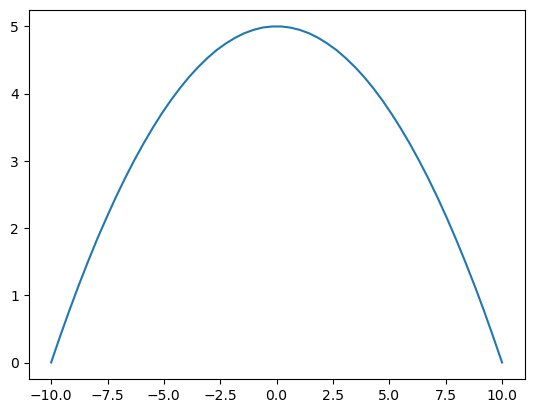

In [44]:
plt.plot(x,y)

In [45]:
y = pd.DataFrame(y)

In [46]:
x = pd.DataFrame(x)

In [47]:
emulator = GPE.ensemble(x,y,mean_func="constant",training_iter=500)

0


In [48]:
x_test = pd.DataFrame(np.linspace(-10,10,100))

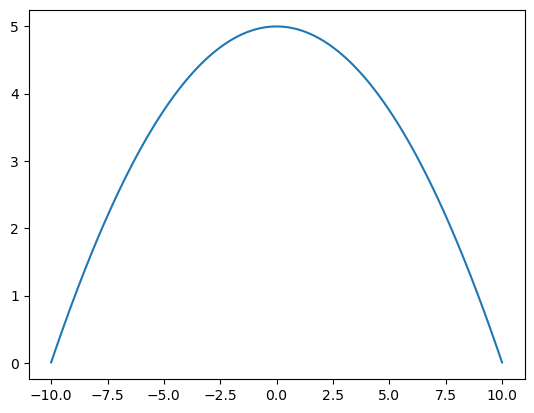

In [49]:
plt.plot(x_test,emulator.predict(x_test).detach().numpy())

In [50]:
xx=np.random.multivariate_normal(mean=[0], cov=np.identity(1),size=1000).T

In [51]:
y_test=pd.DataFrame(np.array([3]))

In [ ]:
result = minimize(ELBO, [1,1], args = (xx,emulator,y_test,0,1,x.columns),method = 'Nelder-Mead',tol=1e-6)

covariance: [[0.00011068]]
likelihood: tensor([[-12.9211]])
covariance: [[0.00011068]]
likelihood: tensor([[19.0041]])
covariance: [[0.00010878]]
likelihood: tensor([[-5.7568]])
covariance: [[0.00011068]]
likelihood: tensor([[-3.3344]])
covariance: [[0.00011068]]
likelihood: tensor([[2.1955]])
covariance: [[0.00011068]]
likelihood: tensor([[-12.4171]])
covariance: [[0.00010878]]
likelihood: tensor([[-12.1183]])
covariance: [[0.00010878]]
likelihood: tensor([[17.1756]])
covariance: [[0.00011259]]
likelihood: tensor([[-12.6543]])
covariance: [[0.00010687]]
likelihood: tensor([[-3.1189]])
covariance: [[0.00010687]]
likelihood: tensor([[-9.2259]])
covariance: [[0.00011068]]
likelihood: tensor([[-9.7607]])
covariance: [[0.00010878]]
likelihood: tensor([[-12.7377]])
covariance: [[0.00010878]]
likelihood: tensor([[6.0569]])
covariance: [[0.00010687]]
likelihood: tensor([[-13.0824]])
covariance: [[0.00010878]]
likelihood: tensor([[-13.0328]])
covariance: [[0.00011068]]
likelihood: tensor([[-0.

covariance: [[0.00011068]]
likelihood: tensor([[-10.8609]])
covariance: [[0.00011068]]
likelihood: tensor([[8.9363]])
covariance: [[0.00010878]]
likelihood: tensor([[-12.0951]])
covariance: [[0.00010687]]
likelihood: tensor([[-11.9589]])
covariance: [[0.00010878]]
likelihood: tensor([[-1.2210]])
covariance: [[0.00011068]]
likelihood: tensor([[4.2754]])
covariance: [[0.00011068]]
likelihood: tensor([[-1.4067]])
covariance: [[0.00011068]]
likelihood: tensor([[-5.8810]])
covariance: [[0.00011259]]
likelihood: tensor([[-11.5958]])
covariance: [[0.00010687]]
likelihood: tensor([[-1.6760]])
covariance: [[0.00010687]]
likelihood: tensor([[-13.0124]])
covariance: [[0.00010878]]
likelihood: tensor([[-12.1415]])
covariance: [[0.00011068]]
likelihood: tensor([[-5.0002]])
covariance: [[0.00010687]]
likelihood: tensor([[-10.9429]])
covariance: [[0.00010878]]
likelihood: tensor([[-12.8619]])
covariance: [[0.00010878]]
likelihood: tensor([[-12.8852]])
covariance: [[0.00010687]]
likelihood: tensor([[1

covariance: [[0.00010687]]
likelihood: tensor([[2.0464]])
covariance: [[0.00011068]]
likelihood: tensor([[-1.3491]])
covariance: [[0.00011068]]
likelihood: tensor([[34.3327]])
covariance: [[0.00010878]]
likelihood: tensor([[-4.3907]])
covariance: [[0.00010878]]
likelihood: tensor([[-8.0742]])
covariance: [[0.00011068]]
likelihood: tensor([[-13.1231]])
covariance: [[0.00010878]]
likelihood: tensor([[-2.2166]])
covariance: [[0.00010687]]
likelihood: tensor([[-9.7124]])
covariance: [[0.00010687]]
likelihood: tensor([[-11.6658]])
covariance: [[0.00010878]]
likelihood: tensor([[-11.4628]])
covariance: [[0.00011068]]
likelihood: tensor([[-7.6883]])
covariance: [[0.00010878]]
likelihood: tensor([[-12.1029]])
covariance: [[0.00011068]]
likelihood: tensor([[-4.4845]])
covariance: [[0.00010687]]
likelihood: tensor([[-13.2302]])
covariance: [[0.00011068]]
likelihood: tensor([[-8.5321]])
covariance: [[0.00010687]]
likelihood: tensor([[-12.0825]])
covariance: [[0.00010878]]
likelihood: tensor([[-9.

covariance: [[0.00011068]]
likelihood: tensor([[-11.9687]])
covariance: [[0.00010878]]
likelihood: tensor([[-1.5161]])
covariance: [[0.00011068]]
likelihood: tensor([[-0.9539]])
covariance: [[0.00010687]]
likelihood: tensor([[-12.7872]])
covariance: [[0.00011068]]
likelihood: tensor([[-9.1148]])
covariance: [[0.00010687]]
likelihood: tensor([[-13.1446]])
covariance: [[0.00010687]]
likelihood: tensor([[-11.1272]])
covariance: [[0.00010878]]
likelihood: tensor([[-6.2100]])
covariance: [[0.00011068]]
likelihood: tensor([[14.1937]])
covariance: [[0.00011068]]
likelihood: tensor([[15.6695]])
covariance: [[0.00010878]]
likelihood: tensor([[-12.3194]])
covariance: [[0.00011068]]
likelihood: tensor([[3.7083]])
covariance: [[0.00011068]]
likelihood: tensor([[23.2979]])
covariance: [[0.00011068]]
likelihood: tensor([[-7.8010]])
covariance: [[0.00010687]]
likelihood: tensor([[0.7908]])
covariance: [[0.00010878]]
likelihood: tensor([[-13.1805]])
covariance: [[0.00010878]]
likelihood: tensor([[-9.9

covariance: [[0.00010878]]
likelihood: tensor([[-10.7792]])
covariance: [[0.00010878]]
likelihood: tensor([[-9.9384]])
covariance: [[0.00010687]]
likelihood: tensor([[-11.9975]])
covariance: [[0.00010687]]
likelihood: tensor([[3.0675]])
covariance: [[0.00010687]]
likelihood: tensor([[-9.3170]])
covariance: [[0.00010687]]
likelihood: tensor([[-8.3178]])
covariance: [[0.00010687]]
likelihood: tensor([[-11.6118]])
covariance: [[0.00010878]]
likelihood: tensor([[-8.8445]])
covariance: [[0.00010687]]
likelihood: tensor([[-12.8881]])
covariance: [[0.00010687]]
likelihood: tensor([[-9.4005]])
covariance: [[0.00010687]]
likelihood: tensor([[-5.4400]])
covariance: [[0.00011068]]
likelihood: tensor([[-1.6660]])
covariance: [[0.00010878]]
likelihood: tensor([[-11.3474]])
covariance: [[0.00011068]]
likelihood: tensor([[-13.1464]])
covariance: [[0.00010687]]
likelihood: tensor([[-11.1195]])
covariance: [[0.00010878]]
likelihood: tensor([[-9.8393]])
covariance: [[0.00011068]]
likelihood: tensor([[-1

covariance: [[0.00010878]]
likelihood: tensor([[-10.2513]])
covariance: [[0.00010878]]
likelihood: tensor([[27.2849]])
covariance: [[0.00011068]]
likelihood: tensor([[-13.1309]])
covariance: [[0.00011068]]
likelihood: tensor([[-9.8597]])
covariance: [[0.00011068]]
likelihood: tensor([[6.6751]])
covariance: [[0.00011068]]
likelihood: tensor([[24.3756]])
covariance: [[0.00010687]]
likelihood: tensor([[-9.1576]])
covariance: [[0.00010878]]
likelihood: tensor([[16.8849]])
covariance: [[0.00010687]]
likelihood: tensor([[-9.3094]])
covariance: [[0.00011068]]
likelihood: tensor([[-10.0655]])
covariance: [[0.00010687]]
likelihood: tensor([[-6.8085]])
covariance: [[0.00011068]]
likelihood: tensor([[-2.9119]])
covariance: [[0.00010878]]
likelihood: tensor([[-9.9079]])
covariance: [[0.00011068]]
likelihood: tensor([[-12.6340]])
covariance: [[0.00010687]]
likelihood: tensor([[-2.5516]])
covariance: [[0.00011068]]
likelihood: tensor([[8.7367]])
covariance: [[0.00010878]]
likelihood: tensor([[10.298

covariance: [[0.00011068]]
likelihood: tensor([[-11.3600]])
covariance: [[0.00010878]]
likelihood: tensor([[-13.1339]])
covariance: [[0.00011068]]
likelihood: tensor([[-0.8893]])
covariance: [[0.00010878]]
likelihood: tensor([[-10.9863]])
covariance: [[0.00011068]]
likelihood: tensor([[-12.9677]])
covariance: [[0.00011068]]
likelihood: tensor([[7.1145]])
covariance: [[0.00011068]]
likelihood: tensor([[-12.8512]])
covariance: [[0.00011068]]
likelihood: tensor([[-9.5172]])
covariance: [[0.00011068]]
likelihood: tensor([[-9.8749]])
covariance: [[0.00011068]]
likelihood: tensor([[-8.9102]])
covariance: [[0.00010878]]
likelihood: tensor([[-10.4577]])
covariance: [[0.00010687]]
likelihood: tensor([[2.0464]])
covariance: [[0.00010687]]
likelihood: tensor([[-12.5856]])
covariance: [[0.00011068]]
likelihood: tensor([[-11.3292]])
covariance: [[0.00010687]]
likelihood: tensor([[-13.1835]])
covariance: [[0.00010878]]
likelihood: tensor([[-8.0818]])
covariance: [[0.00011068]]
likelihood: tensor([[-

covariance: [[0.00010878]]
likelihood: tensor([[-13.0717]])
covariance: [[0.00010687]]
likelihood: tensor([[-10.5597]])
covariance: [[0.00010878]]
likelihood: tensor([[10.5279]])
covariance: [[0.00010878]]
likelihood: tensor([[-4.1997]])
covariance: [[0.00010687]]
likelihood: tensor([[-12.9114]])
covariance: [[0.00010687]]
likelihood: tensor([[-13.0280]])
covariance: [[0.00010878]]
likelihood: tensor([[10.0020]])
covariance: [[0.00011068]]
likelihood: tensor([[-11.7604]])
covariance: [[0.00010878]]
likelihood: tensor([[4.4128]])
covariance: [[0.00011068]]
likelihood: tensor([[-1.4787]])
covariance: [[0.00011068]]
likelihood: tensor([[6.5531]])
covariance: [[0.00010687]]
likelihood: tensor([[-12.3919]])
covariance: [[0.00010878]]
likelihood: tensor([[7.2761]])
covariance: [[0.00010687]]
likelihood: tensor([[-10.8355]])
covariance: [[0.00011068]]
likelihood: tensor([[10.8552]])
covariance: [[0.00011068]]
likelihood: tensor([[-10.6923]])
covariance: [[0.00011068]]
likelihood: tensor([[7.1

covariance: [[0.00010687]]
likelihood: tensor([[-9.6134]])
covariance: [[0.00011068]]
likelihood: tensor([[0.8283]])
covariance: [[0.00011068]]
likelihood: tensor([[-10.4933]])
covariance: [[0.00010878]]
likelihood: tensor([[-5.5344]])
covariance: [[0.00010687]]
likelihood: tensor([[-11.4193]])
covariance: [[0.00010878]]
likelihood: tensor([[-5.7939]])
covariance: [[0.00010687]]
likelihood: tensor([[-12.4616]])
covariance: [[0.00010687]]
likelihood: tensor([[-10.4985]])
covariance: [[0.00010878]]
likelihood: tensor([[-1.6458]])
covariance: [[0.00011068]]
likelihood: tensor([[6.1661]])
covariance: [[0.00010687]]
likelihood: tensor([[-10.6057]])
covariance: [[0.00010687]]
likelihood: tensor([[43.2708]])
covariance: [[0.00011068]]
likelihood: tensor([[-6.9164]])
covariance: [[0.00010687]]
likelihood: tensor([[-11.9975]])
covariance: [[0.00011259]]
likelihood: tensor([[3.8890]])
covariance: [[0.00011259]]
likelihood: tensor([[-6.9891]])
covariance: [[0.00010687]]
likelihood: tensor([[-13.0

covariance: [[0.00011068]]
likelihood: tensor([[-13.1309]])
covariance: [[0.00010687]]
likelihood: tensor([[-13.1057]])
covariance: [[0.00010878]]
likelihood: tensor([[11.1756]])
covariance: [[0.00010687]]
likelihood: tensor([[-11.2347]])
covariance: [[0.00011068]]
likelihood: tensor([[-4.6243]])
covariance: [[0.00011068]]
likelihood: tensor([[3.8607]])
covariance: [[0.00010878]]
likelihood: tensor([[12.5953]])
covariance: [[0.00010878]]
likelihood: tensor([[3.3258]])
covariance: [[0.00010878]]
likelihood: tensor([[4.5162]])
covariance: [[0.00011068]]
likelihood: tensor([[-9.5248]])
covariance: [[0.00011068]]
likelihood: tensor([[-13.1931]])
covariance: [[0.00011068]]
likelihood: tensor([[-13.1464]])
covariance: [[0.00010687]]
likelihood: tensor([[-1.6255]])
covariance: [[0.00011068]]
likelihood: tensor([[13.4035]])
covariance: [[0.00011068]]
likelihood: tensor([[-13.1309]])
covariance: [[0.00010878]]
likelihood: tensor([[-12.5594]])
covariance: [[0.00010878]]
likelihood: tensor([[-13.

covariance: [[0.00010878]]
likelihood: tensor([[-9.5805]])
covariance: [[0.00011068]]
likelihood: tensor([[1.9639]])
covariance: [[0.00010878]]
likelihood: tensor([[-11.6861]])
covariance: [[0.00011068]]
likelihood: tensor([[-10.6617]])
covariance: [[0.00010687]]
likelihood: tensor([[-2.8786]])
covariance: [[0.00011068]]
likelihood: tensor([[-11.1371]])
covariance: [[0.00010496]]
likelihood: tensor([[-11.8460]])
covariance: [[0.00010687]]
likelihood: tensor([[-4.8120]])
covariance: [[0.00010687]]
likelihood: tensor([[-7.8506]])
covariance: [[0.00010878]]
likelihood: tensor([[-12.0720]])
covariance: [[0.00010878]]
likelihood: tensor([[-11.4859]])
covariance: [[0.00011068]]
likelihood: tensor([[-6.7521]])
covariance: [[0.00010878]]
likelihood: tensor([[-13.0406]])
covariance: [[0.00010878]]
likelihood: tensor([[14.8845]])
covariance: [[0.00010496]]
likelihood: tensor([[-12.0854]])
covariance: [[0.00010687]]
likelihood: tensor([[-6.6368]])
covariance: [[0.00011068]]
likelihood: tensor([[3

covariance: [[0.00010878]]
likelihood: tensor([[8.5968]])
covariance: [[0.00010496]]
likelihood: tensor([[-12.6195]])
covariance: [[0.00010878]]
likelihood: tensor([[-10.8175]])
covariance: [[0.00011068]]
likelihood: tensor([[-7.5081]])
covariance: [[0.00010878]]
likelihood: tensor([[1.6113]])
covariance: [[0.00011068]]
likelihood: tensor([[-3.3198]])
covariance: [[0.00010878]]
likelihood: tensor([[-8.9050]])
covariance: [[0.00011068]]
likelihood: tensor([[-3.8021]])
covariance: [[0.00011068]]
likelihood: tensor([[-12.8124]])
covariance: [[0.00010687]]
likelihood: tensor([[-13.2146]])
covariance: [[0.00010687]]
likelihood: tensor([[1.5399]])
covariance: [[0.00010687]]
likelihood: tensor([[-5.8107]])
covariance: [[0.00010687]]
likelihood: tensor([[-7.0403]])
covariance: [[0.00010878]]
likelihood: tensor([[-9.4133]])
covariance: [[0.00011068]]
likelihood: tensor([[-1.4283]])
covariance: [[0.00011068]]
likelihood: tensor([[-3.4366]])
covariance: [[0.00010687]]
likelihood: tensor([[-2.6315

covariance: [[0.00010878]]
likelihood: tensor([[-13.0872]])
covariance: [[0.00010687]]
likelihood: tensor([[-13.2224]])
covariance: [[0.00010687]]
likelihood: tensor([[-5.0629]])
covariance: [[0.00010878]]
likelihood: tensor([[-9.2538]])
covariance: [[0.00010878]]
likelihood: tensor([[-2.6590]])
covariance: [[0.00011068]]
likelihood: tensor([[-13.1620]])
covariance: [[0.00011068]]
likelihood: tensor([[-11.2293]])
covariance: [[0.00011068]]
likelihood: tensor([[-9.5172]])
covariance: [[0.00010878]]
likelihood: tensor([[-5.3715]])
covariance: [[0.00010687]]
likelihood: tensor([[7.9750]])
covariance: [[0.00011068]]
likelihood: tensor([[-3.3928]])
covariance: [[0.00011068]]
likelihood: tensor([[-10.3175]])
covariance: [[0.00010687]]
likelihood: tensor([[-11.7352]])
covariance: [[0.00010878]]
likelihood: tensor([[-13.1416]])
covariance: [[0.00010687]]
likelihood: tensor([[2.4250]])
covariance: [[0.00010878]]
likelihood: tensor([[7.4378]])
covariance: [[0.00011068]]
likelihood: tensor([[-10.

covariance: [[0.00011068]]
likelihood: tensor([[-12.8822]])
covariance: [[0.00010878]]
likelihood: tensor([[-10.2895]])
covariance: [[0.00011068]]
likelihood: tensor([[-10.1418]])
covariance: [[0.00010687]]
likelihood: tensor([[-12.4461]])
covariance: [[0.00011068]]
likelihood: tensor([[-2.0343]])
covariance: [[0.00010687]]
likelihood: tensor([[-8.1895]])
covariance: [[0.00010687]]
likelihood: tensor([[-12.5313]])
covariance: [[0.00011068]]
likelihood: tensor([[-12.8900]])
covariance: [[0.00010687]]
likelihood: tensor([[-11.6889]])
covariance: [[0.00010878]]
likelihood: tensor([[20.0732]])
covariance: [[0.00010878]]
likelihood: tensor([[-11.1091]])
covariance: [[0.00010687]]
likelihood: tensor([[-11.3578]])
covariance: [[0.00010687]]
likelihood: tensor([[-10.8509]])
covariance: [[0.00011068]]
likelihood: tensor([[31.2536]])
covariance: [[0.00010878]]
likelihood: tensor([[13.1352]])
covariance: [[0.00010878]]
likelihood: tensor([[-10.1215]])
covariance: [[0.00011068]]
likelihood: tensor

covariance: [[0.00010878]]
likelihood: tensor([[4.2127]])
covariance: [[0.00011068]]
likelihood: tensor([[-7.3881]])
covariance: [[0.00010878]]
likelihood: tensor([[-7.4278]])
covariance: [[0.00011068]]
likelihood: tensor([[-11.7373]])
covariance: [[0.00010878]]
likelihood: tensor([[-10.9326]])
covariance: [[0.00010878]]
likelihood: tensor([[-8.3456]])
covariance: [[0.00011068]]
likelihood: tensor([[-9.8902]])
covariance: [[0.00010878]]
likelihood: tensor([[-13.1494]])
covariance: [[0.00011068]]
likelihood: tensor([[-13.0143]])
covariance: [[0.00011068]]
likelihood: tensor([[-9.5628]])
covariance: [[0.00011068]]
likelihood: tensor([[-9.8673]])
covariance: [[0.00010687]]
likelihood: tensor([[-10.3456]])
covariance: [[0.00010878]]
likelihood: tensor([[-10.5954]])
covariance: [[0.00011068]]
likelihood: tensor([[-12.4790]])
covariance: [[0.00011068]]
likelihood: tensor([[2.3707]])
covariance: [[0.00011068]]
likelihood: tensor([[-13.1620]])
covariance: [[0.00010687]]
likelihood: tensor([[-1

covariance: [[0.00010878]]
likelihood: tensor([[-7.1205]])
covariance: [[0.00011068]]
likelihood: tensor([[-7.5081]])
covariance: [[0.00011068]]
likelihood: tensor([[-12.3629]])
covariance: [[0.00010878]]
likelihood: tensor([[-9.6414]])
covariance: [[0.00011068]]
likelihood: tensor([[4.8813]])
covariance: [[0.00010687]]
likelihood: tensor([[-10.0401]])
covariance: [[0.00011068]]
likelihood: tensor([[9.7247]])
covariance: [[0.00011068]]
likelihood: tensor([[23.2979]])
covariance: [[0.00011068]]
likelihood: tensor([[2.7482]])
covariance: [[0.00011068]]
likelihood: tensor([[-6.5804]])
covariance: [[0.00011068]]
likelihood: tensor([[14.4791]])
covariance: [[0.00010878]]
likelihood: tensor([[-3.0153]])
covariance: [[0.00011068]]
likelihood: tensor([[5.5663]])
covariance: [[0.00010496]]
likelihood: tensor([[-12.8833]])
covariance: [[0.00011068]]
likelihood: tensor([[-12.1000]])
covariance: [[0.00011068]]
likelihood: tensor([[-6.4835]])
covariance: [[0.00011068]]
likelihood: tensor([[-13.1697

covariance: [[0.00010878]]
likelihood: tensor([[-3.4382]])
covariance: [[0.00010878]]
likelihood: tensor([[-12.9318]])
covariance: [[0.00010687]]
likelihood: tensor([[35.5799]])
covariance: [[0.00010496]]
likelihood: tensor([[-13.0154]])
covariance: [[0.00010687]]
likelihood: tensor([[-12.7174]])
covariance: [[0.00010878]]
likelihood: tensor([[-9.3373]])
covariance: [[0.00010687]]
likelihood: tensor([[-13.0746]])
covariance: [[0.00011068]]
likelihood: tensor([[13.0961]])
covariance: [[0.00010878]]
likelihood: tensor([[-13.1883]])
covariance: [[0.00010687]]
likelihood: tensor([[-7.2051]])
covariance: [[0.00011068]]
likelihood: tensor([[-11.6217]])
covariance: [[0.00010878]]
likelihood: tensor([[-12.3968]])
covariance: [[0.00011068]]
likelihood: tensor([[10.2256]])
covariance: [[0.00011068]]
likelihood: tensor([[3.2570]])
covariance: [[0.00011068]]
likelihood: tensor([[11.6893]])
covariance: [[0.00010878]]
likelihood: tensor([[-0.6828]])
covariance: [[0.00011068]]
likelihood: tensor([[-2

covariance: [[0.00010878]]
likelihood: tensor([[-11.4628]])
covariance: [[0.00010878]]
likelihood: tensor([[-13.0561]])
covariance: [[0.00011068]]
likelihood: tensor([[3.1595]])
covariance: [[0.00010687]]
likelihood: tensor([[8.2830]])
covariance: [[0.00010687]]
likelihood: tensor([[-10.4220]])
covariance: [[0.00010878]]
likelihood: tensor([[7.4041]])
covariance: [[0.00011068]]
likelihood: tensor([[2.2656]])
covariance: [[0.00010878]]
likelihood: tensor([[-10.4424]])
covariance: [[0.00011068]]
likelihood: tensor([[1.8936]])
covariance: [[0.00010878]]
likelihood: tensor([[-13.1883]])
covariance: [[0.00011068]]
likelihood: tensor([[-11.4446]])
covariance: [[0.00010687]]
likelihood: tensor([[22.2403]])
covariance: [[0.00010878]]
likelihood: tensor([[-2.6663]])
covariance: [[0.00010687]]
likelihood: tensor([[-11.2963]])
covariance: [[0.00011068]]
likelihood: tensor([[-7.2307]])
covariance: [[0.00011259]]
likelihood: tensor([[-11.8656]])
covariance: [[0.00011068]]
likelihood: tensor([[32.67

covariance: [[0.00011068]]
likelihood: tensor([[-10.6310]])
covariance: [[0.00011068]]
likelihood: tensor([[-10.4933]])
covariance: [[0.00010878]]
likelihood: tensor([[-12.2884]])
covariance: [[0.00010687]]
likelihood: tensor([[-1.4166]])
covariance: [[0.00011068]]
likelihood: tensor([[-7.7484]])
covariance: [[0.00011068]]
likelihood: tensor([[-12.3165]])
covariance: [[0.00010878]]
likelihood: tensor([[-12.7300]])
covariance: [[0.00010878]]
likelihood: tensor([[-11.4243]])
covariance: [[0.00010878]]
likelihood: tensor([[21.0106]])
covariance: [[0.00010687]]
likelihood: tensor([[-10.8355]])
covariance: [[0.00010687]]
likelihood: tensor([[-11.0964]])
covariance: [[0.00010878]]
likelihood: tensor([[-11.1629]])
covariance: [[0.00010878]]
likelihood: tensor([[32.2456]])
covariance: [[0.00010878]]
likelihood: tensor([[14.0229]])
covariance: [[0.00011068]]
likelihood: tensor([[-10.4627]])
covariance: [[0.00010687]]
likelihood: tensor([[-5.0555]])
covariance: [[0.00010687]]
likelihood: tensor(

covariance: [[0.00011068]]
likelihood: tensor([[-13.0143]])
covariance: [[0.00010687]]
likelihood: tensor([[4.9627]])
covariance: [[0.00011068]]
likelihood: tensor([[-6.8940]])
covariance: [[0.00010878]]
likelihood: tensor([[-6.9185]])
covariance: [[0.00010878]]
likelihood: tensor([[-11.9716]])
covariance: [[0.00011068]]
likelihood: tensor([[-11.1755]])
covariance: [[0.00010878]]
likelihood: tensor([[-7.8860]])
covariance: [[0.00010878]]
likelihood: tensor([[-9.5501]])
covariance: [[0.00010878]]
likelihood: tensor([[-13.2116]])
covariance: [[0.00010687]]
likelihood: tensor([[-13.1057]])
covariance: [[0.00011068]]
likelihood: tensor([[-9.1907]])
covariance: [[0.00011068]]
likelihood: tensor([[-10.2029]])
covariance: [[0.00010687]]
likelihood: tensor([[-9.9943]])
covariance: [[0.00011068]]
likelihood: tensor([[-10.2869]])
covariance: [[0.00010687]]
likelihood: tensor([[-12.3068]])
covariance: [[0.00010878]]
likelihood: tensor([[3.1379]])
covariance: [[0.00011068]]
likelihood: tensor([[-1

covariance: [[0.00010878]]
likelihood: tensor([[5.1896]])
covariance: [[0.00010878]]
likelihood: tensor([[1.7029]])
covariance: [[0.00011068]]
likelihood: tensor([[-12.5255]])
covariance: [[0.00010687]]
likelihood: tensor([[-6.8235]])
covariance: [[0.00010687]]
likelihood: tensor([[-7.2650]])
covariance: [[0.00010878]]
likelihood: tensor([[-12.3503]])
covariance: [[0.00011068]]
likelihood: tensor([[-9.4412]])
covariance: [[0.00011259]]
likelihood: tensor([[5.7101]])
covariance: [[0.00011068]]
likelihood: tensor([[-9.9054]])
covariance: [[0.00011259]]
likelihood: tensor([[10.7698]])
covariance: [[0.00010687]]
likelihood: tensor([[24.7571]])
covariance: [[0.00011068]]
likelihood: tensor([[3.4516]])
covariance: [[0.00010687]]
likelihood: tensor([[-6.3162]])
covariance: [[0.00010878]]
likelihood: tensor([[15.6453]])
covariance: [[0.00010878]]
likelihood: tensor([[-2.5283]])
covariance: [[0.00011068]]
likelihood: tensor([[6.4039]])
covariance: [[0.00010878]]
likelihood: tensor([[-12.8619]])

covariance: [[0.00010687]]
likelihood: tensor([[4.4812]])
covariance: [[0.00010878]]
likelihood: tensor([[-8.0591]])
covariance: [[0.00010687]]
likelihood: tensor([[-13.1835]])
covariance: [[0.00010687]]
likelihood: tensor([[-11.5425]])
covariance: [[0.00011068]]
likelihood: tensor([[9.0559]])
covariance: [[0.00010687]]
likelihood: tensor([[-13.2146]])
covariance: [[0.00011068]]
likelihood: tensor([[-13.1542]])
covariance: [[0.00011068]]
likelihood: tensor([[18.8463]])
covariance: [[0.00011068]]
likelihood: tensor([[23.1819]])
covariance: [[0.00010878]]
likelihood: tensor([[4.4886]])
covariance: [[0.00010687]]
likelihood: tensor([[-6.4056]])
covariance: [[0.00010878]]
likelihood: tensor([[-7.1954]])
covariance: [[0.00010878]]
likelihood: tensor([[-10.0147]])
covariance: [[0.00010878]]
likelihood: tensor([[10.2653]])
covariance: [[0.00010878]]
likelihood: tensor([[27.1629]])
covariance: [[0.00010878]]
likelihood: tensor([[-3.3944]])
covariance: [[0.00010687]]
likelihood: tensor([[-10.85

covariance: [[0.00010878]]
likelihood: tensor([[-12.7765]])
covariance: [[0.00010878]]
likelihood: tensor([[-10.7026]])
covariance: [[0.00010878]]
likelihood: tensor([[-12.9706]])
covariance: [[0.00011068]]
likelihood: tensor([[-9.8597]])
covariance: [[0.00010687]]
likelihood: tensor([[-12.1444]])
covariance: [[0.00011068]]
likelihood: tensor([[-9.7531]])
covariance: [[0.00010878]]
likelihood: tensor([[11.0385]])
covariance: [[0.00011068]]
likelihood: tensor([[-10.0884]])
covariance: [[0.00011068]]
likelihood: tensor([[3.4168]])
covariance: [[0.00011068]]
likelihood: tensor([[-10.2334]])
covariance: [[0.00011068]]
likelihood: tensor([[-11.4138]])
covariance: [[0.00010687]]
likelihood: tensor([[-13.0902]])
covariance: [[0.00011068]]
likelihood: tensor([[-10.8149]])
covariance: [[0.00010878]]
likelihood: tensor([[-8.6478]])
covariance: [[0.00011259]]
likelihood: tensor([[-0.2228]])
covariance: [[0.00010878]]
likelihood: tensor([[-4.6408]])
covariance: [[0.00010687]]
likelihood: tensor([[

covariance: [[0.00011068]]
likelihood: tensor([[-8.5018]])
covariance: [[0.00010878]]
likelihood: tensor([[-9.9384]])
covariance: [[0.00010687]]
likelihood: tensor([[-10.7512]])
covariance: [[0.00010687]]
likelihood: tensor([[-12.6553]])
covariance: [[0.00011068]]
likelihood: tensor([[16.7413]])
covariance: [[0.00010687]]
likelihood: tensor([[14.4173]])
covariance: [[0.00011068]]
likelihood: tensor([[14.5171]])
covariance: [[0.00011068]]
likelihood: tensor([[1.9779]])
covariance: [[0.00010878]]
likelihood: tensor([[-3.4601]])
covariance: [[0.00010878]]
likelihood: tensor([[-10.8482]])
covariance: [[0.00011068]]
likelihood: tensor([[8.2362]])
covariance: [[0.00011068]]
likelihood: tensor([[-6.7371]])
covariance: [[0.00011068]]
likelihood: tensor([[-12.9288]])
covariance: [[0.00011068]]
likelihood: tensor([[-12.9288]])
covariance: [[0.00010878]]
likelihood: tensor([[11.9233]])
covariance: [[0.00010687]]
likelihood: tensor([[-2.8568]])
covariance: [[0.00011068]]
likelihood: tensor([[-1.16

covariance: [[0.00011068]]
likelihood: tensor([[-1.8103]])
covariance: [[0.00011259]]
likelihood: tensor([[-12.4994]])
covariance: [[0.00010687]]
likelihood: tensor([[24.2593]])
covariance: [[0.00010687]]
likelihood: tensor([[-4.9670]])
covariance: [[0.00010687]]
likelihood: tensor([[-2.1312]])
covariance: [[0.00011068]]
likelihood: tensor([[4.4341]])
covariance: [[0.00010878]]
likelihood: tensor([[-12.6059]])
covariance: [[0.00011068]]
likelihood: tensor([[-11.3369]])
covariance: [[0.00011068]]
likelihood: tensor([[22.1311]])
covariance: [[0.00010878]]
likelihood: tensor([[-12.1724]])
covariance: [[0.00010878]]
likelihood: tensor([[-1.8695]])
covariance: [[0.00010687]]
likelihood: tensor([[-9.0287]])
covariance: [[0.00010687]]
likelihood: tensor([[-9.6591]])
covariance: [[0.00011068]]
likelihood: tensor([[-12.8900]])
covariance: [[0.00010878]]
likelihood: tensor([[9.0360]])
covariance: [[0.00011068]]
likelihood: tensor([[-12.8124]])
covariance: [[0.00010878]]
likelihood: tensor([[-12.

covariance: [[0.00010878]]
likelihood: tensor([[-13.1339]])
covariance: [[0.00010687]]
likelihood: tensor([[-12.3145]])
covariance: [[0.00010687]]
likelihood: tensor([[-4.1207]])
covariance: [[0.0001145]]
likelihood: tensor([[-9.5503]])
covariance: [[0.00010878]]
likelihood: tensor([[-13.0172]])
covariance: [[0.00010687]]
likelihood: tensor([[-13.0124]])
covariance: [[0.00011068]]
likelihood: tensor([[22.8330]])
covariance: [[0.00011068]]
likelihood: tensor([[-9.5020]])
covariance: [[0.00010687]]
likelihood: tensor([[-13.1991]])
covariance: [[0.00010878]]
likelihood: tensor([[13.2378]])
covariance: [[0.00010878]]
likelihood: tensor([[-12.2497]])
covariance: [[0.00011068]]
likelihood: tensor([[-1.1693]])
covariance: [[0.00011068]]
likelihood: tensor([[-4.0512]])
covariance: [[0.00011068]]
likelihood: tensor([[8.0422]])
covariance: [[0.00011068]]
likelihood: tensor([[5.8325]])
covariance: [[0.00010687]]
likelihood: tensor([[-12.0748]])
covariance: [[0.00011068]]
likelihood: tensor([[4.79

covariance: [[0.00010687]]
likelihood: tensor([[-5.2329]])
covariance: [[0.00010878]]
likelihood: tensor([[-12.2575]])
covariance: [[0.00010878]]
likelihood: tensor([[-3.4748]])
covariance: [[0.00011068]]
likelihood: tensor([[-13.1386]])
covariance: [[0.00011068]]
likelihood: tensor([[-8.2603]])
covariance: [[0.00011068]]
likelihood: tensor([[-11.2601]])
covariance: [[0.00010878]]
likelihood: tensor([[-9.3145]])
covariance: [[0.00010878]]
likelihood: tensor([[-13.1883]])
covariance: [[0.00011068]]
likelihood: tensor([[-2.6502]])
covariance: [[0.00010687]]
likelihood: tensor([[-9.3854]])
covariance: [[0.00011068]]
likelihood: tensor([[-6.3866]])
covariance: [[0.00010878]]
likelihood: tensor([[-11.9561]])
covariance: [[0.00010878]]
likelihood: tensor([[-11.5321]])
covariance: [[0.00010878]]
likelihood: tensor([[1.1598]])
covariance: [[0.00010687]]
likelihood: tensor([[10.8820]])
covariance: [[0.00011068]]
likelihood: tensor([[8.7100]])
covariance: [[0.00010687]]
likelihood: tensor([[-3.0

likelihood: tensor([[-12.4229]])
covariance: [[0.00010878]]
likelihood: tensor([[6.2066]])
covariance: [[0.00011068]]
likelihood: tensor([[29.1983]])
covariance: [[0.00010878]]
likelihood: tensor([[-7.3453]])
covariance: [[0.00010878]]
likelihood: tensor([[2.8033]])
covariance: [[0.00010687]]
likelihood: tensor([[-13.0824]])
covariance: [[0.00010687]]
likelihood: tensor([[-9.8876]])
covariance: [[0.00011068]]
likelihood: tensor([[-12.7814]])
covariance: [[0.00011068]]
likelihood: tensor([[-11.4908]])
covariance: [[0.00010687]]
likelihood: tensor([[27.1708]])
covariance: [[0.00010687]]
likelihood: tensor([[1.2154]])
covariance: [[0.00011068]]
likelihood: tensor([[-10.7383]])
covariance: [[0.00010687]]
likelihood: tensor([[-1.1648]])
covariance: [[0.00011068]]
likelihood: tensor([[-10.6157]])
covariance: [[0.00011068]]
likelihood: tensor([[0.3103]])
covariance: [[0.00010687]]
likelihood: tensor([[12.2409]])
covariance: [[0.00011068]]
likelihood: tensor([[32.6055]])
covariance: [[0.000108

covariance: [[0.00011068]]
likelihood: tensor([[-11.7065]])
covariance: [[0.00010878]]
likelihood: tensor([[-6.7616]])
covariance: [[0.00010878]]
likelihood: tensor([[-13.0017]])
covariance: [[0.00011068]]
likelihood: tensor([[-9.1983]])
covariance: [[0.00011068]]
likelihood: tensor([[-4.5728]])
covariance: [[0.00011068]]
likelihood: tensor([[-0.1241]])
covariance: [[0.00010687]]
likelihood: tensor([[-10.2157]])
covariance: [[0.00011068]]
likelihood: tensor([[-13.1775]])
covariance: [[0.00010687]]
likelihood: tensor([[-11.2117]])
covariance: [[0.00011068]]
likelihood: tensor([[-9.7378]])
covariance: [[0.00010878]]
likelihood: tensor([[-11.6399]])
covariance: [[0.00011068]]
likelihood: tensor([[-8.5698]])
covariance: [[0.00011068]]
likelihood: tensor([[-11.4138]])
covariance: [[0.00010687]]
likelihood: tensor([[25.4787]])
covariance: [[0.00010687]]
likelihood: tensor([[-12.4151]])
covariance: [[0.00010878]]
likelihood: tensor([[-0.9696]])
covariance: [[0.00010878]]
likelihood: tensor([[

covariance: [[0.00010878]]
likelihood: tensor([[-6.7691]])
covariance: [[0.00010687]]
likelihood: tensor([[-2.0516]])
covariance: [[0.00010687]]
likelihood: tensor([[-10.3685]])
covariance: [[0.00011068]]
likelihood: tensor([[-13.0376]])
covariance: [[0.00011068]]
likelihood: tensor([[-1.6012]])
covariance: [[0.00010687]]
likelihood: tensor([[12.4540]])
covariance: [[0.00011068]]
likelihood: tensor([[14.4348]])
covariance: [[0.00010687]]
likelihood: tensor([[-12.6398]])
covariance: [[0.00011068]]
likelihood: tensor([[11.0512]])
covariance: [[0.00010687]]
likelihood: tensor([[-4.5469]])
covariance: [[0.00011068]]
likelihood: tensor([[-0.9324]])
covariance: [[0.00010878]]
likelihood: tensor([[16.0331]])
covariance: [[0.00011068]]
likelihood: tensor([[-4.9854]])
covariance: [[0.00011068]]
likelihood: tensor([[-12.9987]])
covariance: [[0.00010878]]
likelihood: tensor([[-4.3172]])
covariance: [[0.00010878]]
likelihood: tensor([[5.1073]])
covariance: [[0.00011068]]
likelihood: tensor([[-1.52

covariance: [[0.00010878]]
likelihood: tensor([[-11.8172]])
covariance: [[0.00010878]]
likelihood: tensor([[-9.9155]])
covariance: [[0.00010687]]
likelihood: tensor([[-6.3535]])
covariance: [[0.00011068]]
likelihood: tensor([[-9.2514]])
covariance: [[0.00010878]]
likelihood: tensor([[-10.9326]])
covariance: [[0.00011259]]
likelihood: tensor([[4.2001]])
covariance: [[0.00010878]]
likelihood: tensor([[-12.9706]])
covariance: [[0.00010687]]
likelihood: tensor([[-11.8817]])
covariance: [[0.00010878]]
likelihood: tensor([[-13.1183]])
covariance: [[0.00011068]]
likelihood: tensor([[-8.2679]])
covariance: [[0.00011068]]
likelihood: tensor([[-12.7581]])
covariance: [[0.00010878]]
likelihood: tensor([[5.1484]])
covariance: [[0.00010878]]
likelihood: tensor([[-5.7865]])
covariance: [[0.00010878]]
likelihood: tensor([[21.7150]])
covariance: [[0.00010878]]
likelihood: tensor([[-11.9330]])
covariance: [[0.00011068]]
likelihood: tensor([[2.1604]])
covariance: [[0.00011068]]
likelihood: tensor([[1.71

covariance: [[0.00011068]]
likelihood: tensor([[-12.4016]])
covariance: [[0.00011068]]
likelihood: tensor([[-7.5231]])
covariance: [[0.00011068]]
likelihood: tensor([[14.7574]])
covariance: [[0.00010878]]
likelihood: tensor([[-3.6502]])
covariance: [[0.00010687]]
likelihood: tensor([[-13.1757]])
covariance: [[0.00010878]]
likelihood: tensor([[-12.2420]])
covariance: [[0.00011068]]
likelihood: tensor([[14.0857]])
covariance: [[0.00010878]]
likelihood: tensor([[-9.6490]])
covariance: [[0.00011068]]
likelihood: tensor([[7.0740]])
covariance: [[0.00011068]]
likelihood: tensor([[-0.2311]])
covariance: [[0.00011068]]
likelihood: tensor([[9.7578]])
covariance: [[0.00011068]]
likelihood: tensor([[-12.7891]])
covariance: [[0.00011068]]
likelihood: tensor([[10.6850]])
covariance: [[0.00011068]]
likelihood: tensor([[-11.3985]])
covariance: [[0.00010687]]
likelihood: tensor([[15.1501]])
covariance: [[0.00011068]]
likelihood: tensor([[-11.1986]])
covariance: [[0.00010878]]
likelihood: tensor([[10.5

covariance: [[0.00011068]]
likelihood: tensor([[-5.3178]])
covariance: [[0.00010878]]
likelihood: tensor([[-10.9326]])
covariance: [[0.00010878]]
likelihood: tensor([[-8.3154]])
covariance: [[0.00010878]]
likelihood: tensor([[-10.9326]])
covariance: [[0.00011068]]
likelihood: tensor([[-5.1626]])
covariance: [[0.00010687]]
likelihood: tensor([[-11.6041]])
covariance: [[0.00010687]]
likelihood: tensor([[3.1233]])
covariance: [[0.00010687]]
likelihood: tensor([[2.2989]])
covariance: [[0.00011068]]
likelihood: tensor([[-3.1667]])
covariance: [[0.00011068]]
likelihood: tensor([[-6.6028]])
covariance: [[0.00011068]]
likelihood: tensor([[4.7851]])
covariance: [[0.00010878]]
likelihood: tensor([[-7.0158]])
covariance: [[0.00011068]]
likelihood: tensor([[18.0903]])
covariance: [[0.00010878]]
likelihood: tensor([[-10.6107]])
covariance: [[0.00011068]]
likelihood: tensor([[-13.0842]])
covariance: [[0.00011068]]
likelihood: tensor([[24.0255]])
covariance: [[0.00011068]]
likelihood: tensor([[-3.729

covariance: [[0.00010878]]
likelihood: tensor([[-12.8930]])
covariance: [[0.00011068]]
likelihood: tensor([[11.8451]])
covariance: [[0.00010687]]
likelihood: tensor([[-13.1446]])
covariance: [[0.00010878]]
likelihood: tensor([[-11.7941]])
covariance: [[0.00010878]]
likelihood: tensor([[-4.3833]])
covariance: [[0.00011068]]
likelihood: tensor([[-6.6924]])
covariance: [[0.00011068]]
likelihood: tensor([[-5.0223]])
covariance: [[0.00011068]]
likelihood: tensor([[12.4788]])
covariance: [[0.00011068]]
likelihood: tensor([[-4.9264]])
covariance: [[0.00011068]]
likelihood: tensor([[21.9195]])
covariance: [[0.00011068]]
likelihood: tensor([[-12.3784]])
covariance: [[0.00010687]]
likelihood: tensor([[21.8877]])
covariance: [[0.00011068]]
likelihood: tensor([[-10.6463]])
covariance: [[0.00011068]]
likelihood: tensor([[2.7901]])
covariance: [[0.00011068]]
likelihood: tensor([[33.3363]])
covariance: [[0.00010878]]
likelihood: tensor([[-0.6040]])
covariance: [[0.00011068]]
likelihood: tensor([[-13.

covariance: [[0.00010878]]
likelihood: tensor([[-12.6292]])
covariance: [[0.00010878]]
likelihood: tensor([[29.8636]])
covariance: [[0.00010878]]
likelihood: tensor([[-10.8789]])
covariance: [[0.00010878]]
likelihood: tensor([[1.4845]])
covariance: [[0.00010878]]
likelihood: tensor([[-11.8789]])
covariance: [[0.00011068]]
likelihood: tensor([[39.9307]])
covariance: [[0.00010878]]
likelihood: tensor([[-4.2217]])
covariance: [[0.00010687]]
likelihood: tensor([[-10.3303]])
covariance: [[0.00011068]]
likelihood: tensor([[-10.5621]])
covariance: [[0.00011068]]
likelihood: tensor([[53.9967]])
covariance: [[0.00011068]]
likelihood: tensor([[37.5358]])
covariance: [[0.00011068]]
likelihood: tensor([[22.5879]])
covariance: [[0.00010878]]
likelihood: tensor([[4.7777]])
covariance: [[0.00010878]]
likelihood: tensor([[-10.1978]])
covariance: [[0.00010878]]
likelihood: tensor([[19.9471]])
covariance: [[0.00010687]]
likelihood: tensor([[-10.7052]])
covariance: [[0.00011068]]
likelihood: tensor([[-10

covariance: [[0.00010687]]
likelihood: tensor([[-1.2367]])
covariance: [[0.00010687]]
likelihood: tensor([[-12.2913]])
covariance: [[0.00010878]]
likelihood: tensor([[-6.7392]])
covariance: [[0.00011068]]
likelihood: tensor([[-10.8302]])
covariance: [[0.00010878]]
likelihood: tensor([[17.6131]])
covariance: [[0.00010687]]
likelihood: tensor([[-9.6058]])
covariance: [[0.00010687]]
likelihood: tensor([[-13.1524]])
covariance: [[0.00011068]]
likelihood: tensor([[-10.0045]])
covariance: [[0.00010878]]
likelihood: tensor([[19.8389]])
covariance: [[0.00010687]]
likelihood: tensor([[-11.6504]])
covariance: [[0.00011068]]
likelihood: tensor([[0.7008]])
covariance: [[0.00010878]]
likelihood: tensor([[-2.7099]])
covariance: [[0.00011068]]
likelihood: tensor([[13.8949]])
covariance: [[0.00010687]]
likelihood: tensor([[-12.1289]])
covariance: [[0.00010878]]
likelihood: tensor([[-10.5112]])
covariance: [[0.00010687]]
likelihood: tensor([[-6.4131]])
covariance: [[0.00011068]]
likelihood: tensor([[5.

likelihood: tensor([[-13.1913]])
covariance: [[0.00011068]]
likelihood: tensor([[24.1060]])
covariance: [[0.00011068]]
likelihood: tensor([[-13.1464]])
covariance: [[0.00011068]]
likelihood: tensor([[-9.0845]])
covariance: [[0.00010878]]
likelihood: tensor([[-7.2179]])
covariance: [[0.00010878]]
likelihood: tensor([[-2.8043]])
covariance: [[0.00010878]]
likelihood: tensor([[-7.2329]])
covariance: [[0.00010878]]
likelihood: tensor([[-2.3398]])
covariance: [[0.00010878]]
likelihood: tensor([[-12.9551]])
covariance: [[0.00010878]]
likelihood: tensor([[-13.1727]])
covariance: [[0.00010687]]
likelihood: tensor([[-3.2428]])
covariance: [[0.00010878]]
likelihood: tensor([[-8.5571]])
covariance: [[0.00011068]]
likelihood: tensor([[-0.2311]])
covariance: [[0.00011068]]
likelihood: tensor([[-13.0687]])
covariance: [[0.00010878]]
likelihood: tensor([[-11.0247]])
covariance: [[0.00010878]]
likelihood: tensor([[-8.8596]])
covariance: [[0.00010878]]
likelihood: tensor([[-3.6721]])
covariance: [[0.00

covariance: [[0.00010687]]
likelihood: tensor([[-12.9736]])
covariance: [[0.00010687]]
likelihood: tensor([[-8.8393]])
covariance: [[0.00011068]]
likelihood: tensor([[-8.6152]])
covariance: [[0.00011068]]
likelihood: tensor([[-12.4945]])
covariance: [[0.00011068]]
likelihood: tensor([[0.5447]])
covariance: [[0.00010878]]
likelihood: tensor([[-7.2104]])
covariance: [[0.00011068]]
likelihood: tensor([[-12.5333]])
covariance: [[0.00011068]]
likelihood: tensor([[-12.8822]])
covariance: [[0.00011068]]
likelihood: tensor([[-11.5139]])
covariance: [[0.00010687]]
likelihood: tensor([[27.9329]])
covariance: [[0.00011068]]
likelihood: tensor([[-10.8456]])
covariance: [[0.00010687]]
likelihood: tensor([[-11.1656]])
covariance: [[0.00011068]]
likelihood: tensor([[-9.5856]])
covariance: [[0.00011068]]
likelihood: tensor([[40.9792]])
covariance: [[0.00011068]]
likelihood: tensor([[19.5242]])
covariance: [[0.00010878]]
likelihood: tensor([[-8.6100]])
covariance: [[0.00010687]]
likelihood: tensor([[-0

covariance: [[0.00011068]]
likelihood: tensor([[-7.4181]])
covariance: [[0.00010878]]
likelihood: tensor([[-9.3753]])
covariance: [[0.00011068]]
likelihood: tensor([[-13.0842]])
covariance: [[0.00010878]]
likelihood: tensor([[-12.8309]])
covariance: [[0.00010878]]
likelihood: tensor([[-8.9657]])
covariance: [[0.00011068]]
likelihood: tensor([[-8.1850]])
covariance: [[0.00010878]]
likelihood: tensor([[-9.8927]])
covariance: [[0.00011068]]
likelihood: tensor([[-10.2411]])
covariance: [[0.00010687]]
likelihood: tensor([[-12.5003]])
covariance: [[0.00011068]]
likelihood: tensor([[6.1389]])
covariance: [[0.00010687]]
likelihood: tensor([[-13.1991]])
covariance: [[0.00010878]]
likelihood: tensor([[-9.8774]])
covariance: [[0.00011068]]
likelihood: tensor([[15.4186]])
covariance: [[0.00011068]]
likelihood: tensor([[26.7769]])
covariance: [[0.00010687]]
likelihood: tensor([[-10.1240]])
covariance: [[0.00011259]]
likelihood: tensor([[9.6123]])
covariance: [[0.00010496]]
likelihood: tensor([[-13.

covariance: [[0.00010687]]
likelihood: tensor([[34.8322]])
covariance: [[0.00011259]]
likelihood: tensor([[7.5860]])
covariance: [[0.00010687]]
likelihood: tensor([[-5.2107]])
covariance: [[0.00010687]]
likelihood: tensor([[23.4061]])
covariance: [[0.00011068]]
likelihood: tensor([[-0.3025]])
covariance: [[0.00010878]]
likelihood: tensor([[11.4167]])
covariance: [[0.00010687]]
likelihood: tensor([[-13.0669]])
covariance: [[0.00011068]]
likelihood: tensor([[-12.2546]])
covariance: [[0.00011068]]
likelihood: tensor([[-5.0518]])
covariance: [[0.00010687]]
likelihood: tensor([[-12.8881]])
covariance: [[0.00011068]]
likelihood: tensor([[4.3858]])
covariance: [[0.00011068]]
likelihood: tensor([[32.0604]])
covariance: [[0.00011068]]
likelihood: tensor([[1.8726]])
covariance: [[0.00011068]]
likelihood: tensor([[-13.1775]])
covariance: [[0.00010878]]
likelihood: tensor([[21.7858]])
covariance: [[0.00011068]]
likelihood: tensor([[6.5192]])
covariance: [[0.00010687]]
likelihood: tensor([[1.7441]]

covariance: [[0.00011068]]
likelihood: tensor([[-5.2957]])
covariance: [[0.00011068]]
likelihood: tensor([[-6.3419]])
covariance: [[0.00011068]]
likelihood: tensor([[-9.9054]])
covariance: [[0.00010687]]
likelihood: tensor([[16.4516]])
covariance: [[0.00011068]]
likelihood: tensor([[37.7134]])
covariance: [[0.00010878]]
likelihood: tensor([[-1.4296]])
covariance: [[0.00010687]]
likelihood: tensor([[-10.8969]])
covariance: [[0.00010687]]
likelihood: tensor([[5.4356]])
covariance: [[0.00011068]]
likelihood: tensor([[31.3799]])
covariance: [[0.00010687]]
likelihood: tensor([[-12.9347]])
covariance: [[0.00011068]]
likelihood: tensor([[-11.5909]])
covariance: [[0.00010878]]
likelihood: tensor([[-9.1552]])
covariance: [[0.00010878]]
likelihood: tensor([[-11.7941]])
covariance: [[0.00010878]]
likelihood: tensor([[-11.9947]])
covariance: [[0.00010687]]
likelihood: tensor([[-8.4612]])
covariance: [[0.00010878]]
likelihood: tensor([[-8.1571]])
covariance: [[0.00010687]]
likelihood: tensor([[-13.

covariance: [[0.00010878]]
likelihood: tensor([[2.7684]])
covariance: [[0.00010687]]
likelihood: tensor([[-3.0460]])
covariance: [[0.00010496]]
likelihood: tensor([[-12.6738]])
covariance: [[0.00011068]]
likelihood: tensor([[-12.1077]])
covariance: [[0.00011068]]
likelihood: tensor([[-10.5239]])
covariance: [[0.00011068]]
likelihood: tensor([[-8.8421]])
covariance: [[0.00011068]]
likelihood: tensor([[-1.6372]])
covariance: [[0.0001145]]
likelihood: tensor([[4.9784]])
covariance: [[0.00010496]]
likelihood: tensor([[6.9720]])
covariance: [[0.00010878]]
likelihood: tensor([[-2.9498]])
covariance: [[0.00010878]]
likelihood: tensor([[26.1753]])
covariance: [[0.00010878]]
likelihood: tensor([[-1.2425]])
covariance: [[0.00011068]]
likelihood: tensor([[-13.0143]])
covariance: [[0.00011068]]
likelihood: tensor([[33.1363]])
covariance: [[0.00010878]]
likelihood: tensor([[0.7848]])
covariance: [[0.00011068]]
likelihood: tensor([[-12.5023]])
covariance: [[0.00011068]]
likelihood: tensor([[18.2615]

covariance: [[0.00010878]]
likelihood: tensor([[-13.0950]])
covariance: [[0.00011068]]
likelihood: tensor([[18.6031]])
covariance: [[0.00010687]]
likelihood: tensor([[-0.6482]])
covariance: [[0.00010878]]
likelihood: tensor([[1.5197]])
covariance: [[0.00010687]]
likelihood: tensor([[-13.1602]])
covariance: [[0.00011068]]
likelihood: tensor([[-4.6316]])
covariance: [[0.00011068]]
likelihood: tensor([[-7.8913]])
covariance: [[0.00010878]]
likelihood: tensor([[-5.6974]])
covariance: [[0.00011068]]
likelihood: tensor([[-12.9599]])
covariance: [[0.00010687]]
likelihood: tensor([[-9.6972]])
covariance: [[0.00011068]]
likelihood: tensor([[49.0868]])
covariance: [[0.00010687]]
likelihood: tensor([[-12.5236]])
covariance: [[0.00010687]]
likelihood: tensor([[-7.7905]])
covariance: [[0.00011068]]
likelihood: tensor([[-13.1153]])
covariance: [[0.00010878]]
likelihood: tensor([[-8.3909]])
covariance: [[0.00010687]]
likelihood: tensor([[-13.1991]])
covariance: [[0.00011068]]
likelihood: tensor([[-6.

covariance: [[0.00010687]]
likelihood: tensor([[-11.1041]])
covariance: [[0.00010878]]
likelihood: tensor([[36.1982]])
covariance: [[0.00010878]]
likelihood: tensor([[-3.2339]])
covariance: [[0.00011068]]
likelihood: tensor([[0.6511]])
covariance: [[0.00010878]]
likelihood: tensor([[9.7183]])
covariance: [[0.00011068]]
likelihood: tensor([[-12.8978]])
covariance: [[0.00011068]]
likelihood: tensor([[-8.7135]])
covariance: [[0.00010878]]
likelihood: tensor([[33.4724]])
covariance: [[0.00010687]]
likelihood: tensor([[-10.3838]])
covariance: [[0.00011068]]
likelihood: tensor([[1.0194]])
covariance: [[0.00011068]]
likelihood: tensor([[-8.6681]])
covariance: [[0.00011068]]
likelihood: tensor([[-9.4716]])
covariance: [[0.00011068]]
likelihood: tensor([[-13.1153]])
covariance: [[0.00010878]]
likelihood: tensor([[16.0269]])
covariance: [[0.00011068]]
likelihood: tensor([[-11.7681]])
covariance: [[0.00010687]]
likelihood: tensor([[-11.7737]])
covariance: [[0.00010878]]
likelihood: tensor([[5.988

covariance: [[0.00010687]]
likelihood: tensor([[-12.6166]])
covariance: [[0.00011068]]
likelihood: tensor([[-2.0994]])
covariance: [[0.00010687]]
likelihood: tensor([[-5.4771]])
covariance: [[0.00010687]]
likelihood: tensor([[-13.1991]])
covariance: [[0.00011068]]
likelihood: tensor([[-13.2009]])
covariance: [[0.00011068]]
likelihood: tensor([[34.3831]])
covariance: [[0.00010878]]
likelihood: tensor([[-5.2680]])
covariance: [[0.00011068]]
likelihood: tensor([[-12.8590]])
covariance: [[0.00011068]]
likelihood: tensor([[21.7074]])
covariance: [[0.00010878]]
likelihood: tensor([[-12.5982]])
covariance: [[0.00011068]]
likelihood: tensor([[1.9779]])
covariance: [[0.00011068]]
likelihood: tensor([[-2.0343]])
covariance: [[0.00010878]]
likelihood: tensor([[14.6950]])
covariance: [[0.00010878]]
likelihood: tensor([[11.6183]])
covariance: [[0.00011068]]
likelihood: tensor([[-10.1418]])
covariance: [[0.00011068]]
likelihood: tensor([[10.1993]])
covariance: [[0.00011068]]
likelihood: tensor([[7.6

covariance: [[0.00011068]]
likelihood: tensor([[-7.6582]])
covariance: [[0.00010687]]
likelihood: tensor([[-8.5292]])
covariance: [[0.00011068]]
likelihood: tensor([[-9.0390]])
covariance: [[0.00010878]]
likelihood: tensor([[-12.9551]])
covariance: [[0.00011068]]
likelihood: tensor([[-0.0599]])
covariance: [[0.00011068]]
likelihood: tensor([[-9.1527]])
covariance: [[0.00010687]]
likelihood: tensor([[-5.1811]])
covariance: [[0.00010878]]
likelihood: tensor([[-9.8393]])
covariance: [[0.00011068]]
likelihood: tensor([[-9.0618]])
covariance: [[0.00010878]]
likelihood: tensor([[5.2238]])
covariance: [[0.00011068]]
likelihood: tensor([[18.5604]])
covariance: [[0.00010878]]
likelihood: tensor([[15.5952]])
covariance: [[0.00011068]]
likelihood: tensor([[-0.5742]])
covariance: [[0.00011068]]
likelihood: tensor([[9.3875]])
covariance: [[0.00011068]]
likelihood: tensor([[-0.0956]])
covariance: [[0.00011068]]
likelihood: tensor([[-11.6679]])
covariance: [[0.00010878]]
likelihood: tensor([[-12.4432

covariance: [[0.00010687]]
likelihood: tensor([[-12.7795]])
covariance: [[0.00010878]]
likelihood: tensor([[12.1305]])
covariance: [[0.00010878]]
likelihood: tensor([[42.3764]])
covariance: [[0.00010687]]
likelihood: tensor([[-6.4951]])
covariance: [[0.00011068]]
likelihood: tensor([[7.4245]])
covariance: [[0.00010878]]
likelihood: tensor([[-12.4897]])
covariance: [[0.00011068]]
likelihood: tensor([[-9.7759]])
covariance: [[0.00010687]]
likelihood: tensor([[-11.7275]])
covariance: [[0.00011068]]
likelihood: tensor([[-11.7836]])
covariance: [[0.00010878]]
likelihood: tensor([[39.8791]])
covariance: [[0.00010687]]
likelihood: tensor([[5.2439]])
covariance: [[0.00010878]]
likelihood: tensor([[-10.8942]])
covariance: [[0.00011068]]
likelihood: tensor([[1.9498]])
covariance: [[0.00011068]]
likelihood: tensor([[-10.6923]])
covariance: [[0.00011068]]
likelihood: tensor([[4.0267]])
covariance: [[0.00010687]]
likelihood: tensor([[20.3922]])
covariance: [[0.00011068]]
likelihood: tensor([[46.398

covariance: [[0.00011068]]
likelihood: tensor([[-8.8951]])
covariance: [[0.00011068]]
likelihood: tensor([[-2.7519]])
covariance: [[0.00011068]]
likelihood: tensor([[3.3751]])
covariance: [[0.00010878]]
likelihood: tensor([[-6.5825]])
covariance: [[0.00010687]]
likelihood: tensor([[-12.9814]])
covariance: [[0.00010878]]
likelihood: tensor([[-11.3551]])
covariance: [[0.00011068]]
likelihood: tensor([[-9.5628]])
covariance: [[0.00011068]]
likelihood: tensor([[-11.9070]])
covariance: [[0.00010687]]
likelihood: tensor([[-8.1292]])
covariance: [[0.00010878]]
likelihood: tensor([[-11.6553]])
covariance: [[0.00011068]]
likelihood: tensor([[37.7230]])
covariance: [[0.00010687]]
likelihood: tensor([[-10.8355]])
covariance: [[0.00010687]]
likelihood: tensor([[2.2288]])
covariance: [[0.00011068]]
likelihood: tensor([[-5.2291]])
covariance: [[0.00010687]]
likelihood: tensor([[-12.0516]])
covariance: [[0.00010496]]
likelihood: tensor([[-13.0543]])
covariance: [[0.00010687]]
likelihood: tensor([[3.8

covariance: [[0.00010687]]
likelihood: tensor([[-8.9984]])
covariance: [[0.00011068]]
likelihood: tensor([[42.0396]])
covariance: [[0.00011068]]
likelihood: tensor([[-9.3501]])
covariance: [[0.00011068]]
likelihood: tensor([[35.5930]])
covariance: [[0.00011068]]
likelihood: tensor([[32.6624]])
covariance: [[0.00011068]]
likelihood: tensor([[-10.8609]])
covariance: [[0.00011068]]
likelihood: tensor([[53.4582]])
covariance: [[0.00010687]]
likelihood: tensor([[-10.9276]])
covariance: [[0.00011068]]
likelihood: tensor([[-10.3480]])
covariance: [[0.00010878]]
likelihood: tensor([[19.4291]])
covariance: [[0.00010687]]
likelihood: tensor([[49.3478]])
covariance: [[0.00010687]]
likelihood: tensor([[4.6878]])
covariance: [[0.00011068]]
likelihood: tensor([[37.5502]])
covariance: [[0.00010687]]
likelihood: tensor([[-9.4842]])
covariance: [[0.00010878]]
likelihood: tensor([[-10.5954]])
covariance: [[0.00011068]]
likelihood: tensor([[-5.3326]])
covariance: [[0.00011068]]
likelihood: tensor([[1.633

covariance: [[0.00010878]]
likelihood: tensor([[-12.6602]])
covariance: [[0.0001145]]
likelihood: tensor([[-2.2629]])
covariance: [[0.00011068]]
likelihood: tensor([[4.9225]])
covariance: [[0.0001145]]
likelihood: tensor([[7.5055]])
covariance: [[0.00010878]]
likelihood: tensor([[-3.1683]])
covariance: [[0.00010496]]
likelihood: tensor([[-4.4972]])
covariance: [[0.00010687]]
likelihood: tensor([[37.9409]])
covariance: [[0.00010687]]
likelihood: tensor([[25.2634]])
covariance: [[0.00010878]]
likelihood: tensor([[13.3530]])
covariance: [[0.00010687]]
likelihood: tensor([[-12.3145]])
covariance: [[0.00010878]]
likelihood: tensor([[-10.6566]])
covariance: [[0.00011068]]
likelihood: tensor([[5.3749]])
covariance: [[0.00010878]]
likelihood: tensor([[-11.8866]])
covariance: [[0.00011068]]
likelihood: tensor([[-12.9599]])
covariance: [[0.00010687]]
likelihood: tensor([[20.2665]])
covariance: [[0.00010878]]
likelihood: tensor([[-8.8142]])
covariance: [[0.00011068]]
likelihood: tensor([[-9.7835]

covariance: [[0.00010878]]
likelihood: tensor([[-9.7099]])
covariance: [[0.00010687]]
likelihood: tensor([[-11.8817]])
covariance: [[0.00011068]]
likelihood: tensor([[-6.9389]])
covariance: [[0.00011068]]
likelihood: tensor([[-11.4677]])
covariance: [[0.00010687]]
likelihood: tensor([[-10.0401]])
covariance: [[0.00010687]]
likelihood: tensor([[3.9148]])
covariance: [[0.00010878]]
likelihood: tensor([[0.3021]])
covariance: [[0.00010878]]
likelihood: tensor([[20.7726]])
covariance: [[0.00010878]]
likelihood: tensor([[32.4066]])
covariance: [[0.00010687]]
likelihood: tensor([[-13.1446]])
covariance: [[0.00010878]]
likelihood: tensor([[-10.2437]])
covariance: [[0.00010687]]
likelihood: tensor([[0.1515]])
covariance: [[0.00011259]]
likelihood: tensor([[26.5123]])
covariance: [[0.00010687]]
likelihood: tensor([[-0.7772]])
covariance: [[0.00011068]]
likelihood: tensor([[-13.0531]])
covariance: [[0.00010687]]
likelihood: tensor([[-9.7962]])
covariance: [[0.00010878]]
likelihood: tensor([[25.60

covariance: [[0.00010687]]
likelihood: tensor([[-11.9358]])
covariance: [[0.00011068]]
likelihood: tensor([[9.4272]])
covariance: [[0.00010687]]
likelihood: tensor([[8.1960]])
covariance: [[0.00010687]]
likelihood: tensor([[-0.0765]])
covariance: [[0.00010687]]
likelihood: tensor([[-5.1072]])
covariance: [[0.00011068]]
likelihood: tensor([[11.8451]])
covariance: [[0.00011068]]
likelihood: tensor([[-5.6658]])
covariance: [[0.00010878]]
likelihood: tensor([[42.2037]])
covariance: [[0.00010687]]
likelihood: tensor([[-6.1525]])
covariance: [[0.00010687]]
likelihood: tensor([[-12.2139]])
covariance: [[0.00010878]]
likelihood: tensor([[39.4473]])
covariance: [[0.00010687]]
likelihood: tensor([[-0.8776]])
covariance: [[0.00010687]]
likelihood: tensor([[-5.4326]])
covariance: [[0.00010878]]
likelihood: tensor([[2.7265]])
covariance: [[0.00011068]]
likelihood: tensor([[-9.9359]])
covariance: [[0.00011068]]
likelihood: tensor([[8.6034]])
covariance: [[0.00011068]]
likelihood: tensor([[0.4950]])


covariance: [[0.00011068]]
likelihood: tensor([[-10.7842]])
covariance: [[0.00011068]]
likelihood: tensor([[8.8964]])
covariance: [[0.00010878]]
likelihood: tensor([[51.1054]])
covariance: [[0.00011068]]
likelihood: tensor([[3.7984]])
covariance: [[0.00011068]]
likelihood: tensor([[-12.6573]])
covariance: [[0.00010687]]
likelihood: tensor([[-12.0362]])
covariance: [[0.00011068]]
likelihood: tensor([[-11.9224]])
covariance: [[0.00011068]]
likelihood: tensor([[-12.3784]])
covariance: [[0.00011068]]
likelihood: tensor([[1.2456]])
covariance: [[0.00010687]]
likelihood: tensor([[-12.9581]])
covariance: [[0.00010687]]
likelihood: tensor([[-12.8260]])
covariance: [[0.00010687]]
likelihood: tensor([[-12.3764]])
covariance: [[0.00010496]]
likelihood: tensor([[-10.1877]])
covariance: [[0.00010878]]
likelihood: tensor([[27.6937]])
covariance: [[0.00010687]]
likelihood: tensor([[-12.1521]])
covariance: [[0.00010878]]
likelihood: tensor([[-1.5305]])
covariance: [[0.00010878]]
likelihood: tensor([[1

covariance: [[0.00010878]]
likelihood: tensor([[-10.0986]])
covariance: [[0.00010878]]
likelihood: tensor([[36.5703]])
covariance: [[0.00010687]]
likelihood: tensor([[-10.8355]])
covariance: [[0.00011068]]
likelihood: tensor([[-10.8072]])
covariance: [[0.00011068]]
likelihood: tensor([[48.4395]])
covariance: [[0.00010878]]
likelihood: tensor([[-8.3607]])
covariance: [[0.00011068]]
likelihood: tensor([[14.6247]])
covariance: [[0.00011068]]
likelihood: tensor([[-11.9147]])
covariance: [[0.00011068]]
likelihood: tensor([[-2.1283]])
covariance: [[0.00011068]]
likelihood: tensor([[4.9019]])
covariance: [[0.00011068]]
likelihood: tensor([[-3.6120]])
covariance: [[0.00011068]]
likelihood: tensor([[-12.1000]])
covariance: [[0.00010878]]
likelihood: tensor([[1.0255]])
covariance: [[0.00010687]]
likelihood: tensor([[-5.0186]])
covariance: [[0.00010878]]
likelihood: tensor([[-12.4355]])
covariance: [[0.00010687]]
likelihood: tensor([[-11.6118]])
covariance: [[0.00011068]]
likelihood: tensor([[-2.

likelihood: tensor([[1.4008]])
covariance: [[0.00011068]]
likelihood: tensor([[27.5865]])
covariance: [[0.00011068]]
likelihood: tensor([[-8.8799]])
covariance: [[0.00010878]]
likelihood: tensor([[-10.5342]])
covariance: [[0.00010687]]
likelihood: tensor([[-4.5101]])
covariance: [[0.00010687]]
likelihood: tensor([[13.9982]])
covariance: [[0.00011259]]
likelihood: tensor([[3.9789]])
covariance: [[0.00011068]]
likelihood: tensor([[-7.0885]])
covariance: [[0.00010878]]
likelihood: tensor([[3.0056]])
covariance: [[0.00010687]]
likelihood: tensor([[-9.9333]])
covariance: [[0.00011068]]
likelihood: tensor([[-12.5875]])
covariance: [[0.00010878]]
likelihood: tensor([[13.8446]])
covariance: [[0.00010878]]
likelihood: tensor([[-1.0270]])
covariance: [[0.00010687]]
likelihood: tensor([[-3.3961]])
covariance: [[0.00010687]]
likelihood: tensor([[-8.0464]])
covariance: [[0.00011068]]
likelihood: tensor([[7.8143]])
covariance: [[0.00010878]]
likelihood: tensor([[3.7284]])
covariance: [[0.00011068]]


covariance: [[0.00010496]]
likelihood: tensor([[-8.2446]])
covariance: [[0.00011068]]
likelihood: tensor([[-0.1455]])
covariance: [[0.00010878]]
likelihood: tensor([[26.4443]])
covariance: [[0.00011068]]
likelihood: tensor([[3.7914]])
covariance: [[0.00011068]]
likelihood: tensor([[-9.6769]])
covariance: [[0.00010687]]
likelihood: tensor([[-11.9744]])
covariance: [[0.00011068]]
likelihood: tensor([[-13.0531]])
covariance: [[0.00011068]]
likelihood: tensor([[15.6068]])
covariance: [[0.00011068]]
likelihood: tensor([[25.4687]])
covariance: [[0.00011068]]
likelihood: tensor([[-10.3862]])
covariance: [[0.00011068]]
likelihood: tensor([[23.8067]])
covariance: [[0.00011068]]
likelihood: tensor([[13.8694]])
covariance: [[0.00010878]]
likelihood: tensor([[-10.4271]])
covariance: [[0.00011068]]
likelihood: tensor([[13.1026]])
covariance: [[0.00010878]]
likelihood: tensor([[-12.2575]])
covariance: [[0.00010878]]
likelihood: tensor([[-11.9638]])
covariance: [[0.00011068]]
likelihood: tensor([[49.

covariance: [[0.00011068]]
likelihood: tensor([[62.1117]])
covariance: [[0.00011068]]
likelihood: tensor([[35.9586]])
covariance: [[0.00010687]]
likelihood: tensor([[-0.4764]])
covariance: [[0.00011068]]
likelihood: tensor([[15.4249]])
covariance: [[0.00011068]]
likelihood: tensor([[-1.0903]])
covariance: [[0.00010878]]
likelihood: tensor([[-0.6541]])
covariance: [[0.00010687]]
likelihood: tensor([[-12.7329]])
covariance: [[0.00011068]]
likelihood: tensor([[-13.0298]])
covariance: [[0.00010878]]
likelihood: tensor([[9.5861]])
covariance: [[0.00011068]]
likelihood: tensor([[5.9211]])
covariance: [[0.00010878]]
likelihood: tensor([[27.2959]])
covariance: [[0.00011068]]
likelihood: tensor([[-12.6107]])
covariance: [[0.00010687]]
likelihood: tensor([[13.6030]])
covariance: [[0.00010878]]
likelihood: tensor([[-12.5827]])
covariance: [[0.00011068]]
likelihood: tensor([[36.8055]])
covariance: [[0.00011259]]
likelihood: tensor([[10.5799]])
covariance: [[0.00010878]]
likelihood: tensor([[53.809

covariance: [[0.00011259]]
likelihood: tensor([[-2.8594]])
covariance: [[0.00010878]]
likelihood: tensor([[-6.0315]])
covariance: [[0.00010687]]
likelihood: tensor([[-8.9832]])
covariance: [[0.00011068]]
likelihood: tensor([[-11.9842]])
covariance: [[0.00010878]]
likelihood: tensor([[-11.0093]])
covariance: [[0.00011068]]
likelihood: tensor([[-8.3358]])
covariance: [[0.00010687]]
likelihood: tensor([[0.4218]])
covariance: [[0.00011068]]
likelihood: tensor([[-9.6922]])
covariance: [[0.00011068]]
likelihood: tensor([[-10.1876]])
covariance: [[0.00011068]]
likelihood: tensor([[-12.9288]])
covariance: [[0.00011259]]
likelihood: tensor([[15.5495]])
covariance: [[0.00010687]]
likelihood: tensor([[-12.6088]])
covariance: [[0.00010878]]
likelihood: tensor([[-9.6414]])
covariance: [[0.00010687]]
likelihood: tensor([[29.9253]])
covariance: [[0.00011068]]
likelihood: tensor([[46.0266]])
covariance: [[0.00010878]]
likelihood: tensor([[-9.9613]])
covariance: [[0.00010687]]
likelihood: tensor([[20.9

covariance: [[0.00010878]]
likelihood: tensor([[-9.4665]])
covariance: [[0.00010878]]
likelihood: tensor([[36.4530]])
covariance: [[0.00011068]]
likelihood: tensor([[60.3423]])
covariance: [[0.00011068]]
likelihood: tensor([[20.6459]])
covariance: [[0.00010687]]
likelihood: tensor([[-1.8276]])
covariance: [[0.00010878]]
likelihood: tensor([[46.0557]])
covariance: [[0.00011068]]
likelihood: tensor([[6.7901]])
covariance: [[0.00010878]]
likelihood: tensor([[27.1740]])
covariance: [[0.00011068]]
likelihood: tensor([[-13.1075]])
covariance: [[0.00011068]]
likelihood: tensor([[-12.8434]])
covariance: [[0.00011068]]
likelihood: tensor([[-1.6228]])
covariance: [[0.00010687]]
likelihood: tensor([[-10.4909]])
covariance: [[0.00011068]]
likelihood: tensor([[15.0665]])
covariance: [[0.00010687]]
likelihood: tensor([[57.3376]])
covariance: [[0.00011068]]
likelihood: tensor([[10.6653]])
covariance: [[0.00010878]]
likelihood: tensor([[-12.5284]])
covariance: [[0.00010687]]
likelihood: tensor([[43.70

covariance: [[0.00011068]]
likelihood: tensor([[58.2146]])
covariance: [[0.00011068]]
likelihood: tensor([[22.9960]])
covariance: [[0.00010687]]
likelihood: tensor([[-2.0733]])
covariance: [[0.00010878]]
likelihood: tensor([[-3.8624]])
covariance: [[0.00011068]]
likelihood: tensor([[-9.6769]])
covariance: [[0.00011068]]
likelihood: tensor([[35.4789]])
covariance: [[0.00010878]]
likelihood: tensor([[63.1181]])
covariance: [[0.00011068]]
likelihood: tensor([[4.7851]])
covariance: [[0.00011068]]
likelihood: tensor([[-11.1678]])
covariance: [[0.00011068]]
likelihood: tensor([[16.9519]])
covariance: [[0.00010878]]
likelihood: tensor([[56.5420]])
covariance: [[0.00010687]]
likelihood: tensor([[-13.1913]])
covariance: [[0.00011068]]
likelihood: tensor([[-12.0846]])
covariance: [[0.00011068]]
likelihood: tensor([[-8.5170]])
covariance: [[0.00011068]]
likelihood: tensor([[-12.2933]])
covariance: [[0.00010687]]
likelihood: tensor([[-12.5546]])
covariance: [[0.00010687]]
likelihood: tensor([[2.68

covariance: [[0.00011068]]
likelihood: tensor([[-12.0614]])
covariance: [[0.00010687]]
likelihood: tensor([[-9.6134]])
covariance: [[0.00010878]]
likelihood: tensor([[-11.0938]])
covariance: [[0.00011068]]
likelihood: tensor([[-6.9164]])
covariance: [[0.00010878]]
likelihood: tensor([[12.1823]])
covariance: [[0.00010687]]
likelihood: tensor([[1.9270]])
covariance: [[0.00011068]]
likelihood: tensor([[-13.1075]])
covariance: [[0.00010878]]
likelihood: tensor([[-12.6990]])
covariance: [[0.00010687]]
likelihood: tensor([[-2.9441]])
covariance: [[0.00010687]]
likelihood: tensor([[-8.0539]])
covariance: [[0.00010687]]
likelihood: tensor([[4.3571]])
covariance: [[0.00011068]]
likelihood: tensor([[32.1073]])
covariance: [[0.00011068]]
likelihood: tensor([[35.9093]])
covariance: [[0.00010878]]
likelihood: tensor([[2.0824]])
covariance: [[0.00010878]]
likelihood: tensor([[49.9085]])
covariance: [[0.00010878]]
likelihood: tensor([[5.0936]])
covariance: [[0.00010687]]
likelihood: tensor([[-13.1368

covariance: [[0.00011068]]
likelihood: tensor([[31.2642]])
covariance: [[0.00011068]]
likelihood: tensor([[-2.8028]])
covariance: [[0.00010687]]
likelihood: tensor([[-12.9814]])
covariance: [[0.00010687]]
likelihood: tensor([[-13.0435]])
covariance: [[0.00010878]]
likelihood: tensor([[38.8572]])
covariance: [[0.00010878]]
likelihood: tensor([[6.1590]])
covariance: [[0.00011068]]
likelihood: tensor([[10.0215]])
covariance: [[0.00011068]]
likelihood: tensor([[-12.9211]])
covariance: [[0.00011068]]
likelihood: tensor([[-0.9037]])
covariance: [[0.00010687]]
likelihood: tensor([[-6.4951]])
covariance: [[0.00011068]]
likelihood: tensor([[-2.7083]])
covariance: [[0.00011068]]
likelihood: tensor([[-10.9682]])
covariance: [[0.00010878]]
likelihood: tensor([[-9.3601]])
covariance: [[0.00011068]]
likelihood: tensor([[68.9042]])
covariance: [[0.00010878]]
likelihood: tensor([[-13.0639]])
covariance: [[0.00010878]]
likelihood: tensor([[-6.2398]])
covariance: [[0.00011068]]
likelihood: tensor([[-11.

covariance: [[0.00011068]]
likelihood: tensor([[4.2133]])
covariance: [[0.00011068]]
likelihood: tensor([[62.1251]])
covariance: [[0.00010687]]
likelihood: tensor([[-0.7915]])
covariance: [[0.00010878]]
likelihood: tensor([[10.6984]])
covariance: [[0.00010687]]
likelihood: tensor([[-7.4900]])
covariance: [[0.00010878]]
likelihood: tensor([[-8.9126]])
covariance: [[0.00011068]]
likelihood: tensor([[-12.9211]])
covariance: [[0.00011068]]
likelihood: tensor([[38.0863]])
covariance: [[0.00011068]]
likelihood: tensor([[-5.5177]])
covariance: [[0.00010687]]
likelihood: tensor([[-5.4771]])
covariance: [[0.00011068]]
likelihood: tensor([[20.1676]])
covariance: [[0.00010687]]
likelihood: tensor([[-11.6350]])
covariance: [[0.00011068]]
likelihood: tensor([[35.6078]])
covariance: [[0.00011068]]
likelihood: tensor([[66.5796]])
covariance: [[0.00011068]]
likelihood: tensor([[-8.1548]])
covariance: [[0.00011068]]
likelihood: tensor([[25.9370]])
covariance: [[0.00010878]]
likelihood: tensor([[10.8031

covariance: [[0.00011068]]
likelihood: tensor([[35.7909]])
covariance: [[0.00011068]]
likelihood: tensor([[30.4593]])
covariance: [[0.00010878]]
likelihood: tensor([[-0.1181]])
covariance: [[0.00011068]]
likelihood: tensor([[27.9059]])
covariance: [[0.00011068]]
likelihood: tensor([[23.2458]])
covariance: [[0.00011259]]
likelihood: tensor([[27.3797]])
covariance: [[0.00011068]]
likelihood: tensor([[13.2820]])
covariance: [[0.00010687]]
likelihood: tensor([[-13.0513]])
covariance: [[0.00010878]]
likelihood: tensor([[2.1245]])
covariance: [[0.00010878]]
likelihood: tensor([[-13.2116]])
covariance: [[0.00010687]]
likelihood: tensor([[-10.1011]])
covariance: [[0.00011068]]
likelihood: tensor([[11.0969]])
covariance: [[0.00011068]]
likelihood: tensor([[-13.1931]])
covariance: [[0.00011068]]
likelihood: tensor([[-3.6558]])
covariance: [[0.00010687]]
likelihood: tensor([[-12.5313]])
covariance: [[0.00010878]]
likelihood: tensor([[-6.7915]])
covariance: [[0.00010687]]
likelihood: tensor([[-10.

covariance: [[0.00010878]]
likelihood: tensor([[7.7135]])
covariance: [[0.00010878]]
likelihood: tensor([[26.4163]])
covariance: [[0.00011068]]
likelihood: tensor([[25.8976]])
covariance: [[0.00010687]]
likelihood: tensor([[-5.1294]])
covariance: [[0.00011068]]
likelihood: tensor([[-8.0343]])
covariance: [[0.00011068]]
likelihood: tensor([[-8.0343]])
covariance: [[0.00011068]]
likelihood: tensor([[10.9794]])
covariance: [[0.00011068]]
likelihood: tensor([[-12.7581]])
covariance: [[0.00010687]]
likelihood: tensor([[-13.1991]])
covariance: [[0.00010878]]
likelihood: tensor([[23.7798]])
covariance: [[0.00010687]]
likelihood: tensor([[28.7151]])
covariance: [[0.00011068]]
likelihood: tensor([[42.1063]])
covariance: [[0.00011068]]
likelihood: tensor([[7.5052]])
covariance: [[0.00011068]]
likelihood: tensor([[3.0203]])
covariance: [[0.00011068]]
likelihood: tensor([[21.5540]])
covariance: [[0.00010878]]
likelihood: tensor([[58.1695]])
covariance: [[0.00011068]]
likelihood: tensor([[-6.2154]]

covariance: [[0.00010687]]
likelihood: tensor([[17.7679]])
covariance: [[0.00011068]]
likelihood: tensor([[51.7358]])
covariance: [[0.00010878]]
likelihood: tensor([[-13.1650]])
covariance: [[0.00010687]]
likelihood: tensor([[14.4807]])
covariance: [[0.00011068]]
likelihood: tensor([[4.8882]])
covariance: [[0.00011068]]
likelihood: tensor([[1.4079]])
covariance: [[0.00011068]]
likelihood: tensor([[-11.0910]])
covariance: [[0.00011259]]
likelihood: tensor([[14.1676]])
covariance: [[0.00010878]]
likelihood: tensor([[-11.1091]])
covariance: [[0.00010878]]
likelihood: tensor([[1.7521]])
covariance: [[0.00010687]]
likelihood: tensor([[-12.2139]])
covariance: [[0.00011068]]
likelihood: tensor([[22.1017]])
covariance: [[0.00010878]]
likelihood: tensor([[20.1691]])
covariance: [[0.00010687]]
likelihood: tensor([[6.6339]])
covariance: [[0.00010878]]
likelihood: tensor([[-1.6746]])
covariance: [[0.00011068]]
likelihood: tensor([[25.9370]])
covariance: [[0.00010687]]
likelihood: tensor([[-2.6750]

covariance: [[0.00010878]]
likelihood: tensor([[3.6452]])
covariance: [[0.00011068]]
likelihood: tensor([[-1.8681]])
covariance: [[0.00011068]]
likelihood: tensor([[2.1253]])
covariance: [[0.00010878]]
likelihood: tensor([[42.9920]])
covariance: [[0.00011068]]
likelihood: tensor([[2.3356]])
covariance: [[0.00011068]]
likelihood: tensor([[59.1878]])
covariance: [[0.00011068]]
likelihood: tensor([[-4.3375]])
covariance: [[0.00010878]]
likelihood: tensor([[59.1827]])
covariance: [[0.00010878]]
likelihood: tensor([[-10.6337]])
covariance: [[0.00010878]]
likelihood: tensor([[21.2539]])
covariance: [[0.00011068]]
likelihood: tensor([[68.7751]])
covariance: [[0.00010878]]
likelihood: tensor([[13.0005]])
covariance: [[0.00010878]]
likelihood: tensor([[-10.5877]])
covariance: [[0.00010687]]
likelihood: tensor([[-12.3609]])
covariance: [[0.00011068]]
likelihood: tensor([[-12.2005]])
covariance: [[0.00010496]]
likelihood: tensor([[-9.8672]])
covariance: [[0.00011068]]
likelihood: tensor([[8.8166]

covariance: [[0.00010878]]
likelihood: tensor([[8.6634]])
covariance: [[0.00011259]]
likelihood: tensor([[49.6393]])
covariance: [[0.00010878]]
likelihood: tensor([[4.7090]])
covariance: [[0.00011068]]
likelihood: tensor([[-11.1371]])
covariance: [[0.00011068]]
likelihood: tensor([[-11.6371]])
covariance: [[0.00012022]]
likelihood: tensor([[-48.1272]])
covariance: [[0.0001145]]
likelihood: tensor([[56.7598]])
covariance: [[0.00010878]]
likelihood: tensor([[66.7334]])
covariance: [[0.00010878]]
likelihood: tensor([[31.1616]])
covariance: [[0.00010687]]
likelihood: tensor([[-10.9429]])
covariance: [[0.00011068]]
likelihood: tensor([[63.8518]])
covariance: [[0.00010687]]
likelihood: tensor([[-11.8354]])
covariance: [[0.00011068]]
likelihood: tensor([[-11.8298]])
covariance: [[0.00011068]]
likelihood: tensor([[68.7531]])
covariance: [[0.00010878]]
likelihood: tensor([[-8.3305]])
covariance: [[0.00011068]]
likelihood: tensor([[33.3516]])
covariance: [[0.00010878]]
likelihood: tensor([[-12.9

likelihood: tensor([[15.8885]])
covariance: [[0.00011068]]
likelihood: tensor([[60.4774]])
covariance: [[0.00011068]]
likelihood: tensor([[-9.7835]])
covariance: [[0.00010687]]
likelihood: tensor([[-4.9374]])
covariance: [[0.00010687]]
likelihood: tensor([[-10.5904]])
covariance: [[0.00011068]]
likelihood: tensor([[63.7118]])
covariance: [[0.00011068]]
likelihood: tensor([[-12.9754]])
covariance: [[0.00011068]]
likelihood: tensor([[19.3250]])
covariance: [[0.00011068]]
likelihood: tensor([[9.1754]])
covariance: [[0.00011068]]
likelihood: tensor([[53.6432]])
covariance: [[0.00011068]]
likelihood: tensor([[6.4107]])
covariance: [[0.00010687]]
likelihood: tensor([[-11.4809]])
covariance: [[0.00011068]]
likelihood: tensor([[-1.6660]])
covariance: [[0.00011068]]
likelihood: tensor([[32.2686]])
covariance: [[0.00010878]]
likelihood: tensor([[13.9529]])
covariance: [[0.00010878]]
likelihood: tensor([[-6.2695]])
covariance: [[0.00010878]]
likelihood: tensor([[12.1758]])
covariance: [[0.0001106

covariance: [[0.00011068]]
likelihood: tensor([[-6.9987]])
covariance: [[0.00011068]]
likelihood: tensor([[67.8597]])
covariance: [[0.00010687]]
likelihood: tensor([[-9.8114]])
covariance: [[0.00011068]]
likelihood: tensor([[-8.6076]])
covariance: [[0.00011068]]
likelihood: tensor([[-3.9047]])
covariance: [[0.00010687]]
likelihood: tensor([[8.9164]])
covariance: [[0.00011068]]
likelihood: tensor([[-3.9193]])
covariance: [[0.00011068]]
likelihood: tensor([[10.2913]])
covariance: [[0.00011068]]
likelihood: tensor([[-1.9837]])
covariance: [[0.00011068]]
likelihood: tensor([[-6.3271]])
covariance: [[0.00011068]]
likelihood: tensor([[7.5859]])
covariance: [[0.00011068]]
likelihood: tensor([[-7.3281]])
covariance: [[0.00010878]]
likelihood: tensor([[16.5686]])
covariance: [[0.00011068]]
likelihood: tensor([[-4.6832]])
covariance: [[0.00010878]]
likelihood: tensor([[-12.3194]])
covariance: [[0.00010687]]
likelihood: tensor([[-8.0991]])
covariance: [[0.00011068]]
likelihood: tensor([[6.3292]])

covariance: [[0.00010687]]
likelihood: tensor([[28.8620]])
covariance: [[0.00011068]]
likelihood: tensor([[68.2249]])
covariance: [[0.00010878]]
likelihood: tensor([[51.9925]])
covariance: [[0.00011068]]
likelihood: tensor([[-6.9314]])
covariance: [[0.00010496]]
likelihood: tensor([[-11.7225]])
covariance: [[0.00011068]]
likelihood: tensor([[27.7243]])
covariance: [[0.00011068]]
likelihood: tensor([[28.8405]])
covariance: [[0.00011068]]
likelihood: tensor([[-12.9754]])
covariance: [[0.00010687]]
likelihood: tensor([[18.8186]])
covariance: [[0.00011068]]
likelihood: tensor([[-3.9047]])
covariance: [[0.00010878]]
likelihood: tensor([[-12.9473]])
covariance: [[0.00010496]]
likelihood: tensor([[-11.8768]])
covariance: [[0.00010878]]
likelihood: tensor([[-12.9240]])
covariance: [[0.00011068]]
likelihood: tensor([[68.8793]])
covariance: [[0.00010687]]
likelihood: tensor([[-12.0902]])
covariance: [[0.00010687]]
likelihood: tensor([[-12.5313]])
covariance: [[0.00011068]]
likelihood: tensor([[2

covariance: [[0.0001145]]
likelihood: tensor([[23.1607]])
covariance: [[0.00011068]]
likelihood: tensor([[-4.3816]])
covariance: [[0.00011068]]
likelihood: tensor([[-9.1907]])
covariance: [[0.00011259]]
likelihood: tensor([[-4.3063]])
covariance: [[0.00011068]]
likelihood: tensor([[-0.5956]])
covariance: [[0.00011068]]
likelihood: tensor([[-8.3056]])
covariance: [[0.00011068]]
likelihood: tensor([[30.9686]])
covariance: [[0.00010878]]
likelihood: tensor([[-10.3659]])
covariance: [[0.00011068]]
likelihood: tensor([[-11.0143]])
covariance: [[0.00011068]]
likelihood: tensor([[-12.9910]])
covariance: [[0.00010878]]
likelihood: tensor([[34.9190]])
covariance: [[0.00011068]]
likelihood: tensor([[-7.2232]])
covariance: [[0.00011068]]
likelihood: tensor([[-10.2869]])
covariance: [[0.00011068]]
likelihood: tensor([[56.6631]])
covariance: [[0.00011259]]
likelihood: tensor([[68.8635]])
covariance: [[0.00010687]]
likelihood: tensor([[-10.7282]])
covariance: [[0.00010878]]
likelihood: tensor([[43.9

covariance: [[0.0001145]]
likelihood: tensor([[52.5024]])
covariance: [[0.00010687]]
likelihood: tensor([[44.0475]])
covariance: [[0.00011068]]
likelihood: tensor([[4.0889]])
covariance: [[0.00011068]]
likelihood: tensor([[68.8808]])
covariance: [[0.00010878]]
likelihood: tensor([[20.1152]])
covariance: [[0.00011068]]
likelihood: tensor([[53.5962]])
covariance: [[0.00010687]]
likelihood: tensor([[-10.9429]])
covariance: [[0.00010687]]
likelihood: tensor([[-13.1991]])
covariance: [[0.00011068]]
likelihood: tensor([[4.4409]])
covariance: [[0.00010687]]
likelihood: tensor([[-0.2763]])
covariance: [[0.00010687]]
likelihood: tensor([[34.9123]])
covariance: [[0.0001145]]
likelihood: tensor([[60.1057]])
covariance: [[0.00010878]]
likelihood: tensor([[27.1740]])
covariance: [[0.00011068]]
likelihood: tensor([[-7.6883]])
covariance: [[0.00011068]]
likelihood: tensor([[68.4132]])
covariance: [[0.00011068]]
likelihood: tensor([[41.1423]])
covariance: [[0.00011068]]
likelihood: tensor([[26.8438]])

covariance: [[0.00010878]]
likelihood: tensor([[47.6205]])
covariance: [[0.00011068]]
likelihood: tensor([[3.6597]])
covariance: [[0.00010878]]
likelihood: tensor([[0.3447]])
covariance: [[0.00011259]]
likelihood: tensor([[-9.8267]])
covariance: [[0.00011068]]
likelihood: tensor([[63.0876]])
covariance: [[0.00011068]]
likelihood: tensor([[41.4755]])
covariance: [[0.00010878]]
likelihood: tensor([[16.4816]])
covariance: [[0.00010687]]
likelihood: tensor([[-11.9126]])
covariance: [[0.00010878]]
likelihood: tensor([[38.1042]])
covariance: [[0.0001145]]
likelihood: tensor([[61.5687]])
covariance: [[0.00010878]]
likelihood: tensor([[-11.7632]])
covariance: [[0.00011068]]
likelihood: tensor([[-12.8822]])
covariance: [[0.00010878]]
likelihood: tensor([[-7.9312]])
covariance: [[0.00011068]]
likelihood: tensor([[-13.0531]])
covariance: [[0.00011068]]
likelihood: tensor([[-13.1464]])
covariance: [[0.00011068]]
likelihood: tensor([[33.3823]])
covariance: [[0.00010878]]
likelihood: tensor([[-5.201

covariance: [[0.00010687]]
likelihood: tensor([[11.1433]])
covariance: [[0.00010687]]
likelihood: tensor([[-12.7484]])
covariance: [[0.00010687]]
likelihood: tensor([[-13.2146]])
covariance: [[0.00011068]]
likelihood: tensor([[20.6816]])
covariance: [[0.00011068]]
likelihood: tensor([[-7.0959]])
covariance: [[0.00011068]]
likelihood: tensor([[15.6883]])
covariance: [[0.00011068]]
likelihood: tensor([[68.8476]])
covariance: [[0.00011068]]
likelihood: tensor([[68.5307]])
covariance: [[0.00011068]]
likelihood: tensor([[11.4228]])
covariance: [[0.00011068]]
likelihood: tensor([[68.2762]])
covariance: [[0.00010878]]
likelihood: tensor([[17.0458]])
covariance: [[0.00010687]]
likelihood: tensor([[-11.0043]])
covariance: [[0.0001145]]
likelihood: tensor([[57.4784]])
covariance: [[0.00011068]]
likelihood: tensor([[23.7663]])
covariance: [[0.00010878]]
likelihood: tensor([[-12.9862]])
covariance: [[0.00010878]]
likelihood: tensor([[65.5058]])
covariance: [[0.0001145]]
likelihood: tensor([[67.794

covariance: [[0.00010687]]
likelihood: tensor([[-11.8663]])
covariance: [[0.00010878]]
likelihood: tensor([[58.6453]])
covariance: [[0.00011068]]
likelihood: tensor([[2.2446]])
covariance: [[0.00011068]]
likelihood: tensor([[-9.8749]])
covariance: [[0.00010878]]
likelihood: tensor([[-10.3812]])
covariance: [[0.00011068]]
likelihood: tensor([[65.8773]])
covariance: [[0.00011068]]
likelihood: tensor([[18.9920]])
covariance: [[0.00010878]]
likelihood: tensor([[26.0461]])
covariance: [[0.00010687]]
likelihood: tensor([[-9.7885]])
covariance: [[0.00010878]]
likelihood: tensor([[5.7639]])
covariance: [[0.00010687]]
likelihood: tensor([[-4.4292]])
covariance: [[0.00011068]]
likelihood: tensor([[2.4547]])
covariance: [[0.00011068]]
likelihood: tensor([[-1.8248]])
covariance: [[0.00010878]]
likelihood: tensor([[-9.3297]])
covariance: [[0.00011641]]
likelihood: tensor([[-43.8660]])
covariance: [[0.00010878]]
likelihood: tensor([[-12.9939]])
covariance: [[0.00011068]]
likelihood: tensor([[-4.0072

covariance: [[0.00010687]]
likelihood: tensor([[62.0242]])
covariance: [[0.00011068]]
likelihood: tensor([[-12.3397]])
covariance: [[0.00011259]]
likelihood: tensor([[39.1782]])
covariance: [[0.0001145]]
likelihood: tensor([[7.0736]])
covariance: [[0.00010878]]
likelihood: tensor([[27.4895]])
covariance: [[0.00010687]]
likelihood: tensor([[36.5249]])
covariance: [[0.00011068]]
likelihood: tensor([[-2.8537]])
covariance: [[0.00011068]]
likelihood: tensor([[-5.9701]])
covariance: [[0.00011068]]
likelihood: tensor([[-10.2640]])
covariance: [[0.00011259]]
likelihood: tensor([[68.8777]])
covariance: [[0.00010687]]
likelihood: tensor([[14.6958]])
covariance: [[0.00010878]]
likelihood: tensor([[14.9791]])
covariance: [[0.00010878]]
likelihood: tensor([[53.0079]])
covariance: [[0.00010496]]
likelihood: tensor([[-4.7549]])
covariance: [[0.00011259]]
likelihood: tensor([[68.3477]])
covariance: [[0.00012022]]
likelihood: tensor([[-47.7052]])
covariance: [[0.00010878]]
likelihood: tensor([[6.9995]

covariance: [[0.00011068]]
likelihood: tensor([[65.2779]])
covariance: [[0.00010496]]
likelihood: tensor([[29.1413]])
covariance: [[0.00010878]]
likelihood: tensor([[62.9222]])
covariance: [[0.00011259]]
likelihood: tensor([[57.3825]])
covariance: [[0.00010878]]
likelihood: tensor([[62.3701]])
covariance: [[0.00011068]]
likelihood: tensor([[41.3951]])
covariance: [[0.00010687]]
likelihood: tensor([[-13.1602]])
covariance: [[0.00011068]]
likelihood: tensor([[18.6822]])
covariance: [[0.00011068]]
likelihood: tensor([[-12.6960]])
covariance: [[0.00010878]]
likelihood: tensor([[-8.5193]])
covariance: [[0.00010878]]
likelihood: tensor([[37.2598]])
covariance: [[0.00010878]]
likelihood: tensor([[-12.5362]])
covariance: [[0.00011068]]
likelihood: tensor([[19.9996]])
covariance: [[0.00010687]]
likelihood: tensor([[-8.3781]])
covariance: [[0.00010878]]
likelihood: tensor([[11.0842]])
covariance: [[0.00010878]]
likelihood: tensor([[-9.6490]])
covariance: [[0.00011068]]
likelihood: tensor([[1.942

covariance: [[0.00010687]]
likelihood: tensor([[15.9467]])
covariance: [[0.00010687]]
likelihood: tensor([[7.2085]])
covariance: [[0.00011259]]
likelihood: tensor([[-4.1008]])
covariance: [[0.00010878]]
likelihood: tensor([[37.0130]])
covariance: [[0.00010878]]
likelihood: tensor([[-13.1028]])
covariance: [[0.00011068]]
likelihood: tensor([[-12.6805]])
covariance: [[0.00010878]]
likelihood: tensor([[58.0934]])
covariance: [[0.00010878]]
likelihood: tensor([[63.7351]])
covariance: [[0.00011259]]
likelihood: tensor([[68.1645]])
covariance: [[0.00011068]]
likelihood: tensor([[30.1072]])
covariance: [[0.00011068]]
likelihood: tensor([[20.6578]])
covariance: [[0.00010878]]
likelihood: tensor([[55.0534]])
covariance: [[0.0001145]]
likelihood: tensor([[32.5730]])
covariance: [[0.00011068]]
likelihood: tensor([[-0.0884]])
covariance: [[0.00011068]]
likelihood: tensor([[-6.3196]])
covariance: [[0.00010878]]
likelihood: tensor([[-12.3271]])
covariance: [[0.00010878]]
likelihood: tensor([[36.2816

covariance: [[0.00011068]]
likelihood: tensor([[43.6348]])
covariance: [[0.00011068]]
likelihood: tensor([[24.6559]])
covariance: [[0.00010687]]
likelihood: tensor([[17.0593]])
covariance: [[0.00011068]]
likelihood: tensor([[-10.4627]])
covariance: [[0.00010878]]
likelihood: tensor([[57.2941]])
covariance: [[0.00011068]]
likelihood: tensor([[-10.5392]])
covariance: [[0.00010878]]
likelihood: tensor([[17.8526]])
covariance: [[0.00010687]]
likelihood: tensor([[-12.4151]])
covariance: [[0.00011068]]
likelihood: tensor([[55.8510]])
covariance: [[0.00011068]]
likelihood: tensor([[52.9720]])
covariance: [[0.00010878]]
likelihood: tensor([[28.3689]])
covariance: [[0.00011068]]
likelihood: tensor([[10.2059]])
covariance: [[0.00011068]]
likelihood: tensor([[60.7885]])
covariance: [[0.00010687]]
likelihood: tensor([[8.0286]])
covariance: [[0.0002442]]
likelihood: tensor([[-214.6753]])
covariance: [[0.00010878]]
likelihood: tensor([[40.0685]])
covariance: [[0.00010878]]
likelihood: tensor([[3.131

covariance: [[0.00011068]]
likelihood: tensor([[7.5119]])
covariance: [[0.00010878]]
likelihood: tensor([[8.9430]])
covariance: [[0.00010878]]
likelihood: tensor([[-11.5937]])
covariance: [[0.00011068]]
likelihood: tensor([[68.3541]])
covariance: [[0.00010878]]
likelihood: tensor([[-2.0647]])
covariance: [[0.00010878]]
likelihood: tensor([[26.3995]])
covariance: [[0.00011068]]
likelihood: tensor([[21.9548]])
covariance: [[0.00010687]]
likelihood: tensor([[9.8043]])
covariance: [[0.00011068]]
likelihood: tensor([[18.7491]])
covariance: [[0.00010878]]
likelihood: tensor([[67.7179]])
covariance: [[0.00011068]]
likelihood: tensor([[19.1495]])
covariance: [[0.0001145]]
likelihood: tensor([[27.0552]])
covariance: [[0.00011068]]
likelihood: tensor([[18.0046]])
covariance: [[0.00011259]]
likelihood: tensor([[27.1797]])
covariance: [[0.00010878]]
likelihood: tensor([[-9.6033]])
covariance: [[0.00010687]]
likelihood: tensor([[54.6109]])
covariance: [[0.00015646]]
likelihood: tensor([[-124.9295]]

covariance: [[0.00011068]]
likelihood: tensor([[14.7384]])
covariance: [[0.00011068]]
likelihood: tensor([[-7.8687]])
covariance: [[0.00011068]]
likelihood: tensor([[18.2921]])
covariance: [[0.00011068]]
likelihood: tensor([[58.9726]])
covariance: [[0.00011068]]
likelihood: tensor([[32.3932]])
covariance: [[0.00011068]]
likelihood: tensor([[48.5520]])
covariance: [[0.00011068]]
likelihood: tensor([[3.8745]])
covariance: [[0.00010878]]
likelihood: tensor([[32.1051]])
covariance: [[0.00011259]]
likelihood: tensor([[64.6577]])
covariance: [[0.00011068]]
likelihood: tensor([[60.2061]])
covariance: [[0.00011068]]
likelihood: tensor([[67.1692]])
covariance: [[0.00010687]]
likelihood: tensor([[-12.8260]])
covariance: [[0.00010878]]
likelihood: tensor([[21.1234]])
covariance: [[0.00011068]]
likelihood: tensor([[-8.5472]])
covariance: [[0.00010878]]
likelihood: tensor([[-10.8022]])
covariance: [[0.00011831]]
likelihood: tensor([[-14.1644]])
covariance: [[0.00010687]]
likelihood: tensor([[-12.54

covariance: [[0.00010687]]
likelihood: tensor([[-6.7040]])
covariance: [[0.00010687]]
likelihood: tensor([[-12.9581]])
covariance: [[0.00010687]]
likelihood: tensor([[-12.8804]])
covariance: [[0.00010878]]
likelihood: tensor([[-8.5117]])
covariance: [[0.00010687]]
likelihood: tensor([[-4.0767]])
covariance: [[0.00010687]]
likelihood: tensor([[-7.9108]])
covariance: [[0.00011068]]
likelihood: tensor([[14.1239]])
covariance: [[0.0001145]]
likelihood: tensor([[68.8775]])
covariance: [[0.00011068]]
likelihood: tensor([[-1.0616]])
covariance: [[0.00011259]]
likelihood: tensor([[7.4852]])
covariance: [[0.00011068]]
likelihood: tensor([[34.4436]])
covariance: [[0.00011068]]
likelihood: tensor([[-7.7259]])
covariance: [[0.00010878]]
likelihood: tensor([[36.6288]])
covariance: [[0.00010687]]
likelihood: tensor([[7.9348]])
covariance: [[0.00010687]]
likelihood: tensor([[0.8121]])
covariance: [[0.00011068]]
likelihood: tensor([[-9.1907]])
covariance: [[0.00011068]]
likelihood: tensor([[22.4593]])

covariance: [[0.00011068]]
likelihood: tensor([[63.8749]])
covariance: [[0.00010687]]
likelihood: tensor([[38.3410]])
covariance: [[0.00011068]]
likelihood: tensor([[68.0772]])
covariance: [[0.00010687]]
likelihood: tensor([[-10.4756]])
covariance: [[0.00011068]]
likelihood: tensor([[68.7046]])
covariance: [[0.00010878]]
likelihood: tensor([[-12.7533]])
covariance: [[0.00011259]]
likelihood: tensor([[65.2688]])
covariance: [[0.00011068]]
likelihood: tensor([[-12.4094]])
covariance: [[0.00011068]]
likelihood: tensor([[68.6145]])
covariance: [[0.00010878]]
likelihood: tensor([[3.2354]])
covariance: [[0.00011068]]
likelihood: tensor([[29.7643]])
covariance: [[0.00011068]]
likelihood: tensor([[-8.0192]])
covariance: [[0.00010687]]
likelihood: tensor([[-11.2809]])
covariance: [[0.00011068]]
likelihood: tensor([[-8.6378]])
covariance: [[0.00011068]]
likelihood: tensor([[-12.6495]])
covariance: [[0.00010687]]
likelihood: tensor([[63.5972]])
covariance: [[0.00010878]]
likelihood: tensor([[-4.9

likelihood: tensor([[44.7447]])
covariance: [[0.00011068]]
likelihood: tensor([[6.8037]])
covariance: [[0.0001145]]
likelihood: tensor([[19.1582]])
covariance: [[0.00011068]]
likelihood: tensor([[21.3470]])
covariance: [[0.00011068]]
likelihood: tensor([[5.4775]])
covariance: [[0.00011068]]
likelihood: tensor([[33.4642]])
covariance: [[0.00011068]]
likelihood: tensor([[-8.9860]])
covariance: [[0.00011068]]
likelihood: tensor([[50.3538]])
covariance: [[0.00011068]]
likelihood: tensor([[64.8021]])
covariance: [[0.00010878]]
likelihood: tensor([[13.5448]])
covariance: [[0.00010878]]
likelihood: tensor([[-13.1883]])
covariance: [[0.00010878]]
likelihood: tensor([[11.8390]])
covariance: [[0.00011068]]
likelihood: tensor([[-9.9359]])
covariance: [[0.00010687]]
likelihood: tensor([[64.7716]])
covariance: [[0.00011068]]
likelihood: tensor([[37.3480]])
covariance: [[0.00011068]]
likelihood: tensor([[67.5597]])
covariance: [[0.00010687]]
likelihood: tensor([[-12.1907]])
covariance: [[0.00326544]

covariance: [[0.0001145]]
likelihood: tensor([[35.8230]])
covariance: [[0.00011068]]
likelihood: tensor([[22.5178]])
covariance: [[0.00011259]]
likelihood: tensor([[35.9448]])
covariance: [[0.00010878]]
likelihood: tensor([[-11.0861]])
covariance: [[0.00011068]]
likelihood: tensor([[51.0460]])
covariance: [[0.0001412]]
likelihood: tensor([[-102.7298]])
covariance: [[0.00011068]]
likelihood: tensor([[36.7228]])
covariance: [[0.00011068]]
likelihood: tensor([[2.2586]])
covariance: [[0.00010878]]
likelihood: tensor([[-13.1028]])
covariance: [[0.00010878]]
likelihood: tensor([[-13.0328]])
covariance: [[0.00011068]]
likelihood: tensor([[4.9431]])
covariance: [[0.00011068]]
likelihood: tensor([[28.5247]])
covariance: [[0.00010878]]
likelihood: tensor([[-1.8190]])
covariance: [[0.00011068]]
likelihood: tensor([[-0.0029]])
covariance: [[0.00011068]]
likelihood: tensor([[5.4023]])
covariance: [[0.00010878]]
likelihood: tensor([[22.8931]])
covariance: [[0.00011068]]
likelihood: tensor([[64.3739]

covariance: [[0.00011068]]
likelihood: tensor([[52.3771]])
covariance: [[0.00011259]]
likelihood: tensor([[61.2291]])
covariance: [[0.00010687]]
likelihood: tensor([[-12.5391]])
covariance: [[0.00010878]]
likelihood: tensor([[16.5562]])
covariance: [[0.00011068]]
likelihood: tensor([[-10.5392]])
covariance: [[0.00010878]]
likelihood: tensor([[-12.0488]])
covariance: [[0.0001145]]
likelihood: tensor([[39.0662]])
covariance: [[0.00010687]]
likelihood: tensor([[-12.2603]])
covariance: [[0.00011068]]
likelihood: tensor([[33.1876]])
covariance: [[0.00010687]]
likelihood: tensor([[21.8935]])
covariance: [[0.00012213]]
likelihood: tensor([[-48.6021]])
covariance: [[0.00011068]]
likelihood: tensor([[10.5670]])
covariance: [[0.00011068]]
likelihood: tensor([[-11.0527]])
covariance: [[0.00010878]]
likelihood: tensor([[-11.7015]])
covariance: [[0.0005036]]
likelihood: tensor([[-331.2813]])
covariance: [[0.00011641]]
likelihood: tensor([[-21.2418]])
covariance: [[0.00011259]]
likelihood: tensor([[

covariance: [[0.00010687]]
likelihood: tensor([[7.8073]])
covariance: [[0.00011068]]
likelihood: tensor([[61.5195]])
covariance: [[0.00010687]]
likelihood: tensor([[18.8308]])
covariance: [[0.00010687]]
likelihood: tensor([[40.8236]])
covariance: [[0.00010878]]
likelihood: tensor([[39.1951]])
covariance: [[0.00011068]]
likelihood: tensor([[-6.8716]])
covariance: [[0.00010878]]
likelihood: tensor([[-12.6912]])
covariance: [[0.00011259]]
likelihood: tensor([[-13.1123]])
covariance: [[0.00010878]]
likelihood: tensor([[-10.5036]])
covariance: [[0.00011068]]
likelihood: tensor([[-4.6243]])
covariance: [[0.00010687]]
likelihood: tensor([[-7.9560]])
covariance: [[0.00011259]]
likelihood: tensor([[10.6716]])
covariance: [[0.00011068]]
likelihood: tensor([[63.5859]])
covariance: [[0.00010878]]
likelihood: tensor([[-2.0936]])
covariance: [[0.00010687]]
likelihood: tensor([[1.0174]])
covariance: [[0.00011068]]
likelihood: tensor([[28.0378]])
covariance: [[0.00011068]]
likelihood: tensor([[-7.8161

covariance: [[0.00010687]]
likelihood: tensor([[-10.9736]])
covariance: [[0.00011068]]
likelihood: tensor([[-8.5774]])
covariance: [[0.00010878]]
likelihood: tensor([[-12.3581]])
covariance: [[0.00010878]]
likelihood: tensor([[56.2962]])
covariance: [[0.00011068]]
likelihood: tensor([[-8.0418]])
covariance: [[0.00011259]]
likelihood: tensor([[67.0111]])
covariance: [[0.00011068]]
likelihood: tensor([[-9.6617]])
covariance: [[0.00011068]]
likelihood: tensor([[-7.6207]])
covariance: [[0.00011068]]
likelihood: tensor([[-11.5678]])
covariance: [[0.00011259]]
likelihood: tensor([[54.4776]])
covariance: [[0.00011068]]
likelihood: tensor([[36.0669]])
covariance: [[0.00011068]]
likelihood: tensor([[24.0140]])
covariance: [[0.00011068]]
likelihood: tensor([[25.0035]])
covariance: [[0.00011068]]
likelihood: tensor([[56.1931]])
covariance: [[0.00011068]]
likelihood: tensor([[-12.4403]])
covariance: [[0.00010878]]
likelihood: tensor([[0.3589]])
covariance: [[0.00010687]]
likelihood: tensor([[-12.6

covariance: [[0.00010687]]
likelihood: tensor([[-9.0817]])
covariance: [[0.00011068]]
likelihood: tensor([[-10.6004]])
covariance: [[0.00010687]]
likelihood: tensor([[-11.3116]])
covariance: [[0.00010687]]
likelihood: tensor([[1.3848]])
covariance: [[0.00010878]]
likelihood: tensor([[28.3087]])
covariance: [[0.00011259]]
likelihood: tensor([[0.9143]])
covariance: [[0.00011068]]
likelihood: tensor([[20.2575]])
covariance: [[0.00010878]]
likelihood: tensor([[-0.6327]])
covariance: [[0.00011068]]
likelihood: tensor([[-2.6357]])
covariance: [[0.00011068]]
likelihood: tensor([[68.4381]])
covariance: [[0.00010878]]
likelihood: tensor([[54.2823]])
covariance: [[0.00010878]]
likelihood: tensor([[-0.4967]])
covariance: [[0.00011068]]
likelihood: tensor([[7.7001]])
covariance: [[0.00010878]]
likelihood: tensor([[7.4647]])
covariance: [[0.00011068]]
likelihood: tensor([[4.7645]])
covariance: [[0.00011068]]
likelihood: tensor([[22.1370]])
covariance: [[0.00010878]]
likelihood: tensor([[53.3078]])


covariance: [[0.00010878]]
likelihood: tensor([[-12.7843]])
covariance: [[0.00011068]]
likelihood: tensor([[18.4263]])
covariance: [[0.00011068]]
likelihood: tensor([[16.5179]])
covariance: [[0.00010878]]
likelihood: tensor([[48.8846]])
covariance: [[0.00010878]]
likelihood: tensor([[-1.1563]])
covariance: [[0.00010878]]
likelihood: tensor([[-4.6040]])
covariance: [[0.00010687]]
likelihood: tensor([[-5.8701]])
covariance: [[0.00011068]]
likelihood: tensor([[63.9402]])
covariance: [[0.00010496]]
likelihood: tensor([[59.8932]])
covariance: [[0.00011068]]
likelihood: tensor([[16.8281]])
covariance: [[0.00010878]]
likelihood: tensor([[17.7053]])
covariance: [[0.00011068]]
likelihood: tensor([[47.7740]])
covariance: [[0.00010687]]
likelihood: tensor([[45.9740]])
covariance: [[0.00010687]]
likelihood: tensor([[43.5829]])
covariance: [[0.00011068]]
likelihood: tensor([[-12.9754]])
covariance: [[0.00011068]]
likelihood: tensor([[-12.1155]])
covariance: [[0.00010878]]
likelihood: tensor([[-6.67

covariance: [[0.00010878]]
likelihood: tensor([[11.4297]])
covariance: [[0.00011259]]
likelihood: tensor([[65.6879]])
covariance: [[0.00011068]]
likelihood: tensor([[12.6141]])
covariance: [[0.00010878]]
likelihood: tensor([[64.7362]])
covariance: [[0.00010878]]
likelihood: tensor([[1.0467]])
covariance: [[0.00011068]]
likelihood: tensor([[68.8507]])
covariance: [[0.0001145]]
likelihood: tensor([[22.9567]])
covariance: [[0.00010496]]
likelihood: tensor([[6.2128]])
covariance: [[0.00010878]]
likelihood: tensor([[46.5415]])
covariance: [[0.00010878]]
likelihood: tensor([[41.9947]])
covariance: [[0.00010687]]
likelihood: tensor([[-13.1913]])
covariance: [[0.00011068]]
likelihood: tensor([[62.2209]])
covariance: [[0.00011068]]
likelihood: tensor([[50.0605]])
covariance: [[0.00011259]]
likelihood: tensor([[-11.0730]])
covariance: [[0.00011068]]
likelihood: tensor([[5.7302]])
covariance: [[0.00010687]]
likelihood: tensor([[3.4710]])
covariance: [[0.00010687]]
likelihood: tensor([[-12.2371]])

covariance: [[0.00011068]]
likelihood: tensor([[-6.3271]])
covariance: [[0.00011068]]
likelihood: tensor([[-10.5315]])
covariance: [[0.00010687]]
likelihood: tensor([[-6.1971]])
covariance: [[0.00010878]]
likelihood: tensor([[13.3658]])
covariance: [[0.0001145]]
likelihood: tensor([[62.4185]])
covariance: [[0.00010687]]
likelihood: tensor([[-0.6625]])
covariance: [[0.00010878]]
likelihood: tensor([[5.1690]])
covariance: [[0.00011068]]
likelihood: tensor([[-13.1620]])
covariance: [[0.00010687]]
likelihood: tensor([[-11.9821]])
covariance: [[0.00011068]]
likelihood: tensor([[68.3224]])
covariance: [[0.00011068]]
likelihood: tensor([[58.7495]])
covariance: [[0.0001145]]
likelihood: tensor([[66.0945]])
covariance: [[0.00011068]]
likelihood: tensor([[41.8881]])
covariance: [[0.00011068]]
likelihood: tensor([[29.6353]])
covariance: [[0.00011641]]
likelihood: tensor([[68.7939]])
covariance: [[0.00010687]]
likelihood: tensor([[-11.2501]])
covariance: [[0.00010878]]
likelihood: tensor([[60.2168

likelihood: tensor([[-9.2918]])
covariance: [[0.00011068]]
likelihood: tensor([[68.9062]])
covariance: [[0.00010878]]
likelihood: tensor([[-6.7990]])
covariance: [[0.00011259]]
likelihood: tensor([[68.9015]])
covariance: [[0.00011259]]
likelihood: tensor([[68.0990]])
covariance: [[0.0001145]]
likelihood: tensor([[25.5767]])
covariance: [[0.00011068]]
likelihood: tensor([[67.2772]])
covariance: [[0.00011068]]
likelihood: tensor([[1.8655]])
covariance: [[0.00011068]]
likelihood: tensor([[-12.2469]])
covariance: [[0.00010687]]
likelihood: tensor([[46.0110]])
covariance: [[0.00010687]]
likelihood: tensor([[67.7448]])
covariance: [[0.00011641]]
likelihood: tensor([[55.5979]])
covariance: [[0.00010878]]
likelihood: tensor([[32.4429]])
covariance: [[0.00011068]]
likelihood: tensor([[-5.5917]])
covariance: [[0.0001145]]
likelihood: tensor([[53.2138]])
covariance: [[0.00011259]]
likelihood: tensor([[28.7890]])
covariance: [[0.00011068]]
likelihood: tensor([[66.8966]])
covariance: [[0.00010878]]

covariance: [[0.00012022]]
likelihood: tensor([[-50.3512]])
covariance: [[0.00010878]]
likelihood: tensor([[33.9055]])
covariance: [[0.00011068]]
likelihood: tensor([[6.2477]])
covariance: [[0.00010687]]
likelihood: tensor([[24.4656]])
covariance: [[0.00011068]]
likelihood: tensor([[-9.4716]])
covariance: [[0.00010687]]
likelihood: tensor([[-3.7469]])
covariance: [[0.00011068]]
likelihood: tensor([[67.8225]])
covariance: [[0.00010687]]
likelihood: tensor([[18.6848]])
covariance: [[0.00010687]]
likelihood: tensor([[-13.1368]])
covariance: [[0.00010878]]
likelihood: tensor([[12.3825]])
covariance: [[0.00011068]]
likelihood: tensor([[-1.9837]])
covariance: [[0.00011068]]
likelihood: tensor([[-0.4597]])
covariance: [[0.00011259]]
likelihood: tensor([[51.3944]])
covariance: [[0.00011068]]
likelihood: tensor([[41.4041]])
covariance: [[0.0001145]]
likelihood: tensor([[61.4403]])
covariance: [[0.0001145]]
likelihood: tensor([[55.8617]])
covariance: [[0.00011068]]
likelihood: tensor([[2.3146]])

covariance: [[0.00011068]]
likelihood: tensor([[58.3321]])
covariance: [[0.00010687]]
likelihood: tensor([[-0.7198]])
covariance: [[0.00011068]]
likelihood: tensor([[-8.8194]])
covariance: [[0.00011259]]
likelihood: tensor([[67.8053]])
covariance: [[0.00011259]]
likelihood: tensor([[17.8249]])
covariance: [[0.00011068]]
likelihood: tensor([[-9.5020]])
covariance: [[0.00011068]]
likelihood: tensor([[65.9589]])
covariance: [[0.00011259]]
likelihood: tensor([[-5.3899]])
covariance: [[0.00011259]]
likelihood: tensor([[68.8946]])
covariance: [[0.00011068]]
likelihood: tensor([[-13.1464]])
covariance: [[0.00011068]]
likelihood: tensor([[48.9259]])
covariance: [[0.00010878]]
likelihood: tensor([[13.7235]])
covariance: [[0.00011259]]
likelihood: tensor([[53.4290]])
covariance: [[0.00010687]]
likelihood: tensor([[-11.1195]])
covariance: [[0.00010687]]
likelihood: tensor([[-8.9908]])
covariance: [[0.00011068]]
likelihood: tensor([[-5.9404]])
covariance: [[0.00010878]]
likelihood: tensor([[-1.206

covariance: [[0.00010878]]
likelihood: tensor([[1.9419]])
covariance: [[0.00011068]]
likelihood: tensor([[67.9700]])
covariance: [[0.00011068]]
likelihood: tensor([[16.8343]])
covariance: [[0.00010687]]
likelihood: tensor([[49.4427]])
covariance: [[0.00010687]]
likelihood: tensor([[-10.6669]])
covariance: [[0.00011068]]
likelihood: tensor([[-13.0998]])
covariance: [[0.00010687]]
likelihood: tensor([[2.2709]])
covariance: [[0.00010878]]
likelihood: tensor([[-0.1823]])
covariance: [[0.00011068]]
likelihood: tensor([[30.8628]])
covariance: [[0.0001145]]
likelihood: tensor([[65.2369]])
covariance: [[0.00011068]]
likelihood: tensor([[23.4717]])
covariance: [[0.00010687]]
likelihood: tensor([[-7.4525]])
covariance: [[0.00010878]]
likelihood: tensor([[66.7599]])
covariance: [[0.00010687]]
likelihood: tensor([[36.9390]])
covariance: [[0.00011068]]
likelihood: tensor([[23.1703]])
covariance: [[0.00010687]]
likelihood: tensor([[-5.6771]])
covariance: [[0.00010878]]
likelihood: tensor([[-11.4397]

covariance: [[0.00010878]]
likelihood: tensor([[61.7706]])
covariance: [[0.00011068]]
likelihood: tensor([[41.7272]])
covariance: [[0.00011068]]
likelihood: tensor([[64.5496]])
covariance: [[0.00011068]]
likelihood: tensor([[26.5202]])
covariance: [[0.00010687]]
likelihood: tensor([[16.9603]])
covariance: [[0.00010687]]
likelihood: tensor([[58.3124]])
covariance: [[0.00010878]]
likelihood: tensor([[-12.1956]])
covariance: [[0.00010687]]
likelihood: tensor([[43.3143]])
covariance: [[0.00011068]]
likelihood: tensor([[-4.5286]])
covariance: [[0.00010878]]
likelihood: tensor([[-4.3466]])
covariance: [[0.00010878]]
likelihood: tensor([[-13.0950]])
covariance: [[0.00010878]]
likelihood: tensor([[56.8868]])
covariance: [[0.00011068]]
likelihood: tensor([[-3.8680]])
covariance: [[0.00011068]]
likelihood: tensor([[-0.5742]])
covariance: [[0.00011259]]
likelihood: tensor([[68.7973]])
covariance: [[0.00011068]]
likelihood: tensor([[64.1050]])
covariance: [[0.00011068]]
likelihood: tensor([[43.353

covariance: [[0.00011259]]
likelihood: tensor([[67.7526]])
covariance: [[0.0001145]]
likelihood: tensor([[50.8251]])
covariance: [[0.00010687]]
likelihood: tensor([[-2.6678]])
covariance: [[0.00011068]]
likelihood: tensor([[-12.7658]])
covariance: [[0.00010878]]
likelihood: tensor([[29.9226]])
covariance: [[0.00010878]]
likelihood: tensor([[61.2166]])
covariance: [[0.00010878]]
likelihood: tensor([[67.5682]])
covariance: [[0.00010878]]
likelihood: tensor([[19.1267]])
covariance: [[0.00010878]]
likelihood: tensor([[-8.8596]])
covariance: [[0.00010878]]
likelihood: tensor([[68.5311]])
covariance: [[0.00010878]]
likelihood: tensor([[16.3821]])
covariance: [[0.00011068]]
likelihood: tensor([[63.8344]])
covariance: [[0.00010878]]
likelihood: tensor([[-2.0936]])
covariance: [[0.00011068]]
likelihood: tensor([[-0.2168]])
covariance: [[0.00010878]]
likelihood: tensor([[-11.8095]])
covariance: [[0.00011068]]
likelihood: tensor([[-11.0143]])
covariance: [[0.00010878]]
likelihood: tensor([[-12.00

covariance: [[0.00010878]]
likelihood: tensor([[-13.0328]])
covariance: [[0.00011068]]
likelihood: tensor([[4.5787]])
covariance: [[0.00010878]]
likelihood: tensor([[-5.3271]])
covariance: [[0.00010687]]
likelihood: tensor([[-4.2455]])
covariance: [[0.00011259]]
likelihood: tensor([[68.6794]])
covariance: [[0.00010687]]
likelihood: tensor([[23.6259]])
covariance: [[0.00011068]]
likelihood: tensor([[66.9246]])
covariance: [[0.0001145]]
likelihood: tensor([[67.4965]])
covariance: [[0.00010687]]
likelihood: tensor([[-2.3775]])
covariance: [[0.00011068]]
likelihood: tensor([[9.2152]])
covariance: [[0.00011068]]
likelihood: tensor([[22.4769]])
covariance: [[0.00011068]]
likelihood: tensor([[13.3907]])
covariance: [[0.00010878]]
likelihood: tensor([[41.3495]])
covariance: [[0.0001145]]
likelihood: tensor([[-15.8768]])
covariance: [[0.00011259]]
likelihood: tensor([[26.2437]])
covariance: [[0.00011068]]
likelihood: tensor([[51.1040]])
covariance: [[0.00010687]]
likelihood: tensor([[14.4426]])

covariance: [[0.00010687]]
likelihood: tensor([[-12.8881]])
covariance: [[0.00011068]]
likelihood: tensor([[-11.6911]])
covariance: [[0.00010496]]
likelihood: tensor([[-2.3862]])
covariance: [[0.00011068]]
likelihood: tensor([[9.4934]])
covariance: [[0.00011068]]
likelihood: tensor([[-9.2817]])
covariance: [[0.00010687]]
likelihood: tensor([[23.4756]])
covariance: [[0.00010878]]
likelihood: tensor([[-9.6414]])
covariance: [[0.00010687]]
likelihood: tensor([[9.5929]])
covariance: [[0.00011068]]
likelihood: tensor([[55.7952]])
covariance: [[0.00011068]]
likelihood: tensor([[11.9229]])
covariance: [[0.00010878]]
likelihood: tensor([[-10.1673]])
covariance: [[0.00010687]]
likelihood: tensor([[41.0507]])
covariance: [[0.00010687]]
likelihood: tensor([[-13.1757]])
covariance: [[0.00011068]]
likelihood: tensor([[-12.4326]])
covariance: [[0.00010878]]
likelihood: tensor([[3.7700]])
covariance: [[0.00010687]]
likelihood: tensor([[-12.1907]])
covariance: [[0.00011068]]
likelihood: tensor([[7.774

covariance: [[0.00013548]]
likelihood: tensor([[-89.8834]])
covariance: [[0.00010687]]
likelihood: tensor([[-7.9936]])
covariance: [[0.00010878]]
likelihood: tensor([[-12.8930]])
covariance: [[0.00010878]]
likelihood: tensor([[60.4406]])
covariance: [[0.00010878]]
likelihood: tensor([[65.2393]])
covariance: [[0.00011068]]
likelihood: tensor([[50.7107]])
covariance: [[0.00011068]]
likelihood: tensor([[-13.0687]])
covariance: [[0.00011068]]
likelihood: tensor([[26.3076]])
covariance: [[0.00011068]]
likelihood: tensor([[-9.9359]])
covariance: [[0.00010878]]
likelihood: tensor([[-10.7945]])
covariance: [[0.00011068]]
likelihood: tensor([[59.0050]])
covariance: [[0.00011259]]
likelihood: tensor([[-13.0968]])
covariance: [[0.00010878]]
likelihood: tensor([[-12.9939]])
covariance: [[0.00010878]]
likelihood: tensor([[26.2258]])
covariance: [[0.00010878]]
likelihood: tensor([[46.1828]])
covariance: [[0.00010878]]
likelihood: tensor([[25.5840]])
covariance: [[0.00010878]]
likelihood: tensor([[7.

covariance: [[0.00011068]]
likelihood: tensor([[19.6930]])
covariance: [[0.00011068]]
likelihood: tensor([[2.5246]])
covariance: [[0.00010878]]
likelihood: tensor([[0.5223]])
covariance: [[0.00010687]]
likelihood: tensor([[27.3592]])
covariance: [[0.00010878]]
likelihood: tensor([[10.5411]])
covariance: [[0.00010878]]
likelihood: tensor([[-1.5665]])
covariance: [[0.00010687]]
likelihood: tensor([[-10.5444]])
covariance: [[0.00010878]]
likelihood: tensor([[21.1353]])
covariance: [[0.00011259]]
likelihood: tensor([[22.7262]])
covariance: [[0.00011068]]
likelihood: tensor([[-12.3242]])
covariance: [[0.00011068]]
likelihood: tensor([[3.7776]])
covariance: [[0.00011068]]
likelihood: tensor([[-11.7296]])
covariance: [[0.00010687]]
likelihood: tensor([[-11.4039]])
covariance: [[0.00010687]]
likelihood: tensor([[-11.1118]])
covariance: [[0.00010878]]
likelihood: tensor([[-7.8183]])
covariance: [[0.00011068]]
likelihood: tensor([[7.7136]])
covariance: [[0.00011068]]
likelihood: tensor([[55.6049

covariance: [[0.00010878]]
likelihood: tensor([[22.6949]])
covariance: [[0.00010878]]
likelihood: tensor([[-4.8102]])
covariance: [[0.00011068]]
likelihood: tensor([[-12.2160]])
covariance: [[0.00010878]]
likelihood: tensor([[-10.7792]])
covariance: [[0.00011068]]
likelihood: tensor([[-12.7115]])
covariance: [[0.00011068]]
likelihood: tensor([[31.2589]])
covariance: [[0.00010878]]
likelihood: tensor([[8.1425]])
covariance: [[0.00011068]]
likelihood: tensor([[47.0015]])
covariance: [[0.00010687]]
likelihood: tensor([[3.5543]])
covariance: [[0.00010687]]
likelihood: tensor([[19.5392]])
covariance: [[0.00011068]]
likelihood: tensor([[62.9627]])
covariance: [[0.0001145]]
likelihood: tensor([[51.2779]])
covariance: [[0.00011068]]
likelihood: tensor([[9.3080]])
covariance: [[0.00011068]]
likelihood: tensor([[-11.9224]])
covariance: [[0.00010687]]
likelihood: tensor([[13.1615]])
covariance: [[0.00011068]]
likelihood: tensor([[25.1740]])
covariance: [[0.00011068]]
likelihood: tensor([[27.3101]

covariance: [[0.00011068]]
likelihood: tensor([[41.1695]])
covariance: [[0.00010878]]
likelihood: tensor([[9.5266]])
covariance: [[0.00011259]]
likelihood: tensor([[68.8927]])
covariance: [[0.00010687]]
likelihood: tensor([[-12.4074]])
covariance: [[0.00011068]]
likelihood: tensor([[6.2681]])
covariance: [[0.00010687]]
likelihood: tensor([[-12.8105]])
covariance: [[0.00011068]]
likelihood: tensor([[67.2794]])
covariance: [[0.00010878]]
likelihood: tensor([[30.1367]])
covariance: [[0.00010496]]
likelihood: tensor([[2.2490]])
covariance: [[0.00011068]]
likelihood: tensor([[-7.7634]])
covariance: [[0.00011068]]
likelihood: tensor([[35.9832]])
covariance: [[0.00011068]]
likelihood: tensor([[-11.3523]])
covariance: [[0.00010687]]
likelihood: tensor([[-10.9429]])
covariance: [[0.00011068]]
likelihood: tensor([[6.7698]])
covariance: [[0.00010687]]
likelihood: tensor([[-10.7436]])
covariance: [[0.00010687]]
likelihood: tensor([[-8.0464]])
covariance: [[0.00011068]]
likelihood: tensor([[13.2243

covariance: [[0.00010305]]
likelihood: tensor([[-12.9795]])
covariance: [[0.00011068]]
likelihood: tensor([[32.9307]])
covariance: [[0.00010687]]
likelihood: tensor([[2.0815]])
covariance: [[0.00010687]]
likelihood: tensor([[-12.7872]])
covariance: [[0.00010687]]
likelihood: tensor([[-7.7003]])
covariance: [[0.00010687]]
likelihood: tensor([[-13.1446]])
covariance: [[0.00011068]]
likelihood: tensor([[-6.2898]])
covariance: [[0.00011068]]
likelihood: tensor([[66.3911]])
covariance: [[0.00010687]]
likelihood: tensor([[-7.1826]])
covariance: [[0.00011068]]
likelihood: tensor([[68.8855]])
covariance: [[0.00011068]]
likelihood: tensor([[68.1394]])
covariance: [[0.00010878]]
likelihood: tensor([[-10.3353]])
covariance: [[0.0001145]]
likelihood: tensor([[40.9934]])
covariance: [[0.00010878]]
likelihood: tensor([[-0.0967]])
covariance: [[0.00011068]]
likelihood: tensor([[-9.2286]])
covariance: [[0.00010878]]
likelihood: tensor([[54.4199]])
covariance: [[0.0001145]]
likelihood: tensor([[54.2268

covariance: [[0.00011068]]
likelihood: tensor([[62.2763]])
covariance: [[0.00011068]]
likelihood: tensor([[43.8673]])
covariance: [[0.00011068]]
likelihood: tensor([[-12.7426]])
covariance: [[0.00010687]]
likelihood: tensor([[0.9891]])
covariance: [[0.00011259]]
likelihood: tensor([[27.3022]])
covariance: [[0.00011068]]
likelihood: tensor([[-12.0923]])
covariance: [[0.00011068]]
likelihood: tensor([[-9.9435]])
covariance: [[0.00011068]]
likelihood: tensor([[55.6643]])
covariance: [[0.00010878]]
likelihood: tensor([[7.8879]])
covariance: [[0.00011068]]
likelihood: tensor([[-8.1021]])
covariance: [[0.00010687]]
likelihood: tensor([[40.3942]])
covariance: [[0.00010878]]
likelihood: tensor([[-6.0687]])
covariance: [[0.00010496]]
likelihood: tensor([[-10.8689]])
covariance: [[0.00010878]]
likelihood: tensor([[39.1483]])
covariance: [[0.00010878]]
likelihood: tensor([[-12.3039]])
covariance: [[0.00010687]]
likelihood: tensor([[-12.7019]])
covariance: [[0.00010687]]
likelihood: tensor([[-6.18

covariance: [[0.00011068]]
likelihood: tensor([[2.6155]])
covariance: [[0.00011259]]
likelihood: tensor([[34.9174]])
covariance: [[0.00011068]]
likelihood: tensor([[63.6017]])
covariance: [[0.00011068]]
likelihood: tensor([[13.1538]])
covariance: [[0.00011068]]
likelihood: tensor([[-10.6004]])
covariance: [[0.00011068]]
likelihood: tensor([[4.3306]])
covariance: [[0.00011068]]
likelihood: tensor([[62.6166]])
covariance: [[0.00011068]]
likelihood: tensor([[23.0658]])
covariance: [[0.00011068]]
likelihood: tensor([[47.3934]])
covariance: [[0.00010878]]
likelihood: tensor([[24.9430]])
covariance: [[0.00011068]]
likelihood: tensor([[54.1619]])
covariance: [[0.00011068]]
likelihood: tensor([[-12.8590]])
covariance: [[0.00011068]]
likelihood: tensor([[56.1870]])
covariance: [[0.00011068]]
likelihood: tensor([[-11.7758]])
covariance: [[0.00011068]]
likelihood: tensor([[64.2118]])
covariance: [[0.00010687]]
likelihood: tensor([[-11.4347]])
covariance: [[0.00011068]]
likelihood: tensor([[55.801

covariance: [[0.00011068]]
likelihood: tensor([[7.5321]])
covariance: [[0.00010687]]
likelihood: tensor([[-12.8183]])
covariance: [[0.00010878]]
likelihood: tensor([[6.3561]])
covariance: [[0.00011068]]
likelihood: tensor([[-12.7115]])
covariance: [[0.00011068]]
likelihood: tensor([[35.6623]])
covariance: [[0.00010687]]
likelihood: tensor([[24.1847]])
covariance: [[0.00011068]]
likelihood: tensor([[53.0062]])
covariance: [[0.00010687]]
likelihood: tensor([[-11.1809]])
covariance: [[0.0001679]]
likelihood: tensor([[-139.5087]])
covariance: [[0.00011259]]
likelihood: tensor([[57.7036]])
covariance: [[0.00010687]]
likelihood: tensor([[-13.1991]])
covariance: [[0.00011068]]
likelihood: tensor([[45.6266]])
covariance: [[0.00010878]]
likelihood: tensor([[1.3152]])
covariance: [[0.00011068]]
likelihood: tensor([[3.7914]])
covariance: [[0.00010687]]
likelihood: tensor([[13.9663]])
covariance: [[0.00010687]]
likelihood: tensor([[-0.2763]])
covariance: [[0.00010878]]
likelihood: tensor([[9.0626]

covariance: [[0.00011068]]
likelihood: tensor([[-2.2079]])
covariance: [[0.00011259]]
likelihood: tensor([[-6.4815]])
covariance: [[0.00010878]]
likelihood: tensor([[24.2745]])
covariance: [[0.00011068]]
likelihood: tensor([[67.6247]])
covariance: [[0.00011068]]
likelihood: tensor([[-7.7785]])
covariance: [[0.00011068]]
likelihood: tensor([[12.8329]])
covariance: [[0.00011068]]
likelihood: tensor([[-0.6457]])
covariance: [[0.00011068]]
likelihood: tensor([[23.1761]])
covariance: [[0.00010687]]
likelihood: tensor([[-13.0669]])
covariance: [[0.00010687]]
likelihood: tensor([[18.7517]])
covariance: [[0.00010878]]
likelihood: tensor([[38.9137]])
covariance: [[0.00011068]]
likelihood: tensor([[5.7234]])
covariance: [[0.00010878]]
likelihood: tensor([[30.4515]])
covariance: [[0.00010878]]
likelihood: tensor([[-8.8293]])
covariance: [[0.00011068]]
likelihood: tensor([[2.1604]])
covariance: [[0.00010687]]
likelihood: tensor([[4.6947]])
covariance: [[0.00011068]]
likelihood: tensor([[-12.8822]]

covariance: [[0.00011068]]
likelihood: tensor([[33.3158]])
covariance: [[0.00010687]]
likelihood: tensor([[-13.0980]])
covariance: [[0.00010878]]
likelihood: tensor([[14.4862]])
covariance: [[0.00010687]]
likelihood: tensor([[0.1658]])
covariance: [[0.00010687]]
likelihood: tensor([[-13.1913]])
covariance: [[0.00010687]]
likelihood: tensor([[-12.7329]])
covariance: [[0.00010878]]
likelihood: tensor([[5.0387]])
covariance: [[0.00010878]]
likelihood: tensor([[-9.2842]])
covariance: [[0.0001145]]
likelihood: tensor([[68.2444]])
covariance: [[0.00010878]]
likelihood: tensor([[-13.1883]])
covariance: [[0.00010687]]
likelihood: tensor([[5.6339]])
covariance: [[0.00012785]]
likelihood: tensor([[-78.1700]])
covariance: [[0.00010878]]
likelihood: tensor([[25.1648]])
covariance: [[0.0001145]]
likelihood: tensor([[57.5768]])
covariance: [[0.00010878]]
likelihood: tensor([[23.6413]])
covariance: [[0.00010687]]
likelihood: tensor([[1.8637]])
covariance: [[0.00011068]]
likelihood: tensor([[10.4818]]

covariance: [[0.00011068]]
likelihood: tensor([[-0.8750]])
covariance: [[0.00010878]]
likelihood: tensor([[-10.1520]])
covariance: [[0.00011068]]
likelihood: tensor([[68.8979]])
covariance: [[0.00011259]]
likelihood: tensor([[-13.0191]])
covariance: [[0.00010687]]
likelihood: tensor([[28.0757]])
covariance: [[0.00011068]]
likelihood: tensor([[15.3433]])
covariance: [[0.00011068]]
likelihood: tensor([[64.3759]])
covariance: [[0.00010305]]
likelihood: tensor([[14.5012]])
covariance: [[0.00010878]]
likelihood: tensor([[-11.2705]])
covariance: [[0.00011068]]
likelihood: tensor([[1.4008]])
covariance: [[0.00011068]]
likelihood: tensor([[43.4099]])
covariance: [[0.00011068]]
likelihood: tensor([[21.4003]])
covariance: [[0.00011259]]
likelihood: tensor([[-4.5415]])
covariance: [[0.00011068]]
likelihood: tensor([[19.1858]])
covariance: [[0.00011068]]
likelihood: tensor([[10.2256]])
covariance: [[0.00010687]]
likelihood: tensor([[-3.9520]])
covariance: [[0.00011068]]
likelihood: tensor([[43.114

covariance: [[0.0001145]]
likelihood: tensor([[63.5129]])
covariance: [[0.00010687]]
likelihood: tensor([[-8.2499]])
covariance: [[0.00011068]]
likelihood: tensor([[63.3030]])
covariance: [[0.00011259]]
likelihood: tensor([[66.0685]])
covariance: [[0.0001145]]
likelihood: tensor([[62.5424]])
covariance: [[0.00011068]]
likelihood: tensor([[57.3792]])
covariance: [[0.00011068]]
likelihood: tensor([[-1.6660]])
covariance: [[0.00010687]]
likelihood: tensor([[-12.6321]])
covariance: [[0.00011068]]
likelihood: tensor([[34.3831]])
covariance: [[0.00011068]]
likelihood: tensor([[66.1159]])
covariance: [[0.00011068]]
likelihood: tensor([[68.8633]])
covariance: [[0.00010878]]
likelihood: tensor([[22.6073]])
covariance: [[0.00011068]]
likelihood: tensor([[-7.7785]])
covariance: [[0.00011068]]
likelihood: tensor([[68.5676]])
covariance: [[0.00011068]]
likelihood: tensor([[19.6087]])
covariance: [[0.00011068]]
likelihood: tensor([[67.2253]])
covariance: [[0.00010687]]
likelihood: tensor([[-1.0498]]

covariance: [[0.00011068]]
likelihood: tensor([[46.4598]])
covariance: [[0.00012594]]
likelihood: tensor([[-71.5549]])
covariance: [[0.00011068]]
likelihood: tensor([[30.3901]])
covariance: [[0.00010878]]
likelihood: tensor([[56.2718]])
covariance: [[0.00011068]]
likelihood: tensor([[17.4827]])
covariance: [[0.00011068]]
likelihood: tensor([[-10.6234]])
covariance: [[0.00011068]]
likelihood: tensor([[-6.7820]])
covariance: [[0.00011068]]
likelihood: tensor([[-0.2454]])
covariance: [[0.00011068]]
likelihood: tensor([[40.1475]])
covariance: [[0.00010496]]
likelihood: tensor([[20.2860]])
covariance: [[0.00010305]]
likelihood: tensor([[19.0581]])
covariance: [[0.00010878]]
likelihood: tensor([[-5.4381]])
covariance: [[0.00010878]]
likelihood: tensor([[45.6807]])
covariance: [[0.00010687]]
likelihood: tensor([[-12.0671]])
covariance: [[0.00011068]]
likelihood: tensor([[15.6820]])
covariance: [[0.00011068]]
likelihood: tensor([[68.4521]])
covariance: [[0.00011068]]
likelihood: tensor([[68.76

covariance: [[0.0001145]]
likelihood: tensor([[63.8228]])
covariance: [[0.00011068]]
likelihood: tensor([[9.4537]])
covariance: [[0.00011068]]
likelihood: tensor([[20.4787]])
covariance: [[0.00011068]]
likelihood: tensor([[43.8502]])
covariance: [[0.00011068]]
likelihood: tensor([[-12.9754]])
covariance: [[0.00011259]]
likelihood: tensor([[18.6139]])
covariance: [[0.00011259]]
likelihood: tensor([[67.0133]])
covariance: [[0.0001145]]
likelihood: tensor([[10.4288]])
covariance: [[0.00011068]]
likelihood: tensor([[21.4771]])
covariance: [[0.00010878]]
likelihood: tensor([[-5.6826]])
covariance: [[0.00010687]]
likelihood: tensor([[-7.7454]])
covariance: [[0.00011068]]
likelihood: tensor([[-12.0305]])
covariance: [[0.00011068]]
likelihood: tensor([[56.6511]])
covariance: [[0.00010687]]
likelihood: tensor([[2.1587]])
covariance: [[0.00011068]]
likelihood: tensor([[2.3216]])
covariance: [[0.00010878]]
likelihood: tensor([[34.8038]])
covariance: [[0.00010687]]
likelihood: tensor([[-9.2031]])


covariance: [[0.00010687]]
likelihood: tensor([[-9.5070]])
covariance: [[0.00010687]]
likelihood: tensor([[22.0230]])
covariance: [[0.00011068]]
likelihood: tensor([[-13.0376]])
covariance: [[0.00011068]]
likelihood: tensor([[5.4980]])
covariance: [[0.00011259]]
likelihood: tensor([[-11.0960]])
covariance: [[0.00010687]]
likelihood: tensor([[-0.0694]])
covariance: [[0.00011068]]
likelihood: tensor([[-10.2793]])
covariance: [[0.00010687]]
likelihood: tensor([[-2.4718]])
covariance: [[0.00010878]]
likelihood: tensor([[-7.4653]])
covariance: [[0.00011068]]
likelihood: tensor([[31.1482]])
covariance: [[0.00011068]]
likelihood: tensor([[27.4042]])
covariance: [[0.00010878]]
likelihood: tensor([[54.3807]])
covariance: [[0.00011068]]
likelihood: tensor([[7.8143]])
covariance: [[0.00011068]]
likelihood: tensor([[24.6730]])
covariance: [[0.00011259]]
likelihood: tensor([[68.0835]])
covariance: [[0.00011068]]
likelihood: tensor([[63.6608]])
covariance: [[0.00011068]]
likelihood: tensor([[45.4564

covariance: [[0.00010878]]
likelihood: tensor([[-12.2652]])
covariance: [[0.00010687]]
likelihood: tensor([[16.4827]])
covariance: [[0.00011068]]
likelihood: tensor([[-11.5678]])
covariance: [[0.00011068]]
likelihood: tensor([[4.9294]])
covariance: [[0.00010878]]
likelihood: tensor([[25.1193]])
covariance: [[0.00011068]]
likelihood: tensor([[16.4060]])
covariance: [[0.00011068]]
likelihood: tensor([[58.0200]])
covariance: [[0.00011068]]
likelihood: tensor([[68.5917]])
covariance: [[0.00011068]]
likelihood: tensor([[-10.6770]])
covariance: [[0.00010878]]
likelihood: tensor([[4.1713]])
covariance: [[0.00010878]]
likelihood: tensor([[37.9850]])
covariance: [[0.00011068]]
likelihood: tensor([[64.9007]])
covariance: [[0.00011068]]
likelihood: tensor([[13.8121]])
covariance: [[0.00011068]]
likelihood: tensor([[-10.1723]])
covariance: [[0.00010687]]
likelihood: tensor([[5.9953]])
covariance: [[0.00010878]]
likelihood: tensor([[63.9936]])
covariance: [[0.00011068]]
likelihood: tensor([[25.7906

covariance: [[0.00010878]]
likelihood: tensor([[-11.3012]])
covariance: [[0.00020033]]
likelihood: tensor([[-174.6650]])
covariance: [[0.00010687]]
likelihood: tensor([[60.5036]])
covariance: [[0.00010687]]
likelihood: tensor([[-13.1913]])
covariance: [[0.00010687]]
likelihood: tensor([[47.2391]])
covariance: [[0.00011259]]
likelihood: tensor([[1.5287]])
covariance: [[0.00011068]]
likelihood: tensor([[5.4365]])
covariance: [[0.00011068]]
likelihood: tensor([[14.6500]])
covariance: [[0.00011068]]
likelihood: tensor([[1.1326]])
covariance: [[0.00010878]]
likelihood: tensor([[9.5597]])
covariance: [[0.00010687]]
likelihood: tensor([[-8.6577]])
covariance: [[0.00010687]]
likelihood: tensor([[-12.1057]])
covariance: [[0.00010878]]
likelihood: tensor([[-12.5052]])
covariance: [[0.00011068]]
likelihood: tensor([[-4.1099]])
covariance: [[0.00010878]]
likelihood: tensor([[23.2999]])
covariance: [[0.00010878]]
likelihood: tensor([[0.0672]])
covariance: [[0.00010687]]
likelihood: tensor([[9.8901]

covariance: [[0.00011068]]
likelihood: tensor([[6.4242]])
covariance: [[0.00010878]]
likelihood: tensor([[-12.7688]])
covariance: [[0.00010687]]
likelihood: tensor([[6.5119]])
covariance: [[0.00010687]]
likelihood: tensor([[-12.3609]])
covariance: [[0.00010878]]
likelihood: tensor([[14.8971]])
covariance: [[0.00010687]]
likelihood: tensor([[7.0060]])
covariance: [[0.00011068]]
likelihood: tensor([[41.5389]])
covariance: [[0.00010687]]
likelihood: tensor([[-5.9889]])
covariance: [[0.00010878]]
likelihood: tensor([[-8.2928]])
covariance: [[0.00010878]]
likelihood: tensor([[-9.1476]])
covariance: [[0.00011068]]
likelihood: tensor([[57.0386]])
covariance: [[0.00011068]]
likelihood: tensor([[45.7961]])
covariance: [[0.00011068]]
likelihood: tensor([[13.5378]])
covariance: [[0.00010687]]
likelihood: tensor([[14.2968]])
covariance: [[0.00010878]]
likelihood: tensor([[40.5231]])
covariance: [[0.00011259]]
likelihood: tensor([[38.8826]])
covariance: [[0.00011068]]
likelihood: tensor([[36.7179]]

covariance: [[0.00011068]]
likelihood: tensor([[50.3833]])
covariance: [[0.00010878]]
likelihood: tensor([[38.2375]])
covariance: [[0.00010878]]
likelihood: tensor([[-12.6292]])
covariance: [[0.00011259]]
likelihood: tensor([[2.7490]])
covariance: [[0.00010878]]
likelihood: tensor([[1.0467]])
covariance: [[0.00011068]]
likelihood: tensor([[-13.0454]])
covariance: [[0.00010878]]
likelihood: tensor([[-7.5103]])
covariance: [[0.00011068]]
likelihood: tensor([[52.0615]])
covariance: [[0.00010687]]
likelihood: tensor([[-8.8999]])
covariance: [[0.00011259]]
likelihood: tensor([[64.2043]])
covariance: [[0.00011259]]
likelihood: tensor([[52.4970]])
covariance: [[0.00010687]]
likelihood: tensor([[44.6941]])
covariance: [[0.00011068]]
likelihood: tensor([[4.9294]])
covariance: [[0.00011068]]
likelihood: tensor([[68.8917]])
covariance: [[0.00010878]]
likelihood: tensor([[20.9987]])
covariance: [[0.00010687]]
likelihood: tensor([[54.0733]])
covariance: [[0.00010687]]
likelihood: tensor([[-11.4193]

covariance: [[0.00010878]]
likelihood: tensor([[-12.1338]])
covariance: [[0.00010878]]
likelihood: tensor([[-12.7222]])
covariance: [[0.00010878]]
likelihood: tensor([[-7.3378]])
covariance: [[0.00011259]]
likelihood: tensor([[-12.9026]])
covariance: [[0.00010687]]
likelihood: tensor([[-13.0902]])
covariance: [[0.00010687]]
likelihood: tensor([[31.1698]])
covariance: [[0.00011068]]
likelihood: tensor([[-4.5286]])
covariance: [[0.00011259]]
likelihood: tensor([[-6.8844]])
covariance: [[0.00010878]]
likelihood: tensor([[25.4426]])
covariance: [[0.00010878]]
likelihood: tensor([[9.8371]])
covariance: [[0.00082213]]
likelihood: tensor([[-411.4139]])
covariance: [[0.00010878]]
likelihood: tensor([[5.0730]])
covariance: [[0.00010878]]
likelihood: tensor([[19.3566]])
covariance: [[0.0001145]]
likelihood: tensor([[55.0244]])
covariance: [[0.00010687]]
likelihood: tensor([[52.2158]])
covariance: [[0.00010878]]
likelihood: tensor([[29.0927]])
covariance: [[0.00010878]]
likelihood: tensor([[5.552

covariance: [[0.00010687]]
likelihood: tensor([[29.6944]])
covariance: [[0.00010687]]
likelihood: tensor([[-3.4107]])
covariance: [[0.00011068]]
likelihood: tensor([[-11.6217]])
covariance: [[0.00010878]]
likelihood: tensor([[-9.5273]])
covariance: [[0.00010687]]
likelihood: tensor([[-12.7950]])
covariance: [[0.00010878]]
likelihood: tensor([[39.4799]])
covariance: [[0.00010878]]
likelihood: tensor([[12.4019]])
covariance: [[0.00011068]]
likelihood: tensor([[56.1287]])
covariance: [[0.00011068]]
likelihood: tensor([[6.8578]])
covariance: [[0.00010878]]
likelihood: tensor([[26.0124]])
covariance: [[0.00010878]]
likelihood: tensor([[68.3909]])
covariance: [[0.0001145]]
likelihood: tensor([[9.0683]])
covariance: [[0.00010878]]
likelihood: tensor([[13.8000]])
covariance: [[0.00010687]]
likelihood: tensor([[-11.8972]])
covariance: [[0.00010305]]
likelihood: tensor([[21.2707]])
covariance: [[0.00011068]]
likelihood: tensor([[32.5383]])
covariance: [[0.00011068]]
likelihood: tensor([[35.0157]

covariance: [[0.00010878]]
likelihood: tensor([[-10.3659]])
covariance: [[0.00010878]]
likelihood: tensor([[-10.8175]])
covariance: [[0.00010878]]
likelihood: tensor([[10.7770]])
covariance: [[0.00010878]]
likelihood: tensor([[-10.4883]])
covariance: [[0.00011068]]
likelihood: tensor([[-7.2981]])
covariance: [[0.00011259]]
likelihood: tensor([[21.3335]])
covariance: [[0.00011068]]
likelihood: tensor([[51.1836]])
covariance: [[0.0001145]]
likelihood: tensor([[46.8716]])
covariance: [[0.00010687]]
likelihood: tensor([[-0.3049]])
covariance: [[0.00010878]]
likelihood: tensor([[-12.5904]])
covariance: [[0.00011068]]
likelihood: tensor([[49.9672]])
covariance: [[0.00011068]]
likelihood: tensor([[-11.5293]])
covariance: [[0.00011068]]
likelihood: tensor([[-5.0666]])
covariance: [[0.00010687]]
likelihood: tensor([[13.6540]])
covariance: [[0.00010687]]
likelihood: tensor([[31.8106]])
covariance: [[0.00010687]]
likelihood: tensor([[28.7967]])
covariance: [[0.00011068]]
likelihood: tensor([[-7.0

likelihood: tensor([[26.9916]])
covariance: [[0.00010878]]
likelihood: tensor([[65.8664]])
covariance: [[0.00011068]]
likelihood: tensor([[67.8902]])
covariance: [[0.00011068]]
likelihood: tensor([[1.1679]])
covariance: [[0.00011068]]
likelihood: tensor([[63.7626]])
covariance: [[0.00011068]]
likelihood: tensor([[52.9171]])
covariance: [[0.00011068]]
likelihood: tensor([[29.5438]])
covariance: [[0.00011068]]
likelihood: tensor([[68.7473]])
covariance: [[0.00011068]]
likelihood: tensor([[13.3204]])
covariance: [[0.00010305]]
likelihood: tensor([[-12.2970]])
covariance: [[0.00011259]]
likelihood: tensor([[16.1559]])
covariance: [[0.00010878]]
likelihood: tensor([[50.1733]])
covariance: [[0.00010687]]
likelihood: tensor([[27.3094]])
covariance: [[0.00011068]]
likelihood: tensor([[40.6517]])
covariance: [[0.00011068]]
likelihood: tensor([[4.5925]])
covariance: [[0.00011068]]
likelihood: tensor([[27.0939]])
covariance: [[0.00011068]]
likelihood: tensor([[68.5126]])
covariance: [[0.00010687]

covariance: [[0.00010687]]
likelihood: tensor([[29.7643]])
covariance: [[0.00011068]]
likelihood: tensor([[-13.1542]])
covariance: [[0.00011068]]
likelihood: tensor([[25.0831]])
covariance: [[0.00010878]]
likelihood: tensor([[23.9469]])
covariance: [[0.00010687]]
likelihood: tensor([[-13.1913]])
covariance: [[0.00010878]]
likelihood: tensor([[3.1797]])
covariance: [[0.00010878]]
likelihood: tensor([[19.5257]])
covariance: [[0.00011068]]
likelihood: tensor([[68.5479]])
covariance: [[0.00010878]]
likelihood: tensor([[-7.1729]])
covariance: [[0.00011068]]
likelihood: tensor([[-4.8232]])
covariance: [[0.00010878]]
likelihood: tensor([[-8.3607]])
covariance: [[0.0001145]]
likelihood: tensor([[68.8435]])
covariance: [[0.00010687]]
likelihood: tensor([[-12.4151]])
covariance: [[0.00011068]]
likelihood: tensor([[30.9792]])
covariance: [[0.00011068]]
likelihood: tensor([[18.4568]])
covariance: [[0.00011068]]
likelihood: tensor([[65.1526]])
covariance: [[0.00011068]]
likelihood: tensor([[8.3899]

covariance: [[0.00010878]]
likelihood: tensor([[-5.2384]])
covariance: [[0.00011259]]
likelihood: tensor([[-9.8038]])
covariance: [[0.00011259]]
likelihood: tensor([[60.8947]])
covariance: [[0.00011068]]
likelihood: tensor([[36.3369]])
covariance: [[0.00010687]]
likelihood: tensor([[25.2748]])
covariance: [[0.00011068]]
likelihood: tensor([[26.1842]])
covariance: [[0.00011068]]
likelihood: tensor([[54.9841]])
covariance: [[0.00010878]]
likelihood: tensor([[-13.1494]])
covariance: [[0.00010687]]
likelihood: tensor([[-5.5956]])
covariance: [[0.00010687]]
likelihood: tensor([[-11.3347]])
covariance: [[0.00011068]]
likelihood: tensor([[15.5629]])
covariance: [[0.00010687]]
likelihood: tensor([[-0.3978]])
covariance: [[0.00010878]]
likelihood: tensor([[20.1212]])
covariance: [[0.00010687]]
likelihood: tensor([[6.7220]])
covariance: [[0.00010687]]
likelihood: tensor([[-13.0513]])
covariance: [[0.00011068]]
likelihood: tensor([[-7.1933]])
covariance: [[0.00011068]]
likelihood: tensor([[65.292

likelihood: tensor([[-1.4872]])
covariance: [[0.00011068]]
likelihood: tensor([[10.1664]])
covariance: [[0.00011068]]
likelihood: tensor([[62.5454]])
covariance: [[0.00010687]]
likelihood: tensor([[-12.3764]])
covariance: [[0.0001145]]
likelihood: tensor([[7.5921]])
covariance: [[0.00011068]]
likelihood: tensor([[34.5494]])
covariance: [[0.00011259]]
likelihood: tensor([[64.2282]])
covariance: [[0.00011068]]
likelihood: tensor([[64.0050]])
covariance: [[0.00010687]]
likelihood: tensor([[-7.1077]])
covariance: [[0.00011068]]
likelihood: tensor([[-12.1541]])
covariance: [[0.0001145]]
likelihood: tensor([[33.2737]])
covariance: [[0.00011068]]
likelihood: tensor([[34.5242]])
covariance: [[0.00011068]]
likelihood: tensor([[-13.1542]])
covariance: [[0.00011068]]
likelihood: tensor([[30.3901]])
covariance: [[0.00010687]]
likelihood: tensor([[1.2789]])
covariance: [[0.00010687]]
likelihood: tensor([[-13.1757]])
covariance: [[0.00011068]]
likelihood: tensor([[-12.2624]])
covariance: [[0.0001106

covariance: [[0.00010687]]
likelihood: tensor([[-7.4450]])
covariance: [[0.00010687]]
likelihood: tensor([[-7.9259]])
covariance: [[0.00011068]]
likelihood: tensor([[66.9679]])
covariance: [[0.00011259]]
likelihood: tensor([[59.9220]])
covariance: [[0.00011068]]
likelihood: tensor([[-8.5094]])
covariance: [[0.00011068]]
likelihood: tensor([[57.3821]])
covariance: [[0.00011068]]
likelihood: tensor([[-10.0960]])
covariance: [[0.00011068]]
likelihood: tensor([[64.5568]])
covariance: [[0.00011068]]
likelihood: tensor([[-12.5410]])
covariance: [[0.00010878]]
likelihood: tensor([[39.6102]])
covariance: [[0.00011068]]
likelihood: tensor([[10.6064]])
covariance: [[0.00011259]]
likelihood: tensor([[68.4300]])
covariance: [[0.00010878]]
likelihood: tensor([[-10.0604]])
covariance: [[0.00010687]]
likelihood: tensor([[-8.0539]])
covariance: [[0.00011068]]
likelihood: tensor([[-5.3770]])
covariance: [[0.00010878]]
likelihood: tensor([[-1.4440]])
covariance: [[0.00010878]]
likelihood: tensor([[23.33

covariance: [[0.00011068]]
likelihood: tensor([[13.9076]])
covariance: [[0.00011068]]
likelihood: tensor([[-13.1775]])
covariance: [[0.00010878]]
likelihood: tensor([[53.6182]])
covariance: [[0.00010687]]
likelihood: tensor([[21.1844]])
covariance: [[0.00011068]]
likelihood: tensor([[1.6615]])
covariance: [[0.00011259]]
likelihood: tensor([[66.8617]])
covariance: [[0.00011068]]
likelihood: tensor([[37.5790]])
covariance: [[0.00010878]]
likelihood: tensor([[62.9851]])
covariance: [[0.00011068]]
likelihood: tensor([[9.4934]])
covariance: [[0.00056463]]
likelihood: tensor([[-347.3692]])
covariance: [[0.00010687]]
likelihood: tensor([[-6.8011]])
covariance: [[0.00010687]]
likelihood: tensor([[-12.9658]])
covariance: [[0.00011068]]
likelihood: tensor([[68.5131]])
covariance: [[0.00011068]]
likelihood: tensor([[68.3381]])
covariance: [[0.00011068]]
likelihood: tensor([[62.5972]])
covariance: [[0.00010878]]
likelihood: tensor([[-12.8464]])
covariance: [[0.00010878]]
likelihood: tensor([[37.04

covariance: [[0.00011068]]
likelihood: tensor([[13.7930]])
covariance: [[0.00011068]]
likelihood: tensor([[66.1673]])
covariance: [[0.00010496]]
likelihood: tensor([[-13.0543]])
covariance: [[0.00010878]]
likelihood: tensor([[0.9335]])
covariance: [[0.00011068]]
likelihood: tensor([[50.9552]])
covariance: [[0.00010878]]
likelihood: tensor([[36.4823]])
covariance: [[0.00016218]]
likelihood: tensor([[-132.7170]])
covariance: [[0.00010878]]
likelihood: tensor([[21.0165]])
covariance: [[0.00010687]]
likelihood: tensor([[58.2031]])
covariance: [[0.00010687]]
likelihood: tensor([[-7.4300]])
covariance: [[0.00010878]]
likelihood: tensor([[32.2924]])
covariance: [[0.00011068]]
likelihood: tensor([[-5.9775]])
covariance: [[0.00010878]]
likelihood: tensor([[-12.5904]])
covariance: [[0.00010687]]
likelihood: tensor([[-12.1830]])
covariance: [[0.00011068]]
likelihood: tensor([[60.1300]])
covariance: [[0.00011068]]
likelihood: tensor([[-13.1775]])
covariance: [[0.00010687]]
likelihood: tensor([[20.

covariance: [[0.00010687]]
likelihood: tensor([[-12.1289]])
covariance: [[0.00011259]]
likelihood: tensor([[33.6594]])
covariance: [[0.00011068]]
likelihood: tensor([[40.3084]])
covariance: [[0.00010687]]
likelihood: tensor([[-10.1699]])
covariance: [[0.00011068]]
likelihood: tensor([[30.6613]])
covariance: [[0.00011068]]
likelihood: tensor([[-9.6237]])
covariance: [[0.00011068]]
likelihood: tensor([[36.7520]])
covariance: [[0.00011259]]
likelihood: tensor([[67.8171]])
covariance: [[0.0001145]]
likelihood: tensor([[-8.9972]])
covariance: [[0.00010878]]
likelihood: tensor([[-12.5672]])
covariance: [[0.00011068]]
likelihood: tensor([[55.5265]])
covariance: [[0.00010687]]
likelihood: tensor([[-3.3815]])
covariance: [[0.00010878]]
likelihood: tensor([[-9.8241]])
covariance: [[0.00011068]]
likelihood: tensor([[0.6369]])
covariance: [[0.00010878]]
likelihood: tensor([[-11.6707]])
covariance: [[0.00010878]]
likelihood: tensor([[38.8054]])
covariance: [[0.00011068]]
likelihood: tensor([[68.754

covariance: [[0.00011068]]
likelihood: tensor([[6.3564]])
covariance: [[0.00010878]]
likelihood: tensor([[13.3978]])
covariance: [[0.00011068]]
likelihood: tensor([[66.7568]])
covariance: [[0.00010878]]
likelihood: tensor([[13.7235]])
covariance: [[0.00011259]]
likelihood: tensor([[63.0941]])
covariance: [[0.00011068]]
likelihood: tensor([[6.1185]])
covariance: [[0.00011259]]
likelihood: tensor([[63.1312]])
covariance: [[0.00010878]]
likelihood: tensor([[-9.2614]])
covariance: [[0.00010687]]
likelihood: tensor([[43.8243]])
covariance: [[0.00011259]]
likelihood: tensor([[7.8874]])
covariance: [[0.00010878]]
likelihood: tensor([[31.4617]])
covariance: [[0.00010878]]
likelihood: tensor([[-6.6646]])
covariance: [[0.00010687]]
likelihood: tensor([[-12.1598]])
covariance: [[0.00010496]]
likelihood: tensor([[-11.9926]])
covariance: [[0.00010687]]
likelihood: tensor([[-5.1516]])
covariance: [[0.00010878]]
likelihood: tensor([[24.6579]])
covariance: [[0.00010878]]
likelihood: tensor([[-8.9126]]

covariance: [[0.00011068]]
likelihood: tensor([[22.4359]])
covariance: [[0.00010687]]
likelihood: tensor([[26.2281]])
covariance: [[0.00010878]]
likelihood: tensor([[-12.9396]])
covariance: [[0.00011068]]
likelihood: tensor([[13.9013]])
covariance: [[0.00011068]]
likelihood: tensor([[0.4666]])
covariance: [[0.00010878]]
likelihood: tensor([[-13.1261]])
covariance: [[0.00010878]]
likelihood: tensor([[-12.3503]])
covariance: [[0.00011259]]
likelihood: tensor([[5.0259]])
covariance: [[0.00010687]]
likelihood: tensor([[-10.6669]])
covariance: [[0.00011068]]
likelihood: tensor([[68.9063]])
covariance: [[0.00011068]]
likelihood: tensor([[-13.1464]])
covariance: [[0.00010878]]
likelihood: tensor([[5.6138]])
covariance: [[0.00011641]]
likelihood: tensor([[-35.5239]])
covariance: [[0.00011068]]
likelihood: tensor([[23.8470]])
covariance: [[0.00011259]]
likelihood: tensor([[63.4705]])
covariance: [[0.00011068]]
likelihood: tensor([[22.4769]])
covariance: [[0.00010687]]
likelihood: tensor([[-1.57

covariance: [[0.00010687]]
likelihood: tensor([[-12.0130]])
covariance: [[0.00010878]]
likelihood: tensor([[-13.1028]])
covariance: [[0.00011068]]
likelihood: tensor([[17.4458]])
covariance: [[0.00011068]]
likelihood: tensor([[-10.4245]])
covariance: [[0.0001145]]
likelihood: tensor([[-30.4152]])
covariance: [[0.00010878]]
likelihood: tensor([[-9.9384]])
covariance: [[0.00010687]]
likelihood: tensor([[-12.2062]])
covariance: [[0.00010687]]
likelihood: tensor([[-7.2051]])
covariance: [[0.00010496]]
likelihood: tensor([[2.2771]])
covariance: [[0.00011068]]
likelihood: tensor([[67.6498]])
covariance: [[0.00011068]]
likelihood: tensor([[-6.5506]])
covariance: [[0.00010878]]
likelihood: tensor([[1.1103]])
covariance: [[0.00010687]]
likelihood: tensor([[-12.9814]])
covariance: [[0.00010878]]
likelihood: tensor([[-12.8619]])
covariance: [[0.00011068]]
likelihood: tensor([[63.5700]])
covariance: [[0.00011068]]
likelihood: tensor([[44.3291]])
covariance: [[0.00011068]]
likelihood: tensor([[66.0

covariance: [[0.00010687]]
likelihood: tensor([[-1.2798]])
covariance: [[0.00010687]]
likelihood: tensor([[-12.9891]])
covariance: [[0.00010878]]
likelihood: tensor([[32.4843]])
covariance: [[0.00010687]]
likelihood: tensor([[60.7606]])
covariance: [[0.00011068]]
likelihood: tensor([[67.3808]])
covariance: [[0.00011068]]
likelihood: tensor([[21.4831]])
covariance: [[0.00010687]]
likelihood: tensor([[-9.4765]])
covariance: [[0.00011068]]
likelihood: tensor([[68.8758]])
covariance: [[0.00010878]]
likelihood: tensor([[18.6470]])
covariance: [[0.00011068]]
likelihood: tensor([[65.3979]])
covariance: [[0.00011068]]
likelihood: tensor([[-0.6887]])
covariance: [[0.00010878]]
likelihood: tensor([[1.2728]])
covariance: [[0.00010878]]
likelihood: tensor([[-12.1724]])
covariance: [[0.00010878]]
likelihood: tensor([[-11.5013]])
covariance: [[0.00011068]]
likelihood: tensor([[-11.5370]])
covariance: [[0.00010878]]
likelihood: tensor([[-10.0986]])
covariance: [[0.00011068]]
likelihood: tensor([[-9.3

covariance: [[0.00011068]]
likelihood: tensor([[-0.9683]])
covariance: [[0.00010878]]
likelihood: tensor([[11.2343]])
covariance: [[0.00011068]]
likelihood: tensor([[24.9011]])
covariance: [[0.00011068]]
likelihood: tensor([[15.5567]])
covariance: [[0.00011068]]
likelihood: tensor([[43.9489]])
covariance: [[0.00011641]]
likelihood: tensor([[-30.4782]])
covariance: [[0.00011068]]
likelihood: tensor([[28.7589]])
covariance: [[0.00011068]]
likelihood: tensor([[53.5458]])
covariance: [[0.00010878]]
likelihood: tensor([[16.6742]])
covariance: [[0.00010687]]
likelihood: tensor([[-10.1011]])
covariance: [[0.00010687]]
likelihood: tensor([[-8.7182]])
covariance: [[0.00011068]]
likelihood: tensor([[0.1040]])
covariance: [[0.00011068]]
likelihood: tensor([[37.9479]])
covariance: [[0.00010878]]
likelihood: tensor([[14.4038]])
covariance: [[0.00011259]]
likelihood: tensor([[13.2813]])
covariance: [[0.00010687]]
likelihood: tensor([[-4.9227]])
covariance: [[0.00010878]]
likelihood: tensor([[38.0279

covariance: [[0.00011068]]
likelihood: tensor([[62.0960]])
covariance: [[0.00011068]]
likelihood: tensor([[29.0196]])
covariance: [[0.00011068]]
likelihood: tensor([[-11.3292]])
covariance: [[0.00010878]]
likelihood: tensor([[22.0389]])
covariance: [[0.00011068]]
likelihood: tensor([[5.3886]])
covariance: [[0.0001145]]
likelihood: tensor([[61.0942]])
covariance: [[0.00011068]]
likelihood: tensor([[11.4488]])
covariance: [[0.00011068]]
likelihood: tensor([[22.8330]])
covariance: [[0.00011068]]
likelihood: tensor([[46.4394]])
covariance: [[0.00010496]]
likelihood: tensor([[-13.1009]])
covariance: [[0.00010878]]
likelihood: tensor([[17.5085]])
covariance: [[0.0001145]]
likelihood: tensor([[65.3510]])
covariance: [[0.00010687]]
likelihood: tensor([[9.3148]])
covariance: [[0.00010687]]
likelihood: tensor([[23.8856]])
covariance: [[0.00010878]]
likelihood: tensor([[-4.5083]])
covariance: [[0.00010687]]
likelihood: tensor([[-6.7861]])
covariance: [[0.00010878]]
likelihood: tensor([[-12.3813]]

covariance: [[0.00011068]]
likelihood: tensor([[46.8566]])
covariance: [[0.00011068]]
likelihood: tensor([[27.6803]])
covariance: [[0.00010687]]
likelihood: tensor([[-13.1213]])
covariance: [[0.00010687]]
likelihood: tensor([[10.7576]])
covariance: [[0.00010687]]
likelihood: tensor([[-13.1991]])
covariance: [[0.00010687]]
likelihood: tensor([[-8.6804]])
covariance: [[0.00011068]]
likelihood: tensor([[24.4729]])
covariance: [[0.00010878]]
likelihood: tensor([[-13.1650]])
covariance: [[0.00011068]]
likelihood: tensor([[4.4547]])
covariance: [[0.00010687]]
likelihood: tensor([[-11.5656]])
covariance: [[0.00011068]]
likelihood: tensor([[-1.0113]])
covariance: [[0.00010878]]
likelihood: tensor([[-9.5729]])
covariance: [[0.00010878]]
likelihood: tensor([[-1.1275]])
covariance: [[0.00010878]]
likelihood: tensor([[-8.1571]])
covariance: [[0.00010878]]
likelihood: tensor([[30.1260]])
covariance: [[0.00010687]]
likelihood: tensor([[29.9253]])
covariance: [[0.00011068]]
likelihood: tensor([[53.73

covariance: [[0.00010687]]
likelihood: tensor([[-11.0811]])
covariance: [[0.00011068]]
likelihood: tensor([[3.8884]])
covariance: [[0.00011068]]
likelihood: tensor([[27.6196]])
covariance: [[0.00010687]]
likelihood: tensor([[18.6666]])
covariance: [[0.00010878]]
likelihood: tensor([[60.1228]])
covariance: [[0.00011259]]
likelihood: tensor([[68.8880]])
covariance: [[0.00011068]]
likelihood: tensor([[-11.1832]])
covariance: [[0.00011068]]
likelihood: tensor([[3.1317]])
covariance: [[0.00010878]]
likelihood: tensor([[37.0470]])
covariance: [[0.00011068]]
likelihood: tensor([[66.2951]])
covariance: [[0.00011068]]
likelihood: tensor([[16.0009]])
covariance: [[0.00010687]]
likelihood: tensor([[-10.7359]])
covariance: [[0.00010687]]
likelihood: tensor([[4.9284]])
covariance: [[0.00011068]]
likelihood: tensor([[65.5270]])
covariance: [[0.00010878]]
likelihood: tensor([[24.7093]])
covariance: [[0.00011068]]
likelihood: tensor([[51.5324]])
covariance: [[0.00010687]]
likelihood: tensor([[28.5298]

covariance: [[0.00011068]]
likelihood: tensor([[3.1526]])
covariance: [[0.00010687]]
likelihood: tensor([[4.3709]])
covariance: [[0.00010878]]
likelihood: tensor([[16.8540]])
covariance: [[0.00010878]]
likelihood: tensor([[0.1028]])
covariance: [[0.00010878]]
likelihood: tensor([[11.5728]])
covariance: [[0.00011068]]
likelihood: tensor([[-7.7634]])
covariance: [[0.00010878]]
likelihood: tensor([[-12.4587]])
covariance: [[0.00011068]]
likelihood: tensor([[-12.7271]])
covariance: [[0.00011068]]
likelihood: tensor([[-4.9559]])
covariance: [[0.00010878]]
likelihood: tensor([[25.7421]])
covariance: [[0.00010878]]
likelihood: tensor([[1.6324]])
covariance: [[0.0001145]]
likelihood: tensor([[8.8630]])
covariance: [[0.00010687]]
likelihood: tensor([[0.2583]])
covariance: [[0.00011068]]
likelihood: tensor([[-1.5867]])
covariance: [[0.00011068]]
likelihood: tensor([[68.3807]])
covariance: [[0.00010878]]
likelihood: tensor([[38.7724]])
covariance: [[0.00010687]]
likelihood: tensor([[0.3578]])
cov

covariance: [[0.00010496]]
likelihood: tensor([[-6.7434]])
covariance: [[0.00010878]]
likelihood: tensor([[-8.9808]])
covariance: [[0.00011068]]
likelihood: tensor([[-9.7683]])
covariance: [[0.00011068]]
likelihood: tensor([[59.2066]])
covariance: [[0.00011068]]
likelihood: tensor([[44.9633]])
covariance: [[0.00011068]]
likelihood: tensor([[15.7070]])
covariance: [[0.00011068]]
likelihood: tensor([[16.4744]])
covariance: [[0.00011068]]
likelihood: tensor([[43.1361]])
covariance: [[0.00010878]]
likelihood: tensor([[41.4801]])
covariance: [[0.00011068]]
likelihood: tensor([[39.3456]])
covariance: [[0.00011068]]
likelihood: tensor([[-12.2856]])
covariance: [[0.00010687]]
likelihood: tensor([[-11.0964]])
covariance: [[0.00010878]]
likelihood: tensor([[-5.3715]])
covariance: [[0.00011068]]
likelihood: tensor([[-3.1667]])
covariance: [[0.00011068]]
likelihood: tensor([[1.8374]])
covariance: [[0.00010878]]
likelihood: tensor([[50.6973]])
covariance: [[0.00010687]]
likelihood: tensor([[3.0884]

covariance: [[0.00011068]]
likelihood: tensor([[-8.6076]])
covariance: [[0.00011068]]
likelihood: tensor([[62.3116]])
covariance: [[0.0001145]]
likelihood: tensor([[58.6970]])
covariance: [[0.00011068]]
likelihood: tensor([[42.5885]])
covariance: [[0.00010687]]
likelihood: tensor([[4.5983]])
covariance: [[0.00011068]]
likelihood: tensor([[68.4528]])
covariance: [[0.00011068]]
likelihood: tensor([[19.9035]])
covariance: [[0.00011068]]
likelihood: tensor([[51.8069]])
covariance: [[0.00010878]]
likelihood: tensor([[-11.9021]])
covariance: [[0.00010878]]
likelihood: tensor([[-13.1727]])
covariance: [[0.00011068]]
likelihood: tensor([[4.9500]])
covariance: [[0.00010687]]
likelihood: tensor([[-3.3523]])
covariance: [[0.00011068]]
likelihood: tensor([[33.8820]])
covariance: [[0.0001145]]
likelihood: tensor([[64.0672]])
covariance: [[0.00010878]]
likelihood: tensor([[26.5784]])
covariance: [[0.00010687]]
likelihood: tensor([[-9.4537]])
covariance: [[0.00011068]]
likelihood: tensor([[67.5357]])

covariance: [[0.00011068]]
likelihood: tensor([[-7.1483]])
covariance: [[0.00010687]]
likelihood: tensor([[-12.7950]])
covariance: [[0.00010878]]
likelihood: tensor([[-13.0095]])
covariance: [[0.00011068]]
likelihood: tensor([[26.6040]])
covariance: [[0.00011068]]
likelihood: tensor([[-4.4036]])
covariance: [[0.00010687]]
likelihood: tensor([[-8.1142]])
covariance: [[0.00010878]]
likelihood: tensor([[24.1137]])
covariance: [[0.00011068]]
likelihood: tensor([[9.2947]])
covariance: [[0.00052649]]
likelihood: tensor([[-332.7798]])
covariance: [[0.00011068]]
likelihood: tensor([[2.4966]])
covariance: [[0.00010878]]
likelihood: tensor([[18.3239]])
covariance: [[0.00011068]]
likelihood: tensor([[60.5344]])
covariance: [[0.00011068]]
likelihood: tensor([[49.9598]])
covariance: [[0.00010687]]
likelihood: tensor([[24.6429]])
covariance: [[0.00011068]]
likelihood: tensor([[5.2517]])
covariance: [[0.00010687]]
likelihood: tensor([[2.7886]])
covariance: [[0.00011068]]
likelihood: tensor([[33.1774]

covariance: [[0.00010878]]
likelihood: tensor([[6.4579]])
covariance: [[0.00010878]]
likelihood: tensor([[24.6522]])
covariance: [[0.00011068]]
likelihood: tensor([[67.3977]])
covariance: [[0.00011068]]
likelihood: tensor([[25.2698]])
covariance: [[0.00010687]]
likelihood: tensor([[13.0268]])
covariance: [[0.00010878]]
likelihood: tensor([[-11.7015]])
covariance: [[0.00011068]]
likelihood: tensor([[17.3410]])
covariance: [[0.00010687]]
likelihood: tensor([[30.9108]])
covariance: [[0.00010878]]
likelihood: tensor([[33.2472]])
covariance: [[0.00011068]]
likelihood: tensor([[-12.4945]])
covariance: [[0.00011068]]
likelihood: tensor([[-3.9266]])
covariance: [[0.00010878]]
likelihood: tensor([[-1.5953]])
covariance: [[0.0001145]]
likelihood: tensor([[26.9614]])
covariance: [[0.00011068]]
likelihood: tensor([[9.3080]])
covariance: [[0.00011259]]
likelihood: tensor([[68.8344]])
covariance: [[0.00011068]]
likelihood: tensor([[68.0384]])
covariance: [[0.00010687]]
likelihood: tensor([[-13.1757]

covariance: [[0.00010878]]
likelihood: tensor([[-11.1706]])
covariance: [[0.00010878]]
likelihood: tensor([[-6.8139]])
covariance: [[0.00010878]]
likelihood: tensor([[-12.2420]])
covariance: [[0.00010878]]
likelihood: tensor([[-2.7026]])
covariance: [[0.00011068]]
likelihood: tensor([[-11.7450]])
covariance: [[0.0001145]]
likelihood: tensor([[59.6182]])
covariance: [[0.00010878]]
likelihood: tensor([[5.3334]])
covariance: [[0.00010878]]
likelihood: tensor([[27.1352]])
covariance: [[0.00010878]]
likelihood: tensor([[29.5410]])
covariance: [[0.00010878]]
likelihood: tensor([[-12.4665]])
covariance: [[0.00011068]]
likelihood: tensor([[-12.9366]])
covariance: [[0.00011068]]
likelihood: tensor([[55.9316]])
covariance: [[0.00010687]]
likelihood: tensor([[-10.4756]])
covariance: [[0.00010687]]
likelihood: tensor([[-8.1820]])
covariance: [[0.00010878]]
likelihood: tensor([[-13.0172]])
covariance: [[0.00011068]]
likelihood: tensor([[3.0621]])
covariance: [[0.00011068]]
likelihood: tensor([[4.05

covariance: [[0.00010687]]
likelihood: tensor([[-12.5623]])
covariance: [[0.00011068]]
likelihood: tensor([[15.1735]])
covariance: [[0.00010878]]
likelihood: tensor([[47.9008]])
covariance: [[0.00011068]]
likelihood: tensor([[25.7849]])
covariance: [[0.00010878]]
likelihood: tensor([[38.5978]])
covariance: [[0.00010878]]
likelihood: tensor([[4.1989]])
covariance: [[0.00010878]]
likelihood: tensor([[25.5840]])
covariance: [[0.0001145]]
likelihood: tensor([[67.6118]])
covariance: [[0.00010687]]
likelihood: tensor([[49.1308]])
covariance: [[0.00011068]]
likelihood: tensor([[57.6256]])
covariance: [[0.00010687]]
likelihood: tensor([[-11.0350]])
covariance: [[0.00010878]]
likelihood: tensor([[17.2682]])
covariance: [[0.00011068]]
likelihood: tensor([[-12.7271]])
covariance: [[0.00010878]]
likelihood: tensor([[-13.1494]])
covariance: [[0.00011068]]
likelihood: tensor([[57.0235]])
covariance: [[0.00011068]]
likelihood: tensor([[-10.6081]])
covariance: [[0.00011068]]
likelihood: tensor([[31.90

covariance: [[0.00010687]]
likelihood: tensor([[-7.0778]])
covariance: [[0.00010687]]
likelihood: tensor([[-6.0781]])
covariance: [[0.00011068]]
likelihood: tensor([[-8.2000]])
covariance: [[0.00011068]]
likelihood: tensor([[68.7961]])
covariance: [[0.00010687]]
likelihood: tensor([[-12.2913]])
covariance: [[0.00011068]]
likelihood: tensor([[29.2902]])
covariance: [[0.00010687]]
likelihood: tensor([[17.3187]])
covariance: [[0.00010687]]
likelihood: tensor([[63.3833]])
covariance: [[0.00011068]]
likelihood: tensor([[5.8802]])
covariance: [[0.00011068]]
likelihood: tensor([[-9.5476]])
covariance: [[0.00011259]]
likelihood: tensor([[3.8959]])
covariance: [[0.00010878]]
likelihood: tensor([[43.5008]])
covariance: [[0.00010687]]
likelihood: tensor([[23.0579]])
covariance: [[0.00010878]]
likelihood: tensor([[-2.1515]])
covariance: [[0.00010878]]
likelihood: tensor([[20.9690]])
covariance: [[0.00011259]]
likelihood: tensor([[2.4205]])
covariance: [[0.00010878]]
likelihood: tensor([[-8.2325]])

covariance: [[0.00010878]]
likelihood: tensor([[-12.2111]])
covariance: [[0.00010687]]
likelihood: tensor([[-10.9276]])
covariance: [[0.00011068]]
likelihood: tensor([[46.3702]])
covariance: [[0.00010878]]
likelihood: tensor([[61.0393]])
covariance: [[0.00011068]]
likelihood: tensor([[-9.2438]])
covariance: [[0.00011068]]
likelihood: tensor([[58.9645]])
covariance: [[0.00011068]]
likelihood: tensor([[43.2363]])
covariance: [[0.00010687]]
likelihood: tensor([[-9.3778]])
covariance: [[0.00011068]]
likelihood: tensor([[41.7675]])
covariance: [[0.00010878]]
likelihood: tensor([[-6.5825]])
covariance: [[0.00010878]]
likelihood: tensor([[-12.1956]])
covariance: [[0.00011259]]
likelihood: tensor([[58.2480]])
covariance: [[0.00011068]]
likelihood: tensor([[23.3559]])
covariance: [[0.00010687]]
likelihood: tensor([[23.1276]])
covariance: [[0.00010687]]
likelihood: tensor([[3.1790]])
covariance: [[0.00011068]]
likelihood: tensor([[-12.9366]])
covariance: [[0.00011641]]
likelihood: tensor([[-4.95

covariance: [[0.00010687]]
likelihood: tensor([[4.1983]])
covariance: [[0.00010878]]
likelihood: tensor([[17.9875]])
covariance: [[0.00011068]]
likelihood: tensor([[-12.4016]])
covariance: [[0.00010878]]
likelihood: tensor([[-3.5405]])
covariance: [[0.00010878]]
likelihood: tensor([[47.0583]])
covariance: [[0.00011068]]
likelihood: tensor([[2.7203]])
covariance: [[0.00010687]]
likelihood: tensor([[-12.3377]])
covariance: [[0.00010878]]
likelihood: tensor([[8.8166]])
covariance: [[0.00010687]]
likelihood: tensor([[-2.1891]])
covariance: [[0.00011068]]
likelihood: tensor([[-0.9539]])
covariance: [[0.00011259]]
likelihood: tensor([[68.8367]])
covariance: [[0.0001145]]
likelihood: tensor([[18.3750]])
covariance: [[0.00011068]]
likelihood: tensor([[68.3931]])
covariance: [[0.00011068]]
likelihood: tensor([[65.2484]])
covariance: [[0.00010878]]
likelihood: tensor([[1.1669]])
covariance: [[0.00010878]]
likelihood: tensor([[13.8000]])
covariance: [[0.00010878]]
likelihood: tensor([[27.5889]])


covariance: [[0.00010878]]
likelihood: tensor([[46.0557]])
covariance: [[0.00010878]]
likelihood: tensor([[-12.8153]])
covariance: [[0.00011068]]
likelihood: tensor([[-11.1986]])
covariance: [[0.00010878]]
likelihood: tensor([[7.9282]])
covariance: [[0.00010878]]
likelihood: tensor([[-12.9551]])
covariance: [[0.00010687]]
likelihood: tensor([[12.2732]])
covariance: [[0.00010687]]
likelihood: tensor([[15.6525]])
covariance: [[0.00010878]]
likelihood: tensor([[62.1442]])
covariance: [[0.00011259]]
likelihood: tensor([[65.5450]])
covariance: [[0.00010878]]
likelihood: tensor([[17.2003]])
covariance: [[0.00010687]]
likelihood: tensor([[63.1217]])
covariance: [[0.00011068]]
likelihood: tensor([[63.4363]])
covariance: [[0.00010878]]
likelihood: tensor([[31.6663]])
covariance: [[0.00011068]]
likelihood: tensor([[-10.2640]])
covariance: [[0.00011068]]
likelihood: tensor([[24.7358]])
covariance: [[0.00011068]]
likelihood: tensor([[2.1534]])
covariance: [[0.0001145]]
likelihood: tensor([[58.5374

covariance: [[0.00010878]]
likelihood: tensor([[27.2572]])
covariance: [[0.00010878]]
likelihood: tensor([[-8.4438]])
covariance: [[0.00011259]]
likelihood: tensor([[67.2794]])
covariance: [[0.00010878]]
likelihood: tensor([[-12.8541]])
covariance: [[0.00011068]]
likelihood: tensor([[29.8287]])
covariance: [[0.00010878]]
likelihood: tensor([[18.1650]])
covariance: [[0.00011068]]
likelihood: tensor([[58.7905]])
covariance: [[0.00010878]]
likelihood: tensor([[53.2093]])
covariance: [[0.00010687]]
likelihood: tensor([[6.8303]])
covariance: [[0.00010687]]
likelihood: tensor([[50.2933]])
covariance: [[0.00010878]]
likelihood: tensor([[44.5585]])
covariance: [[0.00011068]]
likelihood: tensor([[49.6521]])
covariance: [[0.00011068]]
likelihood: tensor([[30.8946]])
covariance: [[0.00010687]]
likelihood: tensor([[-12.7252]])
covariance: [[0.00011068]]
likelihood: tensor([[13.7484]])
covariance: [[0.00010687]]
likelihood: tensor([[-13.1368]])
covariance: [[0.00010878]]
likelihood: tensor([[-7.008

covariance: [[0.00011068]]
likelihood: tensor([[64.1839]])
covariance: [[0.00010878]]
likelihood: tensor([[22.2326]])
covariance: [[0.00011068]]
likelihood: tensor([[15.2050]])
covariance: [[0.00010878]]
likelihood: tensor([[42.3455]])
covariance: [[0.00011259]]
likelihood: tensor([[67.6211]])
covariance: [[0.00010878]]
likelihood: tensor([[-0.1966]])
covariance: [[0.00011068]]
likelihood: tensor([[-5.1922]])
covariance: [[0.00010687]]
likelihood: tensor([[-10.8509]])
covariance: [[0.00011068]]
likelihood: tensor([[11.5139]])
covariance: [[0.00010687]]
likelihood: tensor([[-9.8571]])
covariance: [[0.00010687]]
likelihood: tensor([[0.8121]])
covariance: [[0.00010878]]
likelihood: tensor([[30.8445]])
covariance: [[0.00010878]]
likelihood: tensor([[21.8094]])
covariance: [[0.00011068]]
likelihood: tensor([[62.0736]])
covariance: [[0.0001145]]
likelihood: tensor([[68.8221]])
covariance: [[0.00011068]]
likelihood: tensor([[-12.1387]])
covariance: [[0.00010687]]
likelihood: tensor([[0.1088]]

covariance: [[0.00010878]]
likelihood: tensor([[11.5403]])
covariance: [[0.00010878]]
likelihood: tensor([[-13.1572]])
covariance: [[0.00011259]]
likelihood: tensor([[33.3741]])
covariance: [[0.00011068]]
likelihood: tensor([[30.9581]])
covariance: [[0.00011068]]
likelihood: tensor([[59.1637]])
covariance: [[0.00010878]]
likelihood: tensor([[-9.4437]])
covariance: [[0.00026327]]
likelihood: tensor([[-219.0223]])
covariance: [[0.00011068]]
likelihood: tensor([[56.5003]])
covariance: [[0.00010878]]
likelihood: tensor([[-13.0328]])
covariance: [[0.00011068]]
likelihood: tensor([[52.4399]])
covariance: [[0.00010687]]
likelihood: tensor([[5.8113]])
covariance: [[0.00010687]]
likelihood: tensor([[1.2860]])
covariance: [[0.00011068]]
likelihood: tensor([[19.9937]])
covariance: [[0.00011259]]
likelihood: tensor([[-2.5834]])
covariance: [[0.00010878]]
likelihood: tensor([[14.6128]])
covariance: [[0.00010687]]
likelihood: tensor([[-5.9741]])
covariance: [[0.00011068]]
likelihood: tensor([[-12.92

covariance: [[0.00011068]]
likelihood: tensor([[37.4588]])
covariance: [[0.00010687]]
likelihood: tensor([[-10.3685]])
covariance: [[0.00011068]]
likelihood: tensor([[6.8104]])
covariance: [[0.00010687]]
likelihood: tensor([[2.1447]])
covariance: [[0.00010687]]
likelihood: tensor([[-13.2069]])
covariance: [[0.00010878]]
likelihood: tensor([[11.3255]])
covariance: [[0.00010687]]
likelihood: tensor([[-10.9736]])
covariance: [[0.00011068]]
likelihood: tensor([[20.2575]])
covariance: [[0.00011259]]
likelihood: tensor([[2.7560]])
covariance: [[0.00010878]]
likelihood: tensor([[47.0663]])
covariance: [[0.00011068]]
likelihood: tensor([[-8.5547]])
covariance: [[0.00011068]]
likelihood: tensor([[-10.4092]])
covariance: [[0.00011068]]
likelihood: tensor([[-11.0296]])
covariance: [[0.00011068]]
likelihood: tensor([[61.2418]])
covariance: [[0.00010687]]
likelihood: tensor([[40.5636]])
covariance: [[0.00011068]]
likelihood: tensor([[18.8281]])
covariance: [[0.00011068]]
likelihood: tensor([[19.632

likelihood: tensor([[35.0923]])
covariance: [[0.00011068]]
likelihood: tensor([[31.5165]])
covariance: [[0.00010878]]
likelihood: tensor([[-12.1570]])
covariance: [[0.00010687]]
likelihood: tensor([[49.2604]])
covariance: [[0.00010878]]
likelihood: tensor([[37.9706]])
covariance: [[0.00011068]]
likelihood: tensor([[-13.1853]])
covariance: [[0.00011068]]
likelihood: tensor([[4.7851]])
covariance: [[0.00011068]]
likelihood: tensor([[3.1387]])
covariance: [[0.00010687]]
likelihood: tensor([[-13.1524]])
covariance: [[0.00011068]]
likelihood: tensor([[-5.4362]])
covariance: [[0.00011068]]
likelihood: tensor([[50.8313]])
covariance: [[0.00010878]]
likelihood: tensor([[-7.0083]])
covariance: [[0.00011068]]
likelihood: tensor([[62.6553]])
covariance: [[0.0001145]]
likelihood: tensor([[59.5684]])
covariance: [[0.00011068]]
likelihood: tensor([[43.9317]])
covariance: [[0.00011068]]
likelihood: tensor([[6.8781]])
covariance: [[0.00010878]]
likelihood: tensor([[68.4678]])
covariance: [[0.00010878]

covariance: [[0.00010878]]
likelihood: tensor([[-10.0681]])
covariance: [[0.00010878]]
likelihood: tensor([[38.4937]])
covariance: [[0.00011068]]
likelihood: tensor([[65.3994]])
covariance: [[0.00010878]]
likelihood: tensor([[-13.0717]])
covariance: [[0.00010878]]
likelihood: tensor([[-11.7015]])
covariance: [[0.00011068]]
likelihood: tensor([[-5.3474]])
covariance: [[0.00010878]]
likelihood: tensor([[-12.0565]])
covariance: [[0.00010687]]
likelihood: tensor([[-12.4538]])
covariance: [[0.00010878]]
likelihood: tensor([[20.0132]])
covariance: [[0.00011068]]
likelihood: tensor([[-2.3745]])
covariance: [[0.00010687]]
likelihood: tensor([[-10.1622]])
covariance: [[0.00010878]]
likelihood: tensor([[26.1472]])
covariance: [[0.00011068]]
likelihood: tensor([[11.5464]])
covariance: [[0.00041586]]
likelihood: tensor([[-300.9416]])
covariance: [[0.00010687]]
likelihood: tensor([[-1.5246]])
covariance: [[0.00010878]]
likelihood: tensor([[20.5042]])
covariance: [[0.0001145]]
likelihood: tensor([[6

covariance: [[0.00011068]]
likelihood: tensor([[10.6653]])
covariance: [[0.00010687]]
likelihood: tensor([[-5.8923]])
covariance: [[0.00010878]]
likelihood: tensor([[30.1046]])
covariance: [[0.00010878]]
likelihood: tensor([[-1.2857]])
covariance: [[0.00011068]]
likelihood: tensor([[-12.8512]])
covariance: [[0.00010687]]
likelihood: tensor([[-11.7737]])
covariance: [[0.00010878]]
likelihood: tensor([[-11.8558]])
covariance: [[0.00011068]]
likelihood: tensor([[39.1164]])
covariance: [[0.00010878]]
likelihood: tensor([[13.9974]])
covariance: [[0.00010687]]
likelihood: tensor([[54.6984]])
covariance: [[0.00010878]]
likelihood: tensor([[8.7234]])
covariance: [[0.00011068]]
likelihood: tensor([[26.6654]])
covariance: [[0.00010878]]
likelihood: tensor([[67.4699]])
covariance: [[0.00011068]]
likelihood: tensor([[28.9648]])
covariance: [[0.00011068]]
likelihood: tensor([[15.2741]])
covariance: [[0.00010687]]
likelihood: tensor([[-10.5597]])
covariance: [[0.00010687]]
likelihood: tensor([[11.52

covariance: [[0.00011068]]
likelihood: tensor([[68.8913]])
covariance: [[0.00010878]]
likelihood: tensor([[37.9611]])
covariance: [[0.00010687]]
likelihood: tensor([[0.4573]])
covariance: [[0.00011068]]
likelihood: tensor([[-4.9780]])
covariance: [[0.00010687]]
likelihood: tensor([[35.2569]])
covariance: [[0.00010687]]
likelihood: tensor([[-12.2758]])
covariance: [[0.00010878]]
likelihood: tensor([[-9.1931]])
covariance: [[0.00010878]]
likelihood: tensor([[12.4342]])
covariance: [[0.00011068]]
likelihood: tensor([[-8.7967]])
covariance: [[0.00010687]]
likelihood: tensor([[-5.3068]])
covariance: [[0.00010687]]
likelihood: tensor([[11.5277]])
covariance: [[0.00010878]]
likelihood: tensor([[50.0020]])
covariance: [[0.00011068]]
likelihood: tensor([[34.6349]])
covariance: [[0.00010878]]
likelihood: tensor([[1.7943]])
covariance: [[0.00011068]]
likelihood: tensor([[-11.4754]])
covariance: [[0.00011259]]
likelihood: tensor([[37.7290]])
covariance: [[0.00011068]]
likelihood: tensor([[-12.8202

In [ ]:
print(result)

In [ ]:
var = scipy.stats.multivariate_normal(mean=(result.x[0]), cov=result.x[1]**2)
val = var.pdf(x_test)

In [ ]:
plt.plot(x_test,val)

In [ ]:
plt.plot(x_test,val)

In [ ]:
plt.plot(x_test,val)

In [ ]:
for param_name, param in emulator.models[0].named_parameters():
    print(f'Parameter name: {param_name:42} value = {param.item()}')


In [ ]:
likelihood = np.zeros(x_test.shape[0])
for i in range(x_test.shape[0]):
    
    likelihood[i] = np.prod(np.exp(emulator.ensemble_log_likelihood_obs_error(x_test.iloc[[i]],y_test,0.01)))
    print(i)

In [ ]:
var_prior = scipy.stats.multivariate_normal(mean=0, cov=1)
val_prior = var_prior.pdf(x_test)

In [ ]:
plt.plot(x_test,val_prior*likelihood/(np.sum(val_prior*likelihood)*0.1))
plt.plot(x_test,val)
plt.legend(('True','VI'))

In [ ]:
x_test.iloc[0]-x_test.iloc[1]

In [27]:
np.sum(val_prior*likelihood)

1.505407823305846e-08

# $y=N(-1,1)+N(1,1)$

In [408]:
def ELBO(param,x,emulator,y,prior_mean,prior_cov,columns):
    L=np.zeros((x.shape[0],x.shape[0]))
    mu = np.array((param[0:x.shape[0]]))
    np.fill_diagonal(L,param[x.shape[0]:2*x.shape[0]])
    #L[1,0]=param[6]
   # L[2,0]=param[7]
   # L[2,1] =param[8]
    covar = np.matmul(L,L.T)
    z=pd.DataFrame(mu[:,None]+np.matmul(L,x)).T
    z.columns = columns
    mc_int=0
    for i in range(x.shape[1]):
        #print(i)
        mc_int += (np.sum(emulator.ensemble_log_likelihood(z.iloc[[i]],y))+np.log(x_prior(z.iloc[[i]],prior_mean,prior_cov)))
        #mc_int +=-np.log(np.sum(((emulator.predict(z.iloc[[i]]).detach().numpy()-y.values)**2)))+np.log(x_prior(z.iloc[[i]],prior_mean,prior_cov))
        #mc_int += (np.sum(np.log(emulator.ensemble_likelihood(z.iloc[[i]],y)))+np.log(x_prior(z.iloc[[i]],prior_mean,prior_cov)))
    
    lb = mc_int/x.shape[1] - q_prior(covar)
    print(mc_int/x.shape[1])
    print(-q_prior(covar))
    print(np.mean(z,axis=0))
    print(-lb)
    return -lb

In [409]:
def x_prior(x,mean,cov):
    var = scipy.stats.multivariate_normal(mean=mean, cov=cov)
    val = var.pdf(x)
    return val

In [410]:
def q_prior(covar):
    qp = -(covar.shape[0]/2)*(1+np.log(2*np.pi))-0.5*np.log(np.linalg.det(covar))
    return qp

In [411]:
x=np.linspace(-10,10,1000)

In [412]:
var_1 = scipy.stats.multivariate_normal(mean=-4, cov=1)
val_1 = var_1.pdf(x)

var_2 = scipy.stats.multivariate_normal(mean=4, cov=1)
val_2 = var_2.pdf(x)

y=val_1+val_2

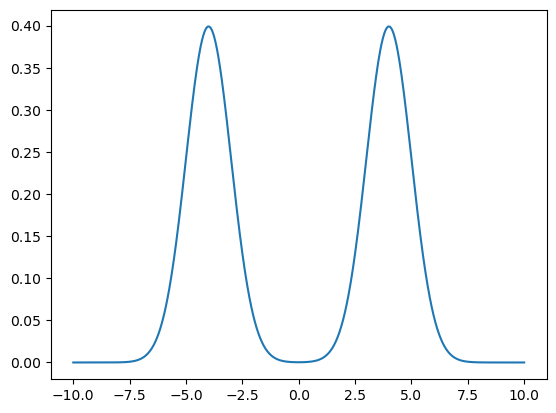

In [413]:
plt.plot(x,y)

In [414]:
y = pd.DataFrame(y)

In [415]:
x = pd.DataFrame(x)

In [416]:
emulator = GPE.ensemble(x,y,mean_func="constant",training_iter=500)

0


In [417]:
x_test = pd.DataFrame(np.linspace(-10,10,1000))

/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/gpytorch/models/exact_gp.py:284: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


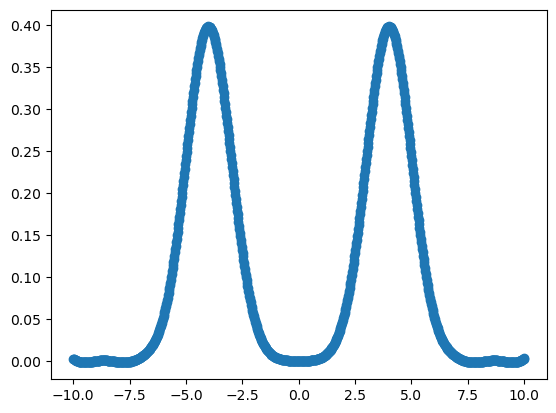

In [418]:
plt.plot(x_test,emulator.predict(x_test).detach().numpy(),'o')

In [419]:
xx=np.random.multivariate_normal(mean=[0], cov=np.identity(1),size=1000).T

In [420]:
y_test=pd.DataFrame(np.array([0.3]))

In [421]:
result = minimize(ELBO, [-1,1], args = (xx,emulator,y_test,1,1,x.columns),method = 'Nelder-Mead',tol=1e-6)

-1278.9461339774607
1.4189385332046727
0   -0.98867
dtype: float64
1277.527195444256
-1263.5544768926134
1.4189385332046727
0   -1.03867
dtype: float64
1262.1355383594087
-1266.481911920511
1.4677286973741046
0   -0.988103
dtype: float64
1265.014183223137
-1251.5994518103232
1.4677286973741044
0   -1.038103
dtype: float64
1250.1317231129492
-1236.7326434727522
1.4912591947842986
0   -1.06282
dtype: float64
1235.2413842779679
-1241.6110215099675
1.443631145795044
0   -1.113386
dtype: float64
1240.1673903641724
-1205.7856384172665
1.5142487130089972
0   -1.137537
dtype: float64
1204.2713897042574
-1181.2786985160926
1.5587004755798308
0   -1.18697
dtype: float64
1179.7199980405128
-1188.0391625048828
1.601260089998627
0   -1.136404
dtype: float64
1186.437902414884
-1137.8534705239258
1.6618847118150613
0   -1.260554
dtype: float64
1136.1915858121108
-1087.0346653271065
1.7373922643232063
0   -1.359421
dtype: float64
1085.2972730627832
-1086.8540837106882
1.700350992642857
0   -1.409987
d

-15.78550694496686
-2.2476702962649346
0   -4.757602
dtype: float64
18.033177241231794
-15.76527110290566
-2.2673679960012403
0   -4.758441
dtype: float64
18.0326390989069
-15.758480601551414
-2.2740914328259265
0   -4.757806
dtype: float64
18.03257203437734
-15.762225346534462
-2.2707941931894045
0   -4.757209
dtype: float64
18.033019539723867
-15.764284538048887
-2.2682234454117984
0   -4.758133
dtype: float64
18.032507983460686
-15.774370072011758
-2.2582830373988583
0   -4.758171
dtype: float64
18.032653109410617
-15.762375988622221
-2.2701158436748843
0   -4.757897
dtype: float64
18.032491832297104
-15.758287391013482
-2.274271480344428
0   -4.758186
dtype: float64
18.03255887135791
-15.765891472126
-2.266627784568183
0   -4.75793
dtype: float64
18.032519256694183
-15.760806637478456
-2.2717170844622014
0   -4.758101
dtype: float64
18.032523721940656
-15.76460338544778
-2.2678976833857356
0   -4.757972
dtype: float64
18.032501068833515
-15.76277900147389
-2.269789464694342
0   -4.

In [422]:
print(result)

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 18.032458033567295
             x: [-4.758e+00  2.501e-02]
           nit: 86
          nfev: 173
 final_simplex: (array([[-4.758e+00,  2.501e-02],
                       [-4.758e+00,  2.501e-02],
                       [-4.758e+00,  2.501e-02]]), array([ 1.803e+01,  1.803e+01,  1.803e+01]))


In [423]:
var = scipy.stats.multivariate_normal(mean=(result.x[0]), cov=result.x[1]**2)
val = var.pdf(x_test)

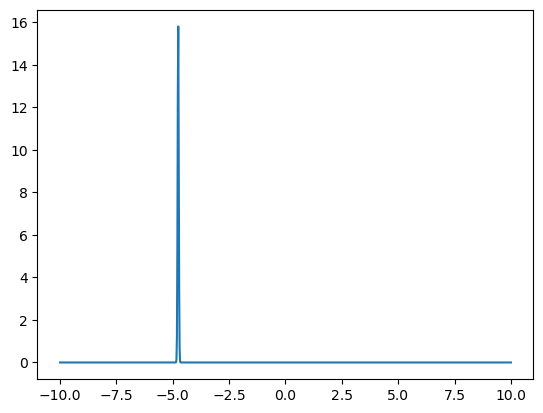

In [424]:
plt.plot(x_test,val)

In [425]:
likelihood = np.zeros(x_test.shape[0])
for i in range(x_test.shape[0]):
    
    likelihood[i] = np.prod(emulator.ensemble_likelihood(x_test.iloc[[i]],y_test))
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [426]:
var_prior = scipy.stats.multivariate_normal(mean=0, cov=10)
val_prior = var_prior.pdf(x_test)

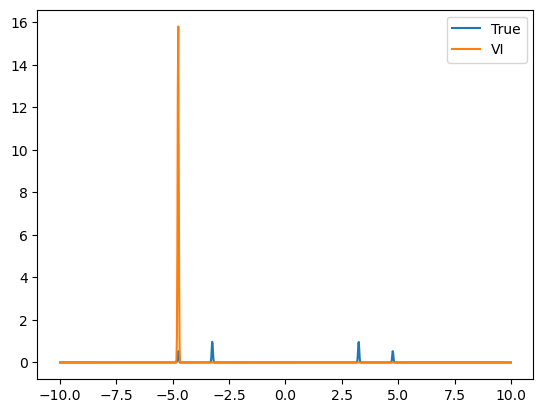

In [427]:
plt.plot(x_test,val_prior*likelihood/(np.sum(val_prior*likelihood)*0.1))
plt.plot(x_test,val)
plt.legend(('True','VI'))

In [428]:
x_test.iloc[0]-x_test.iloc[1]

0   -0.02002
dtype: float64

In [429]:
np.sum(val_prior*likelihood)

6.859134285023373

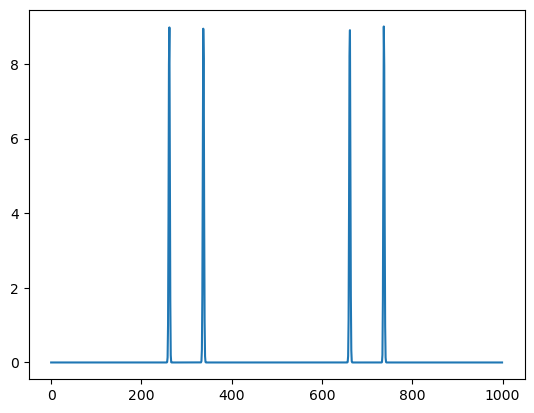

In [430]:
plt.plot(likelihood)

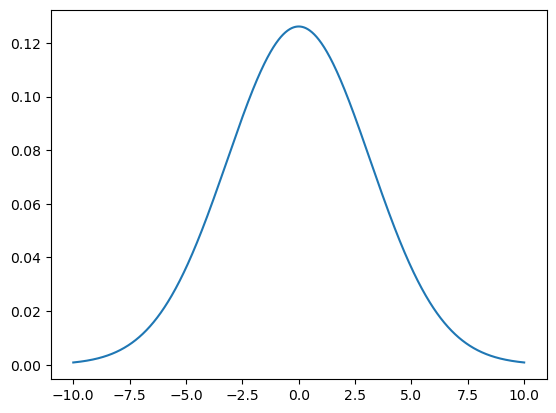

In [431]:
plt.plot(x_test,val_prior)